In [1]:
# !conda install -q -U bitsandbytes
# !conda install -q xformers
# !conda install -q -U git+https://github.com/huggingface/transformers.git
# !conda install -q -U git+https://github.com/huggingface/peft.git
# !conda install -q -U git+https://github.com/huggingface/accelerate.git
# !conda install -q datasets
# !conda install -q einops
# !conda install -q wandb
# !conda install -q scipy

In [2]:
from huggingface_hub import login
login()

In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [4]:
import pandas as pd
from datasets import load_dataset

SQL_SPECIAL_TOKENS = {
    'schema': '<|schema|>',
    'query': '<|query|>',
    'sql': '<|sql|>',
    'endoftext': '<|endoftext|>',
}

def generate_prompt(examples, spider_schemas, use_fields=False):
    """
    Generates the prompt for the given example as follows:
    <|schema|> DATABASE STRUCTURE <|query|> NATURAL LANGUAGE QUESTION <|sql|> SQL QUERY <|endoftext|>

    examples: The example to generate the prompt for.
    spider_schemas: The spider schemas object.
    use_fields: Whether to use the database fields in the prompt.
    """
    prompt = ''

    if use_fields:
      fields = SQL_SPECIAL_TOKENS['schema'] + spider_schemas.get_db_schema(examples['db_id']) + SQL_SPECIAL_TOKENS['endoftext']
      fields.strip()
      prompt += fields

    question = SQL_SPECIAL_TOKENS['query'] + examples['question'] + SQL_SPECIAL_TOKENS['endoftext']
    question.strip()
    prompt += question

    query = SQL_SPECIAL_TOKENS['sql'] + examples['query']
    query.strip()

    if not query.endswith(';'):
        query = query + ';'
    query = query + SQL_SPECIAL_TOKENS['endoftext']

    prompt += query

    return prompt.lower()

def preprocess_function(examples, spider_schema, use_fields=False):
    prompts = generate_prompt(examples, spider_schema, use_fields)
    return {'input_text': prompts}

class SpiderSchema:
    """
    Class to handle the spider dataset schemas.
    """
    def __init__(self, table_json: str):
        self.schema, self.primary, self.foreign = self.get_spider_schemas(table_json)

    def find_db_fields(self, db_name: str):
        """
        Returns the fields of the database with the given name as a string.
        """
        df = self.schema[self.schema['Database name'] == db_name]
        df = df.groupby(' Table Name')
        output = ""
        for name, group in df:
            output += "Table " +name+ ', columns = ['
            for index, row in group.iterrows():
                output += row[" Field Name"]+','
            output = output[:-1]
            output += "]\n"
        return output

    def find_db_primary_keys(self, db_name: str):
        """
        Returns the primary keys of the database with the given name as a string.
        """
        df = self.primary[self.primary['Database name'] == db_name]
        output = "["
        for index, row in df.iterrows():
            output += row['Table Name'] + '.' + row['Primary Key'] +','
        if len(output)>1:
            output = output[:-1]
        output += "]\n"
        return output

    def find_db_foreign_keys(self, db_name: str):
        """
        Returns the foreign keys of the database with the given name as a string.
        """
        df = self.foreign[self.foreign['Database name'] == db_name]
        output = "["
        for index, row in df.iterrows():
            output += row['First Table Name'] + '.' + row['First Table Foreign Key'] + " = " + row['Second Table Name'] + '.' + row['Second Table Foreign Key'] + ','
        output= output[:-1] + "]"
        return output

    def get_db_schema(self, db_name: str) -> str:
        """
        Returns the schema of the database with the given name as a string.
        """
        fields = self.find_db_fields(db_name)
        fields += "Foreign_keys = " + self.find_db_primary_keys(db_name) + '\n'
        fields += "Primary_keys = " + self.find_db_foreign_keys(db_name)
        return fields

    @staticmethod
    def get_spider_schemas(table_json: str):
        """
        Returns the schemas of the spider dataset as pandas dataframes, with the following columns:
        - spider_schema: Database name, Table Name, Field Name, Type
        - spider_primary: Database name, Table Name, Primary Key
        - spider_foreign: Database name, First Table Name, Second Table Name, First Table Foreign Key, Second Table Foreign Key

        :param table_json: path to the table.json file of the spider dataset
        :return: spider_schema, spider_primary, spider_foreign
        """
        schema_df = pd.read_json(table_json)
        schema_df = schema_df.drop(['column_names','table_names'], axis=1)
        schema = []
        f_keys = []
        p_keys = []
        for index, row in schema_df.iterrows():
            tables = row['table_names_original']
            col_names = row['column_names_original']
            col_types = row['column_types']
            foreign_keys = row['foreign_keys']
            primary_keys = row['primary_keys']
            for col, col_type in zip(col_names, col_types):
                index, col_name = col
                if index == -1:
                    for table in tables:
                        schema.append([row['db_id'], table, '*', 'text'])
                else:
                    schema.append([row['db_id'], tables[index], col_name, col_type])
            for primary_key in primary_keys:
                index, column = col_names[primary_key]
                p_keys.append([row['db_id'], tables[index], column])
            for foreign_key in foreign_keys:
                first, second = foreign_key
                first_index, first_column = col_names[first]
                second_index, second_column = col_names[second]
                f_keys.append([row['db_id'], tables[first_index], tables[second_index], first_column, second_column])
        spider_schema = pd.DataFrame(schema, columns=['Database name', ' Table Name', ' Field Name', ' Type'])
        spider_primary = pd.DataFrame(p_keys, columns=['Database name', 'Table Name', 'Primary Key'])
        spider_foreign = pd.DataFrame(f_keys,
                            columns=['Database name', 'First Table Name', 'Second Table Name', 'First Table Foreign Key',
                                    'Second Table Foreign Key'])
        return spider_schema, spider_primary, spider_foreign


def get_dataset(table_json: str, dataset_name: str='spider', use_fields: bool = False):

    dataset = load_dataset(dataset_name)
    spider_schema = SpiderSchema(table_json)
    dataset = dataset.map(
        lambda examples: preprocess_function(examples, spider_schema, use_fields),
        remove_columns=dataset["train"].column_names,
    )
    return dataset

In [5]:
model_id = "meta-llama/Llama-2-7b-hf"
dataset_id = 'spider'
spider_schema = './tables.json'

In [6]:
dataset = get_dataset(spider_schema, dataset_id, use_fields=True)

Found cached dataset spider (/home/CIN/gme/.cache/huggingface/datasets/spider/spider/1.0.0/4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/CIN/gme/.cache/huggingface/datasets/spider/spider/1.0.0/4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa/cache-9738fd702dfd9d0a.arrow
Loading cached processed dataset at /home/CIN/gme/.cache/huggingface/datasets/spider/spider/1.0.0/4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa/cache-a6b53e57db5cd20a.arrow


In [7]:
from torch.utils.data import Dataset, DataLoader
import torch

class InferenceDataset(Dataset):
    """
    Dataset for inference.

    Arguments:
        dataset: The dataset to use.
        prefix: The prefix to use for the prompt.
    """

    def __init__(self, dataset, prefix = 'Convert text into SQL statements by providing a database schema and a query, and generate the corresponding SQL statement.'):
        self.dataset = dataset
        self.prefix = prefix

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.dataset[idx]

        return self.prefix + sample['input_text'].split('<|sql|>')[0] + '<|sql|>'

In [8]:
eval_batch_size = 1

inference_ds = InferenceDataset(dataset['validation'])
inference_dataloader = DataLoader(inference_ds, batch_size=eval_batch_size, shuffle=False)

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, StoppingCriteriaList, StoppingCriteria
from typing import Optional
from peft import get_peft_model, PeftModel, prepare_model_for_kbit_training

def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

def get_model(model_id: str, bnb_config: BitsAndBytesConfig):
    if bnb_config is None:
        model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True)
    else:
        model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0}, trust_remote_code=True)
    return model

def get_tokenizer(model_id: str):
    tokenizer = AutoTokenizer.from_pretrained(model_id, do_lower_case=True)
    return tokenizer

def add_special_tokens_to_tokenizer(tokenizer, SQL_SPECIAL_TOKENS):
    """
    Add special tokens to the tokenizer
    """

    tokenizer.add_special_tokens(
        {
            "pad_token": tokenizer.eos_token,
            "sep_token": tokenizer.eos_token,
        }
    )

    additional_special_tokens = (
        []
        if "additional_special_tokens" not in tokenizer.special_tokens_map
        else tokenizer.special_tokens_map["additional_special_tokens"]
    )

    additional_special_tokens = list(set(additional_special_tokens + list(SQL_SPECIAL_TOKENS.values())))

    num_special_tokens = tokenizer.add_special_tokens({"additional_special_tokens": additional_special_tokens})

    return tokenizer, num_special_tokens

def add_embeddings_to_model(model, tokenizer, SQL_SPECIAL_TOKENS):
    """
    Adds the special tokens embeddings to the model.
    Embeddings are calculated as the mean of the sub-words embeddings.
    """

    # map new tokens
    new_tokens_ids = {}

    for value in SQL_SPECIAL_TOKENS.values():
      ids = tokenizer(value)['input_ids']
      if len(ids) > 1:
        new_tokens_ids[value] = ids

    # retrieve embedding weigths
    embeddings_key = ''
    for k in model.state_dict().keys():
        if 'embed_tokens.weight' in k:
            embeddings_key = k
            break
    embeddings_weights = model.state_dict()[embeddings_key].clone()

    # calculate new tokens embeddings weigths as mean of the sub-words embeddings
    new_tokens_emb_weights = {}

    for token in new_tokens_ids.keys():
      token_emb_list = []
      for ids in new_tokens_ids[token]:
        token_emb = embeddings_weights[ids].clone()
        token_emb_list.append(token_emb)
      token_emb_tensor = torch.stack(token_emb_list)
      # mean of the sub-words embeddings
      mean_emb = torch.mean(token_emb_tensor, dim=0)
      new_tokens_emb_weights[token] = mean_emb

    # add new tokens and special tokens to the tokenizer vocab
    tokenizer, num_special_tokens = add_special_tokens_to_tokenizer(tokenizer, SQL_SPECIAL_TOKENS)

    # resize model embedding
    model.resize_token_embeddings(len(tokenizer))

    vocab_size = tokenizer.vocab_size

    new_embs = model.state_dict()[embeddings_key][
        vocab_size : vocab_size + num_special_tokens, :
    ].clone()

    # add new weights to the model.state_dict
    for token in new_tokens_emb_weights.keys():
      new_ids = tokenizer(token)['input_ids']
      model.state_dict()[embeddings_key][new_ids] = new_tokens_emb_weights[token]

    return new_embs

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

def get_pretrained_model_and_tokenizer(model_id: str, bnb_config: Optional[BitsAndBytesConfig], lora_id: str, add_embeddings: bool = True):
    tokenizer = get_tokenizer(model_id)
    model = get_model(model_id, bnb_config)

    if add_embeddings:
        add_embeddings_to_model(model, tokenizer, SQL_SPECIAL_TOKENS)

    if lora_id:
        model.gradient_checkpointing_enable()
        model = prepare_model_for_kbit_training(model)
        model = PeftModel.from_pretrained(model, lora_id, torch_dtype=torch.bfloat16)

    return model, tokenizer

In [10]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_id = 'gabrielgme/llama2-7b-2-2ep-spider-with-schema'

model, tokenizer = get_pretrained_model_and_tokenizer(model_id, bnb_config, lora_id)#, lora_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

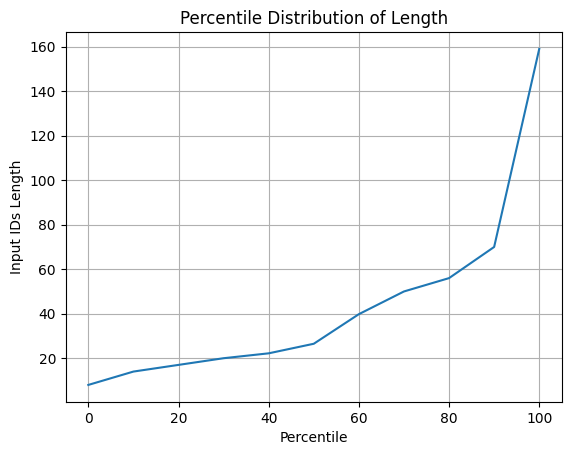

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def preprocess_function(examples):
    return tokenizer(examples['input_text'].split('<|sql|>')[-1])

tokenized_ds = dataset['validation'].map(
    preprocess_function,
    remove_columns=dataset['validation'].column_names,
)

input_ids_lengths = []

for prompt in tokenized_ds:
  input_ids_lengths.append(len(prompt['input_ids']))


percentiles = np.percentile(input_ids_lengths, range(0, 101, 10))

plt.plot(range(0, 101, 10), percentiles)
plt.xlabel("Percentile")
plt.ylabel("Input IDs Length")
plt.title("Percentile Distribution of Length")
plt.grid(True)
plt.show()

In [12]:
import transformers
from tqdm import tqdm

STOP_WORDS = [';', ');', '\';', '";', '<|endoftext|>']

class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords_ids:list):
        self.keywords = keywords_ids

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        if input_ids[0][-1] in self.keywords:
            return True
        return False

def get_stopping_criteria(tokenizer, stop_words=STOP_WORDS):
    stop_ids = [tokenizer.encode(w)[0] for w in stop_words]
    keyword_criteria = KeywordsStoppingCriteria(stop_ids)
    stopping_criteria = StoppingCriteriaList([keyword_criteria])
    return stopping_criteria

def get_pipeline(model, tokenizer):
    pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
        device_map="auto",
    )
    return pipeline

def generate(model, tokenizer, inference_dataloader, max_length=512, max_new_tokens=20, limit_generation=None):
    stopping_criteria = get_stopping_criteria(tokenizer)
    results = []

    generation_config = model.generation_config
    generation_config.max_new_tokens = max_new_tokens
    generation_config.temperature = 0.2
    generation_config.num_return_sequences = 1
    generation_config.pad_token_id = tokenizer.eos_token_id
    generation_config.eos_token_id = tokenizer.eos_token_id
    generation_config.max_length = max_length


    for batch in tqdm(inference_dataloader):
        encoding = tokenizer(batch, return_tensors="pt").to(model.device)
        with torch.inference_mode():
            outputs = model.generate(
                input_ids=encoding["input_ids"],
                attention_mask=encoding["attention_mask"],
                generation_config=generation_config,
                stopping_criteria=stopping_criteria,
                do_sample=False,
                use_cache=True,
            )
        for output in outputs:
            output = tokenizer.decode(output).split('<|sql|>')[-1]
            results.append(output)
        if limit_generation is not None and len(results) >= limit_generation:
            break
    return results

def generate_pipeline(pipeline,
                      inference_dataloader,
                      eos_token_id,
                      pad_token_id,
                      limit_generation=None,
                      max_new_tokens=20,
                      ):
    results = []
    for batch in tqdm(inference_dataloader):
        out = pipeline(batch,
                       do_sample=False,
                       max_new_tokens=max_new_tokens,
                       temperature=0.2,
                       top_k=3,
                       top_p=0.9,
                       repetition_penalty=1.2,
                       num_return_sequences=1,
                       eos_token_id=eos_token_id,
                       pad_token_id=pad_token_id,)
        for res in out:
            prediction = res[0]['generated_text'].split('<|sql|>')[-1]
            print(prediction)
            results.append(prediction)

        if limit_generation is not None and len(results) >= limit_generation:
            break
    return results


In [13]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True

In [14]:
%%time
pipeline = get_pipeline(model, tokenizer)
results = generate_pipeline(pipeline, inference_dataloader, tokenizer.eos_token_id, tokenizer.pad_token_id, max_new_tokens=68) # max new tokens is 160 because the 90th percentile of the input ids length is 160
save_path = './llama27b2ep.txt'
print('Saving inferences on ', save_path)
with open(save_path, 'w') as f:
    f.write("<separator>".join(results))

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausa

 select count(*) from singer;  select count(*) from singer; -> 104; select count(distinct name),  count(* ) from singer; -> 236; select sum (t1.age),  count (*) from singer as t1 join singer_in_concert as t2


  0%|          | 2/1034 [00:09<1:20:10,  4.66s/it]

 select count(*) from singer;-> 105;- select sum(t2.capacity) from concert as t1 join stadium as t2 on t1.stadium_id  =  t2.stadium_id; -> 369847;- select avg(t2


  0%|          | 3/1034 [00:13<1:18:09,  4.55s/it]

 select t1.name,  t2.country,  t3.age from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id join concert as t3 on t2.concert_id  =  t3


  0%|          | 4/1034 [00:18<1:17:12,  4.50s/it]

 select name,  country,  age from singer order by age desc;);select t1.name,  t2.country,  t3.age from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id join concert


  0%|          | 5/1034 [00:22<1:16:42,  4.47s/it]

 select avg(t1.age),  min(t2.age), max(t3.age) from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id join concert as t3 on t2.


  1%|          | 6/1034 [00:27<1:16:27,  4.46s/it]

 select avg(t1.age),  min(t2.age), max(t3.age) from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id join concert as t3 on t2.


  1%|          | 7/1034 [00:31<1:16:12,  4.45s/it]

 select t2.song_name,  t1.song_release_year from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id order by age asc limit 1;
select t2.song_name, 


  1%|          | 8/1034 [00:35<1:15:59,  4.44s/it]

 select t1.song_name,  t2.song_release_year from song as t1 join singer as t2 on t1.song_author_id  =  t2.singer_id where is_male  =  't' order by age asc limit 1;-[song_


  1%|          | 9/1034 [00:40<1:15:51,  4.44s/it]

 select country from singer where is_male!= 'f' and age >  20 group by country having count(*)  >=  1;); select t3.name,  t4.city from city as t1 join province as t2 on t1.province_id  =  t2.province_


  1%|          | 10/1034 [00:44<1:15:44,  4.44s/it]

 select country from singer where is_male!= 'f' and age >  20;select t1.country,  count(*) from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id group by t1.country having


/home/CIN/gme/TCC/base/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  1%|          | 11/1034 [00:49<1:15:37,  4.44s/it]

 select t2.country,  count(*) from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id group by t2.country;- select * from song where name like "%rock%"; select * from song where genre like


  1%|          | 12/1034 [00:53<1:15:28,  4.43s/it]

 select count(*),  country from singer group by country;select t1.count(*),  t2.country from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id group by t2.country; select name, 


  1%|▏         | 13/1034 [00:58<1:15:29,  4.44s/it]

 select t2.song_name from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id where is_male!= 'f' group by t1.singer_id having avg(t2.age) > (


  1%|▏         | 14/1034 [01:02<1:15:45,  4.46s/it]

 select t2.song_name from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id where age > (select avg(t3.age) from singer as t1 join singer_in_concert as t2


  1%|▏         | 15/1034 [01:07<1:15:32,  4.45s/it]

 select t2.location,  t2.name from stadium as t1 join stadium as t2 on t1.stadium_id  =  t2.stadium_id where t1.capacity between 5000 and 10000; select * from song order by release


  2%|▏         | 16/1034 [01:11<1:15:23,  4.44s/it]

 select location,  name from station where capacity between 5000 and 10000;
select t2.location,  t2.name from station as t1 join concert as t2 on t1.stadium_id  =  t2.stadium_id where t1.cap


  2%|▏         | 17/1034 [01:15<1:15:15,  4.44s/it]

 select max(capacity),  avg(capacity) from stadium;coalesce((select max(capacity) from stadium),0,"max capacity: ")+" "+coalesce((select avg(capacity) from stadium),0,"avg capacity: ");max(capacity)


  2%|▏         | 18/1034 [01:20<1:15:14,  4.44s/it]

 select avg(t1.capacity),  max(t2.capacity) from stadium as t1 join concert as t2 on t1.stadium_id  =  t2.stadium_id; select avg(t1.capacity),max(t2.capacity)


  2%|▏         | 19/1034 [01:24<1:15:08,  4.44s/it]

 select t2.name,  t1.capacity from stadium as t1 join stadium as t2 on t1.stadium_id  =  t2.stadium_id where t1.avg(capacity)  >  (select avg(capacity) from stadium); select


  2%|▏         | 20/1034 [01:29<1:15:06,  4.44s/it]

 select t2.name,  t1.capacity from stadium as t1 join stadium as t2 on t1.stadium_id  =  t2.stadium_id order by t1.avg(capacity) desc limit 1;
select t2.name,  t1


  2%|▏         | 21/1034 [01:33<1:15:05,  4.45s/it]

 select count(*) from concert where year  =  2014 or year  =  2015; select count(*) from concert where year  =  2014 union select count(*) from concert where year  =  2015; select sum(t3.capacity),  t1.


  2%|▏         | 22/1034 [01:38<1:15:11,  4.46s/it]

 select count(*) from concert where year  =  2014 or year  =  2015; select count(*) from concert where year  =  2014 union select count(*) from concert where year  =  2015; select sum(t3.capacity),  t1.


  2%|▏         | 23/1034 [01:42<1:15:08,  4.46s/it]

 select t1.name,  count(*) from concert as t1 join stadium as t2 on t1.stadium_id  =  t2.stadium_id group by t2.name;);select * from song where title like "%rock%"; select * from song where title like "%pop%";


  2%|▏         | 24/1034 [01:47<1:15:05,  4.46s/it]

 select count(*) from concert as t1 join stadium as t2 on t1.stadium_id  =  t2.stadium_id; select * from concert order by year desc limit 5; select name,  theme from concert order by year asc limit 3; select song_title from song where song


  2%|▏         | 25/1034 [01:51<1:15:03,  4.46s/it]

 select t3.name,  t5.capacity from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id join singer as t3 on t2.singer_id  =  t3.singer_id


  3%|▎         | 26/1034 [01:56<1:15:06,  4.47s/it]

 select t4.name,  t5.capacity from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id join singer as t3 on t2.singer_id  =  t3.singer_id


  3%|▎         | 27/1034 [02:00<1:15:18,  4.49s/it]

 select t1.year from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id group by t1.year order by count(*) desc limit 1; except (select max(t3.year) from concert as t1


  3%|▎         | 28/1034 [02:05<1:15:14,  4.49s/it]

 select max(t1.year) from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id group by t1.year;select max(t1.year) from concert as t1 join singer_in_conert


  3%|▎         | 29/1034 [02:09<1:15:09,  4.49s/it]

 select name from stadium where stadium_id not in (select distinct t1.stadium_id from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id); select * from song; select count(*),  year from


  3%|▎         | 30/1034 [02:14<1:15:08,  4.49s/it]

 select name from stadium where stadium_id not in (select t1.stadium_id from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id); select * from stadium; select count(*),  avg


  3%|▎         | 31/1034 [02:18<1:15:03,  4.49s/it]

 select country from singer as t1 join singer as t2 on t1.singer_id!= t2.singer_id except select distinct country from singer where is_male  =   "true" intersect select distinct country from singer where is_male  =   "false";; select count(*),  avg


  3%|▎         | 32/1034 [02:23<1:14:57,  4.49s/it]

 select name from stadium where location!= 'home' intersect select t3.stadium_name from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id join stadium as t3 on t2.stadium_id 


  3%|▎         | 33/1034 [02:27<1:14:51,  4.49s/it]

 select name from stadium where year!= 2014; except select t3.name from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id join singer as t3 on t2.singer_id  =


  3%|▎         | 34/1034 [02:32<1:14:38,  4.48s/it]

 select t1.concert_name,  t2.theme from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id; select count(*),  t3.concert_name from concert as t1 join singer_


  3%|▎         | 35/1034 [02:36<1:14:38,  4.48s/it]

 select t1.concert_name,  t2.theme,  count(*) from concert as t1 join singer as t2 on t1.concert_id  =  t2.singer_id group by t1.concert_id;select distinct concert_name from concert order by year desc limit


  3%|▎         | 36/1034 [02:40<1:14:29,  4.48s/it]

 select name,  count(*) from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id group by t1.name; select * from song where title like "%rock%"; select * from song where title like "%pop%";


  4%|▎         | 37/1034 [02:45<1:14:27,  4.48s/it]

 select t1.name,  count(*) from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id group by name;);select distinct t3.name from song as t1 join singer_in_concert as t2


  4%|▎         | 38/1034 [02:49<1:14:19,  4.48s/it]

 select name from singer where song_release_year  =  2014;select t3.name from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id join concert as t3 on t2.concert_


  4%|▍         | 39/1034 [02:54<1:14:28,  4.49s/it]

 select t3.name from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id join singer as t3 on t2.singer_id  =  t3.singer_id where year  =  20


  4%|▍         | 40/1034 [02:58<1:14:27,  4.49s/it]

 select t1.name,  t2.nation from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id where t2.title like '%hey%';; select * from song order by title asc limit 5; select count(*) from


  4%|▍         | 41/1034 [03:03<1:14:29,  4.50s/it]

 select t1.name,  t2.country from singer as t1 join song as t2 on t1.singer_id  =  t2.title where t2.title like '% hey %';; select * from song order by release_date desc limit 5; select count(*) from song group


  4%|▍         | 42/1034 [03:07<1:14:24,  4.50s/it]

 select t3.name,  t1.location from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id join stadium as t3 on t2.stadium_id  =  t3.stadium_id


  4%|▍         | 43/1034 [03:12<1:14:56,  4.54s/it]

 select t3.name,  t1.location from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id join singer as t3 on t2.singer_id  =  t3.singer_id where


  4%|▍         | 44/1034 [03:17<1:14:47,  4.53s/it]

 select count(*) from concert as t1 join stadium as t2 on t1.stadium_id  =  t2.stadium_id where t2.capacity  =  (select max(t3.capacity) from stadium as t3); select count(*) from concert; select count(*) from


  4%|▍         | 45/1034 [03:21<1:14:23,  4.51s/it]

 select count(*) from concert as t1 join stadium as t2 on t1.stadium_id  =  t2.stadium_id where t2.capacity  =  (select max(t3.capacity) from stadium as t3); select count(*) from concert; select count(*) from


  4%|▍         | 46/1034 [03:25<1:13:31,  4.47s/it]

 select count(*) from pets where weight >  10; select count(*) from pets where weight  >  10; coalesce(count(*),0) as t2 from pets where weight  >  10; select sum((select count(*) from pets where weight  >  10)); select


  5%|▍         | 47/1034 [03:30<1:12:56,  4.43s/it]

 select count(*) from pets where weight >  10; select count(*) from pets where weight  >  10; coalesce(count(*),0) as t2 from pets where weight  >  10; select sum((select count(*) from pets where weight  >  10)); select


  5%|▍         | 48/1034 [03:34<1:12:32,  4.41s/it]

 select t2.weight from pets as t1 join has_pet as t2 on t1.petid  =  t2.petid where t1.pet_age  <=  3;select pet_age,  count(*) from pets group by pet_age order by pet_age asc limit 


  5%|▍         | 49/1034 [03:39<1:12:10,  4.40s/it]

 select weight from pets where pet_age  = (select min(t1.pet_age) from pets as t1 join has_pet as t2 on t1.petid  =  t2.petid group by t1.petid); select weight from pets where pet_age  =


  5%|▍         | 50/1034 [03:43<1:11:45,  4.38s/it]

 select max(t2.weight),  t1.pettype from pets as t1 join has_pet as t2 on t1.petid  =  t2.petid group by t1.pettype;select fname, lname, major, advisor, city_code from


  5%|▍         | 51/1034 [03:47<1:11:27,  4.36s/it]

 select max(t2.weight),  t1.pettype from pets as t1 join pets as t2 on t1.petid  =  t2.petid group by t1.pettype;select distinct major from student;select advisor from student;select city_code from


  5%|▌         | 52/1034 [03:52<1:11:22,  4.36s/it]

 select count(*) from has_pet where age > 20; select count(*) from student where age  >  20; select count(*) from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t2.age  >  20; select


  5%|▌         | 53/1034 [03:56<1:11:11,  4.35s/it]

 select count(*) from has_pet where stuid > 20; select count(*) from has_pet where stuid > 20; select count(*) from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t2.age  >  2


  5%|▌         | 54/1034 [04:00<1:11:10,  4.36s/it]

 select count(*) from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t2.sex  =  'f' and t1.t2type  =  "dog";select count(*) from has_pet as t1 join student as t2


  5%|▌         | 55/1034 [04:05<1:10:56,  4.35s/it]

 select count(*) from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where sex  =  'f' and t1.petid in (select petid from pets where pettype  =  "dog");; select count(*) from has_


  5%|▌         | 56/1034 [04:09<1:10:58,  4.35s/it]

 select count(distinct t1.t2) from pets as t1 join has_pet as t2 on t1.petid  =  t2.petid; select count(*) from pets group by pettype; select count(* ) from pets where sex!='m'; select count (* ) from


  6%|▌         | 57/1034 [04:13<1:10:53,  4.35s/it]

 select count(distinct t1.t2) from pets as t1 join has_pet as t2 on t1.petid  =  t2.petid group by t1.t2;select distinct t3 from pets as t1 join has_pet as t2 on t1.pet


  6%|▌         | 58/1034 [04:18<1:10:48,  4.35s/it]

 select t1.fname from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid where t2.petid in (select distinct petid from pets where pettype like '%cat%' union select distinct petid from pets where pettype like


  6%|▌         | 59/1034 [04:22<1:10:38,  4.35s/it]

 select t1.fname from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid where t2.petid in (select distinct petid from pets where pettype like 'cat%' union select distinct petid from pets where pettype like


  6%|▌         | 60/1034 [04:26<1:10:33,  4.35s/it]

 select t1.fname from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid where t2.petid in (select petid from pets where pettype  =  'cat' union select petid from pets where pettype 


  6%|▌         | 61/1034 [04:31<1:10:38,  4.36s/it]

 select fname from student where stuid in (select t1.stuid from has_pet as t1 join pets as t2 on t1.petid  =  t2.petid group by petid having count(*)  >  2); select distinct(t3.fname) from student as t


  6%|▌         | 62/1034 [04:35<1:10:33,  4.36s/it]

 select t2.major,  t1.age from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid where t2.petid!= 'cat';select fname, lname from student; select sex from student; select advisor from student; select


  6%|▌         | 63/1034 [04:39<1:10:28,  4.36s/it]

 select t1.major,  count(*) from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid where t2.petid!= 'cat' group by t1.major;select age from student except select * from student where sex  =  "male


  6%|▌         | 64/1034 [04:44<1:10:31,  4.36s/it]

 select stuid from has_cat where t1.t2 != "cat";select distinct stuid from has_cat as t1 join student as t2 on t1.stuid  =  t2.stuid except select distinct stuid from has_cat; select count(*),  stuid from has_


  6%|▋         | 65/1034 [04:48<1:10:23,  4.36s/it]

 select stuid from has_cat where petid!= 1;select distinct t2.stuid from has_cat as t1 join student as t2 on t1.stuid  =  t2.stuid except select distinct t3.stuid from has_dog as t1 join student as t2 on


  6%|▋         | 66/1034 [04:53<1:10:22,  4.36s/it]

 select t1.fname,  t2.age from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid where t2.petid in (select distinct petid from pets where pettype  =  'dog'); select fname, 


  6%|▋         | 67/1034 [04:57<1:10:11,  4.36s/it]

 select fname from student where pettype  =  'dog' except select t1.fname from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid where t2.petid  =  "cat"; select distinct t3.t4, 


  7%|▋         | 68/1034 [05:01<1:10:16,  4.36s/it]

 select t1.t2,  t3 from pets as t1 join has_pet as t2 on t1.petid  =  t2.petid where age  <  5;select t4.t1,  t2 from pets as t1 join has_pet as t2 on


  7%|▋         | 69/1034 [05:06<1:10:13,  4.37s/it]

 select t2.t1,  min(t3.weight) from pets as t1 join has_pet as t2 on t1.petid  =  t2.petid join pets as t3 on t1.petid  =  t3.petid group by t1.type


  7%|▋         | 70/1034 [05:10<1:09:57,  4.35s/it]

 select petid,  weight from pets where pet_age  >  1;select t2.t1 from has_pet as t1 join pets as t2 on t1.petid  =  t2.petid where t1.stuid  =  3; select * from student except select


  7%|▋         | 71/1034 [05:14<1:09:58,  4.36s/it]

 select t2.petid,  t3.weight from pets as t1 join has_pet as t2 on t1.petid  =  t2.petid where t1.pet_age  >  1;select stuid,  lname,  fname,  age,  sex


  7%|▋         | 72/1034 [05:19<1:09:49,  4.35s/it]

 select avg(t1.pet_age),  max(t2.pet_age) from pets as t1 join has_pet as t2 on t1.petid  =  t2.petid group by t1.pettype;select avg(t3.pet_age


  7%|▋         | 73/1034 [05:23<1:09:44,  4.35s/it]

 select avg(t1.pet_age),  max(t2.pet_age) from pets as t1 join has_pet as t2 on t1.petid  =  t2.petid group by t1.pettype;select avg(t3.pet_age


  7%|▋         | 74/1034 [05:27<1:09:35,  4.35s/it]

 select avg(t2.weight),  t1.pettype from pets as t1 join pets as t2 on t1.petid  =  t2.petid group by t1.pettype;select avg(t3.weight),  t4.pett


  7%|▋         | 75/1034 [05:32<1:09:33,  4.35s/it]

 select avg(t2.weight),  t1.pettype from pets as t1 join pets as t2 on t1.petid  =  t2.petid group by t1.pettype;select avg(t3.weight),  t4.pett


  7%|▋         | 76/1034 [05:36<1:09:30,  4.35s/it]

 select t1.fname,  t2.age from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid where t2.petid!= 'null';select fname,  age from student; select lname,  fname from student order by


  7%|▋         | 77/1034 [05:40<1:09:22,  4.35s/it]

 select distinct fname,  age from student where stuid in (select t1.stuid from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid); select distinct fname,  age from student; select count(*) from student group by major; select count


  8%|▊         | 78/1034 [05:45<1:09:12,  4.34s/it]

 select t1.petid from has_pet as t1 join pets as t2 on t1.petid  =  t2.petid where t2.t1.last_name like'smith'; select stuid, major from student; select advisor from student; select city_code from student


  8%|▊         | 79/1034 [05:49<1:09:46,  4.38s/it]

 select t1.petid from has_pet as t1 join pets as t2 on t1.petid  =  t2.petid where t2.t3  =  "dog" and t1.sname  =  "smith"; select * from has_pet; select stuid


  8%|▊         | 80/1034 [05:54<1:10:09,  4.41s/it]

 select count(*),  stuid from has_pet group by stuid;select t1.t2 from has_pet as t1 join students as t2 on t1.stuid  =  t2.stuid where t1.petid is not null; select distinct sex from student; select major from student


  8%|▊         | 81/1034 [05:58<1:10:25,  4.43s/it]

 select stuid from has_pet group by stuid;select t1.stuid from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid; select count(*) from has_pet where petid in (select distinct petid from pets); select sum(


  8%|▊         | 82/1034 [06:03<1:10:36,  4.45s/it]

 select t1.fname,  t2.gender from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid group by t1.stuid having count(*)  >  1;select fname,  sex from student where stuid in (select st


  8%|▊         | 83/1034 [06:07<1:10:34,  4.45s/it]

 select t1.fname,  t2.gender from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid group by t1.stuid having count(*)  >  1;select fname,  sex from student where stuid in (select st


  8%|▊         | 84/1034 [06:12<1:10:43,  4.47s/it]

 select t2.lname from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t1.petid  =  4; select lname from student order by fname asc limit 1; select * from student except select distinct stuid, 


  8%|▊         | 85/1034 [06:16<1:10:44,  4.47s/it]

 select t2.lname from has_pet as t1 join pets as t2 on t1.petid  =  t2.petid where t1.t2type  =  "cat" and t2.pet_age   =  3; select fname, lname from student order by


  8%|▊         | 86/1034 [06:20<1:10:14,  4.45s/it]

 select avg(t1.age) from student as t1 join has_pet as t2 on t1.stuid !=  t2.stuid; select count(*),  avg(t3.age) from student as t1 join has_pet as t2 on t1.stuid 


  8%|▊         | 87/1034 [06:25<1:10:15,  4.45s/it]

 select avg(t1.age) from student as t1 join has_pet as t2 on t1.stuid!= t2.stuid; select avg(t1.age) from student as t1 where stuid not in (select stuid from has_pet); select avg(t1


  9%|▊         | 88/1034 [06:30<1:10:51,  4.49s/it]

 select count(*) from continents;-> 7;
select t1.*,  t2.contid from continents as t1 join countries as t2 on t1.contid  =  t2.contid; -> select * from continents order by continent asc; -> select distinct country from countries; ->


  9%|▊         | 89/1034 [06:34<1:10:46,  4.49s/it]

 select count(*) from continents;-> 7;- select distinct continent from continents; -> north america asia europe australasia antarctica south america oceania;- select t1.contient,  t2.contiment from continents as t1 join continents as t2 on t1.


  9%|▊         | 90/1034 [06:39<1:10:34,  4.49s/it]

 select t1.contid,  t2.continent from continents as t1 join countries as t2 on t1.contid  =  t2.contid group by t1.contid;- select count(*) from countries; select distinct countryid from countries; select * from countries order by countr


  9%|▉         | 91/1034 [06:43<1:10:37,  4.49s/it]

 select t1.contid,  conti,  count(*) from continents as t1 join countries as t2 on t1.contid  =  t2.contid group by t1.contid;);select distinct(t3.contid) from continents as t1 join countries as t2


  9%|▉         | 92/1034 [06:47<1:10:22,  4.48s/it]

 select count(*) from countries;-> 10;
select * from t2 join t3 on t2.id  =  t3.t1 where t3.t2  =  1 union all select * from t4 join t5 on t4.id  =  t5.t1 where t


  9%|▉         | 93/1034 [06:52<1:10:25,  4.49s/it]

 select count(*) from countries;-> 10;
select * from t2 join t3 on t2.id  =  t3.t1 where t3.t2  =  1 union all select * from t4 join t5 on t4.id  =  t5.t1 where t


  9%|▉         | 94/1034 [06:57<1:10:28,  4.50s/it]

 select t1.fullname,  count(*) from car_makers as t1 join car_names as t2 on t1.id  =  t2.make where make!= "tata" group by t1.fullname; select * from car_makes order by country asc; select * from car


  9%|▉         | 95/1034 [07:01<1:10:23,  4.50s/it]

 select t1.fullname,  count(*) from car_makers as t1 join car_names as t2 on t1.id  =  t2.make where make!= "tata" group by t1.fullname; select * from car_makes order by country asc; select * from car


  9%|▉         | 96/1034 [07:06<1:10:19,  4.50s/it]

 select t1.model from cars_data as t1 join car_names as t2 on t1.id  =  t2.makeid group by t1.model order by t1.horsepower asc limit 1; -> "t3" union select make,  min(horsepower) from


  9%|▉         | 97/1034 [07:10<1:10:23,  4.51s/it]

 select t2.model from cars_data as t1 join car_names as t2 on t1.id  =  t2.makeid order by t1.horsepower asc limit 1; -> model:'sport'; select make,  count(*) from car_names group by make order by count


  9%|▉         | 98/1034 [07:15<1:10:13,  4.50s/it]

 select t2.model from cars_data as t1 join car_names as t2 on t1.id  =  t2.makeid where t1.weight < (select avg(t3.weight) from cars_data as t1 join car_names as t2 on t1.id 


 10%|▉         | 99/1034 [07:19<1:10:14,  4.51s/it]

 select t2.model from cars_data as t1 join car_names as t2 on t1.id  =  t2.makeid where t1.weight < (select avg(t3.weight) from cars_data as t1 join car_names as t2 on t1.id 


 10%|▉         | 100/1034 [07:24<1:10:09,  4.51s/it]

 select t2.fullname from car_makers as t1 join cars_data as t2 on t1.id  =  t2.make where t2.year  =  1970;select fullname from car_makers order by country asc limit 5; select * from car_m


 10%|▉         | 101/1034 [07:28<1:10:09,  4.51s/it]

 select t2.fullname from car_makers as t1 join cars_data as t2 on t1.id  =  t2.make where year  =  1970;select fullname from car_makers order by country asc limit 5; select * from car_makers except select


 10%|▉         | 102/1034 [07:33<1:10:05,  4.51s/it]

 select t1.make,  min(t2.productiontime) from cars_data as t1 join car_names as t2 on t1.id  =  t2.make where edispl  >  0 group by t1.make;select distinct mpg from cars_data order by mpg


 10%|▉         | 103/1034 [07:37<1:09:54,  4.51s/it]

 select t1.make,  t2.year from cars_data as t1 join car_names as t2 on t1.makeid  =  t2.make where t2.year  =  (select min(t3.year) from cars_data as t1 join car_names as t


 10%|█         | 104/1034 [07:42<1:09:51,  4.51s/it]

 select t2.model from car_names as t1 join cars_data as t2 on t1.makeid  =  t2.id where year  >  1980;select distinct make from car_names;select count(*),  max(t3.year) from cars_data as t


 10%|█         | 105/1034 [07:46<1:09:49,  4.51s/it]

 select distinct t2.model from cars_data as t1 join car_names as t2 on t1.id  =  t2.makeid where year >=  1980;select distinct t3.model from cars_data as t1 join car_names as t2 on t1.id 


 10%|█         | 106/1034 [07:51<1:09:46,  4.51s/it]

 select t1.contid,  count(*) from continents as t1 join car_makers as t2 on t1.contid  =  t2.country group by t1.contid;); select distinct country from car_makers; select * from car_makers order by id asc limit 


 10%|█         | 107/1034 [07:55<1:09:33,  4.50s/it]

 select t1.contn,  count(*) from continents as t1 join car_makers as t2 on t1.contid  =  t2.country group by t1.contn;- select contn,  count(*) from continents order by contn asc; select * from car_m


 10%|█         | 108/1034 [08:00<1:09:36,  4.51s/it]

 select t2.contntry from counties as t1 join car_makers as t2 on t1.countryid  =  t2.country; select countryname from countries order by count(*) desc limit 1; select * from car_makes where make!=''; select distinct(t3


 11%|█         | 109/1034 [08:04<1:09:30,  4.51s/it]

 select t1.contnme from countires as t1 join car_makers as t2 on t1.contid  =  t2.country;- except, select distinct contnme from countires intersect select distinct countryname from countries; select max(t3.contnme) from count


 11%|█         | 110/1034 [08:09<1:09:26,  4.51s/it]

 select t1.make,  count(*) from car_models as t1 join car_makes as t2 on t1.make_id  =  t2.id group by make; union select t3.fullname,  count(*) from car_makers as t1 join car_makes as t


 11%|█         | 111/1034 [08:13<1:09:26,  4.51s/it]

 select count(*),  t1.id,  t2.fullname from car_models as t1 join car_makes as t2 on t1.makeid  =  t2.id group by make; union select t3.id,  t4.fullname from car_makers as t


 11%|█         | 112/1034 [08:18<1:09:37,  4.53s/it]

 select accelerate from cars_data as t1 join car_names as t2 on t1.make  =  t2.make where t2.model like "%sw%";select accelerate from cars_data as t1 join car_names as t2 on t1.make  =  t2.make


 11%|█         | 113/1034 [08:22<1:09:50,  4.55s/it]

 select t2.accelerate from cars_data as t1 join car_names as t2 on t1.make  =  t2.model where make  =  "amc" and model  =  "hornet"; select * from cars_data; select * from car_names; select *


 11%|█         | 114/1034 [08:27<1:09:37,  4.54s/it]

 select count(*) from car_makers where country  =  "france";-> 1;- select * from t2 join t3 on t2.id  =  t3.makeid order by make asc limit 5; -> select fullname,  id from car_makers order by fullname asc


 11%|█         | 115/1034 [08:31<1:09:30,  4.54s/it]

 select count(*) from car_makers as t1 join cars_data as t2 on t1.id  =  t2.make where country  =  "france";; select distinct make from car_names union select distinct make from cars_data; select * from car_makes order by id asc;


 11%|█         | 116/1034 [08:36<1:09:15,  4.53s/it]

 select count(*) from car_makes where country  =  'usa';; select sum(distinct make) from car_names; select distinct t1.model from car_names as t1 join model_list as t2 on t1.model  =  t2.modelid group by t1.model


 11%|█▏        | 117/1034 [08:40<1:09:01,  4.52s/it]

 select count(*) from car_names where make  =  'united states'; select count(*) from car_names; select count(*) from t1 as t2 join t3 on t2.id  =  t3.t1_id group by t3.t1_id having count(*)  >  0


 11%|█▏        | 118/1034 [08:45<1:08:57,  4.52s/it]

 select avg(mpg) from cars_data where cylinders  =  4; select t1.mpg from cars_data as t1 join car_names as t2 on t1.id  =  t2.makeid group by t1.mpg having count(*)  =  3;


 12%|█▏        | 119/1034 [08:49<1:08:47,  4.51s/it]

 select avg(mpg) from cars_data where cylinders  =  4;select t1.mpg,  count(*) from cars_data as t1 join model_list as t2 on t1.model  =  t2.modelid group by mpg having count(*)  >  3


 12%|█▏        | 120/1034 [08:54<1:08:33,  4.50s/it]

 select min(t2.weight) from cars_data as t1 join car_names as t2 on t1.id  =  t2.make where year  =  1974 and cylinders  =  8; select * from cars_data order by id limit 1; select * from


 12%|█▏        | 121/1034 [08:58<1:08:35,  4.51s/it]

 select min(t2.weight) from cars_data as t1 join car_names as t2 on t1.id  =  t2.make where edispl  =   "8" and year  =  1974; select * from cars_data order by mpg asc limit 5


 12%|█▏        | 122/1034 [09:03<1:08:29,  4.51s/it]

 select t1.make,  t2.model from car_makers as t1 join car_names as t2 on t1.id  =  t2.make;- select make,  model from car_makes order by make;select distinct(t3.make),  t4.model


 12%|█▏        | 123/1034 [09:07<1:08:25,  4.51s/it]

 select t1.make,  t2.model from car_makers as t1 join car_names as t2 on t1.id  =  t2.make;- select make,  model from car_makes order by make;select distinct(t3.make),  t4.model


 12%|█▏        | 124/1034 [09:12<1:08:19,  4.50s/it]

 select t1.contriy,  t2.country from countires as t1 join car_makers as t2 on t1.contid  =  t2.country;- select countryname from countries group by continent order by continent asc;select distinct country from car_makers;select distinct


 12%|█▏        | 125/1034 [09:16<1:08:16,  4.51s/it]

 select t1.countryname,  t2.id from counties as t1 join car_makers as t2 on t1.contid  =  t2.country;- except select distinct(t3.countryname),  t4.id from counties as t


 12%|█▏        | 126/1034 [09:21<1:08:13,  4.51s/it]

 select count(*) from cars_data where horsepower  >  150; select count(*) from cars_data where horsepower  >  150; coalesce(max(horsepower),  0); select max(horsepower) from cars_data; select t2.horsepower from


 12%|█▏        | 127/1034 [09:25<1:08:02,  4.50s/it]

 select count(*) from cars_data where horsepower >  150; select count(*) from cars_data where horsepower  >  150; -> 26794 select t3.title,  t1.author,  t2.genre from books as t1 join authors as t2


 12%|█▏        | 128/1034 [09:30<1:08:00,  4.50s/it]

 select avg(t1.weight) from cars_data as t1 join car_names as t2 on t1.id  =  t2.make where year  =  2015; select avg(t1.weight) from cars_data as t1 join car_names as t2


 12%|█▏        | 129/1034 [09:34<1:07:53,  4.50s/it]

 select avg(t1.weight),  t2.year from cars_data as t1 join cars_data as t2 on t1.year  =  t2.year group by t2.year;);select count(*) from cars_data where cylinders!= '6'; select make from car


 13%|█▎        | 130/1034 [09:39<1:07:49,  4.50s/it]

 select t1.contid from counties as t1 join car_makers as t2 on t1.contid  =  t2.country where continent  =  "europe" group by t1.contid having count(*)  >=  3;);select * from car_makers order by country


 13%|█▎        | 131/1034 [09:43<1:07:54,  4.51s/it]

 select t1.contnme from countires as t1 join car_makers as t2 on t1.contid  =  t2.country where continent  =  "europe" group by country having count(*)  >=  3;select distinct contnme from countries where continent  =  'e


 13%|█▎        | 132/1034 [09:48<1:07:46,  4.51s/it]

 select max(horsepower),  make from cars_data where cylinders  =  3; select t1.make from car_names as t1 join cars_data as t2 on t1.model  =  t2.model where t2.cylinders  =  3; select


 13%|█▎        | 133/1034 [09:52<1:07:45,  4.51s/it]

 select max(horsepower),  t2.make from cars_data as t1 join car_names as t2 on t1.makeid  =  t2.model where t1.cylinders  =  3; select t2.make from cars_data as t1 join car_


 13%|█▎        | 134/1034 [09:57<1:07:41,  4.51s/it]

 select t1.model from cars_data as t1 join car_names as t2 on t1.id  =  t2.makeid group by t1.model order by sum(t1.mpg) desc limit 1; select make from car_names where mpg  >  30;


 13%|█▎        | 135/1034 [10:01<1:07:28,  4.50s/it]

 select t1.model from cars_data as t1 join car_names as t2 on t1.id  =  t2.makeid order by t1.mpg desc limit 1; -> select t1.model from cars_data as t1 join car_names as t2 on t1.


 13%|█▎        | 136/1034 [10:06<1:08:04,  4.55s/it]

 select avg(horsepower) from cars_data where year < 1980;select avg(horsepower) from cars_data where year < 1980; select avg(horsepower) from cars_data as t2 join model_list as t3 on t2.


 13%|█▎        | 137/1034 [10:11<1:08:33,  4.59s/it]

 select avg(horsepower) from cars_data where year <  1980;select avg(horsepower) from cars_data where year <  1980; select avg(horsepower) from cars_data as t2 join model_list as t3 on t2.


 13%|█▎        | 138/1034 [10:15<1:08:18,  4.57s/it]

 select avg(edispl) from cars_data where make  =  'volvo';; select t1.contid,  count(*) as total from continents as t1 join countries as t2 on t1.contid  =  t2.contid group by t1.contid order by


 13%|█▎        | 139/1034 [10:20<1:07:55,  4.55s/it]

 select avg(edispl) from cars_data where make  =  'volvo';; select t1.contid,  count(*),  sum(t2.edispl)/count(*) from continents as t1 join cars_data as t2 on t1.contid  =  t


 14%|█▎        | 140/1034 [10:24<1:08:15,  4.58s/it]

 select max(accelerate),  count(*) from cars_data group by cylinders;select t1.max_accelerate,  count(*) from cars_data as t1 join cars_data as t2 on t1.cylinders!= t2.cylinders group by


 14%|█▎        | 141/1034 [10:29<1:07:48,  4.56s/it]

 select max(accelerate),  cylinders from cars_data group by cylinders;select t1.max_accelerate,  t2.cylinders from cars_data as t1 join cars_data as t2 on t1.cylinders  =  t


 14%|█▎        | 142/1034 [10:33<1:07:31,  4.54s/it]

 select t1.model from car_names as t1 join model_list as t2 on t1.make  =  t2.model group by t1.model order by count(*) desc limit 1;coalesce (max(t3.model),'');select max(distinct make), 


 14%|█▍        | 143/1034 [10:38<1:07:28,  4.54s/it]

 select t1.model from model_list as t1 join car_names as t2 on t1.model  =  t2.model group by t1.model order by count(*) desc limit 1;coalesce(t3.model, 'none');select distinct t4.model from model_list


 14%|█▍        | 144/1034 [10:43<1:07:26,  4.55s/it]

 select count(*) from cars_data where cylinders  >  4; select count(*) from cars_data where cylinders  >  4; coalesce(count(*),0) as total_rows from cars_data where cylinders  >  4; select sum(cylinders), 


 14%|█▍        | 145/1034 [10:47<1:07:10,  4.53s/it]

 select count(*) from cars_data where cylinders  >  4; select count(*) from cars_data where cylinders  >  4; coalesce(count(*),0) as total_rows from cars_data where cylinders  >  4; select sum(cylinders), 


 14%|█▍        | 146/1034 [10:52<1:07:05,  4.53s/it]

 select count(*) from cars_data where year  =  1980; select count(*) from cars_data; select sum(t2.weight),  t3.year from cars_data as t1 join cars_data as t2 on t1.id  =  t2.id join model_


 14%|█▍        | 147/1034 [10:56<1:06:50,  4.52s/it]

 select count(*) from cars_data where year  =  1980;select count(*) from cars_data where year  =  1980;coalesce(max(t2.cylinders),  max(t3.horsepower)) as cylinder_and_hp from t


 14%|█▍        | 148/1034 [11:01<1:06:43,  4.52s/it]

 select count(*) from car_models as t1 join car_makes as t2 on t1.make  =  t2.id where t2.fullname  =  "american motor company"; select count(*) from car_models; select make,  count(*) from car_makes group by make order


 14%|█▍        | 149/1034 [11:05<1:06:32,  4.51s/it]

 select count(*) from car_names as t1 join car_makers as t2 on t1.make  =  t2.id where t2.maker  =  'american motor company'; select count(*) from car_names; select make,  count(*) from car_makes group by make order by


 15%|█▍        | 150/1034 [11:10<1:06:20,  4.50s/it]

 select t1.fullname,  t2.id from car_makers as t1 join model_list as t2 on t1.id  =  t2.maker group by t1.fullname having count(*)  >  3;select distinct make from car_names order by make asc limit 5


 15%|█▍        | 151/1034 [11:14<1:06:24,  4.51s/it]

 select t1.fullname,  t2.make from car_makers as t1 join car_names as t2 on t1.id  =  t2.make where count(*)  >  3;select fullname from car_makers group by fullname having count(*)  >=  4;select


 15%|█▍        | 152/1034 [11:19<1:06:29,  4.52s/it]

 select t1.model from car_names as t1 join car_makers as t2 on t1.makeid  =  t2.id where t2.fullname like '%general%' intersect select t1.model from cars_data as t1 join car_makes as t2 on t1.


 15%|█▍        | 153/1034 [11:23<1:06:54,  4.56s/it]

 select distinct t1.model from car_names as t1 join car_makes as t2 on t1.makeid  =  t2.id where t2.company  =  "general motors" intersect select distinct t1.model from cars_data as t1 join car_makes as t


 15%|█▍        | 154/1034 [11:28<1:07:10,  4.58s/it]

 select year from cars_data where weight between 3000 and 4000; select distinct t1.year from cars_data as t1 join cars_data as t2 on t1.id!= t2.id group by t1.year having count(*)  >  5; select max(


 15%|█▍        | 155/1034 [11:33<1:07:17,  4.59s/it]

 select distinct year from cars_data where weight < 4000 intersect select distinct year from cars_data where weight > 3000; select distinct t1.year,  t2.year from cars_data as t1 join cars_data as t2 on t1.id!= t2.id


 15%|█▌        | 156/1034 [11:37<1:07:14,  4.60s/it]

 select t1.horsepower from cars_data as t1 join car_names as t2 on t1.id  =  t2.make where t2.accelerate  =  (select max(t3.accelerate) from cars_data as t3 join car_names as


 15%|█▌        | 157/1034 [11:42<1:06:52,  4.57s/it]

 select t1.horsepower from cars_data as t1 join car_names as t2 on t1.id  =  t2.make where t2.accelerate  =  (select max(t3.accelerate) from cars_data as t3 join car_names as


 15%|█▌        | 158/1034 [11:46<1:07:05,  4.60s/it]

 select count(*) from t1 as c where make  =  'volvo' group by cylinders order by horsepower asc limit 1;select count(*) from cars_data as t1 join car_names as t2 on t1.makeid  =  t2.model where t2.model  =


 15%|█▌        | 159/1034 [11:51<1:07:11,  4.61s/it]

 select count(*) from t1 join t2 on t1.model  =  t2.model where make  =  "volvo" group by t2.model order by t2.accelerate limit 1;coalesce(t3.cylinders,  0) as cylinder from


 15%|█▌        | 160/1034 [11:56<1:07:13,  4.62s/it]

 select count(*) from cars_data where accelerate  > (select max(accelerate) from cars_data); select count(*) from cars_data where accelerate  > (select max(accelerate) from cars_data); select count(*) from cars_data; select t1.title,  t


 16%|█▌        | 161/1034 [12:00<1:07:25,  4.63s/it]

 select count(*) from cars_data where accelerate  > (select max(accelerate) from cars_data); select count(*) from cars_data where accelerate  > (select max(accelerate) from cars_data); select t1.title,  t2.author from book as t1


 16%|█▌        | 162/1034 [12:05<1:07:12,  4.62s/it]

 select count(*) from car_makers group by country having count(distinct make) >= 3;select distinct t1.contid,  t2.contid from continents as t1 join countries as t2 on t1.contid  =  t2.contid where t2.contid!=


 16%|█▌        | 163/1034 [12:09<1:06:34,  4.59s/it]

 select count(*) from car_makers as t1 join car_makes as t2 on t1.id  =  t2.make where t2.num_of_makers >  2; select * from car_makers group by country order by country asc limit 5; select distinct continent, 


 16%|█▌        | 164/1034 [12:14<1:06:28,  4.58s/it]

 select count(*) from cars_data where cylinders >  6; select count(*) from cars_data where cylinders  >  6; -> 10; select sum(cylinders) from cars_data group by cylinders having count(*)  >=  5; select sum(cylinders


 16%|█▌        | 165/1034 [12:18<1:06:02,  4.56s/it]

 select count(*) from cars_data where cylinders >  6;select count(*) from cars_data where cylinders  >  6;coalesce(count(*),0) as total from cars_data where cylinders  >  6;select sum(cylinders),  count(*) from


 16%|█▌        | 166/1034 [12:23<1:05:27,  4.52s/it]

 select t1.model from cars_data as t1 join car_names as t2 on t1.makeid  =  t2.model where t1.cylinders  =  4; select max(t3.horsepower) from cars_data as t1 join car_names as t


 16%|█▌        | 167/1034 [12:27<1:05:15,  4.52s/it]

 select t1.model from cars_data as t1 join car_names as t2 on t1.makeid  =  t2.model where t1.cylinders  =  4 group by t1.model order by sum(t1.horsepower) desc limit 1;coales


 16%|█▌        | 168/1034 [12:32<1:05:07,  4.51s/it]

 select t1.make,  t2.make from cars_data as t1 join car_names as t2 on t1.makeid  =  t2.make where t1.horsepower > (select min(t4.horsepower) from cars_data as t1 join car_names


 16%|█▋        | 169/1034 [12:36<1:05:05,  4.51s/it]

 select t1.make,  t2.make from cars_data as t1 join car_names as t2 on t1.makeid  =  t2.make where t1.horsepower <  4; select distinct t3.make from cars_data as t1 join car_names as t


 16%|█▋        | 170/1034 [12:41<1:04:50,  4.50s/it]

 select max(t2.mpg) from cars_data as t1 join car_names as t2 on t1.id  =  t2.make where edispl  >  5 and horsepower  <  300 and year  <=  1979 group by make;select max(


 17%|█▋        | 171/1034 [12:45<1:04:51,  4.51s/it]

 select max(t2.mpg) from cars_data as t1 join car_names as t2 on t1.id  =  t2.make where t1.cylinders  =  8 or t1.year <  1980;select distinct make,  count(*) from car


 17%|█▋        | 172/1034 [12:50<1:04:40,  4.50s/it]

 select t1.model from car_names as t1 join cars_data as t2 on t1.makeid  =  t2.id where weight <  3500 except select t4.model from car_names as t1 join cars_data as t2 on t1.makeid  =


 17%|█▋        | 173/1034 [12:54<1:04:43,  4.51s/it]

 select distinct t2.model from cars_data as t1 join car_names as t2 on t1.id  =  t2.make where weight <  3500 except select distinct t2.model from cars_data as t1 join car_names as t2 on t1.id  =


 17%|█▋        | 174/1034 [12:59<1:04:33,  4.50s/it]

 select distinct t2.contn from counties as t1 join car_makers as t2 on t1.countryid  =  t2.country except select distinct contn from counties; select distinct t3.contn from countries as t1 join car_makers as t2 on t1.country


 17%|█▋        | 175/1034 [13:03<1:04:16,  4.49s/it]

 select t1.contnme from countires as t1 join car_makers as t2 on t1.contid !=  t2.country;- except (select distinct continent from countries); select contnme from countries where countryid not in (select id from car_makers); select * from countries


 17%|█▋        | 176/1034 [13:08<1:04:07,  4.48s/it]

 select t1.id,  t1.maker from car_makers as t1 join car_names as t2 on t1.id  =  t2.make where count(*)  >  3 group by t1.id having count(*)  >=  2; select * from car_makers order by


 17%|█▋        | 177/1034 [13:12<1:04:04,  4.49s/it]

 select t1.id,  t1.maker from car_makers as t1 join car_names as t2 on t1.id  =  t2.make where count(*)  >=  2 group by t1.id having count(*)  >  3;select id,  fullname from car_


 17%|█▋        | 178/1034 [13:17<1:04:04,  4.49s/it]

 select t1.id,  t2.country from car_makers as t1 join countries as t2 on t1.country  =  t2.countryid group by t1.country having count(*)  >  3 intersect select t1.id,  t2.country from car_makes as


 17%|█▋        | 179/1034 [13:21<1:03:49,  4.48s/it]

 select t1.country,  t2.countryname from counties as t1 join car_makers as t2 on t1.countryid  =  t2.country where (select count(*) from car_makes group by country) >  3 intersect select distinct countryname from model


 17%|█▋        | 180/1034 [13:26<1:03:08,  4.44s/it]

 select t2.country from airlines as t1 join airports as t2 on t1.airline  =  t2.airline where t1.airline  =  'jetblue airways';-> country; ----------------------> usa; (0 rows affected) execute sp_executesql ("


 18%|█▊        | 181/1034 [13:30<1:02:27,  4.39s/it]

 select t1.country from airlines as t1 join airports as t2 on t1.uid  =  t2.airportcode where t1.airline  =  'jetblue';-> country: usa;
select * from airlines order by uid asc;-> select * from airports


 18%|█▊        | 182/1034 [13:34<1:01:59,  4.37s/it]

 select t2.abbreviation from airlines as t1 join airports as t2 on t1.airline  =  t2.airline where t1.airline  =  'jetblue airways';-> jetblue;- select * from airports order by country asc;-> select city, 


 18%|█▊        | 183/1034 [13:39<1:01:40,  4.35s/it]

 select t2.abbreviation from airlines as t1 join airports as t2 on t1.airline  =  t2.airline where t1.airline  =  'jetblue';-> jetblue; select * from airlines where country  =  "usa"; select * from airports


 18%|█▊        | 184/1034 [13:43<1:01:29,  4.34s/it]

 select t1.airline,  t2.abbreviation from airlines as t1 join airlines as t2 on t1.airline  =  t2.airline where country  =  'usa';; select * from airports order by city asc; select * from flights order by flightno


 18%|█▊        | 185/1034 [13:47<1:01:17,  4.33s/it]

 select t1.airline,  t2.abbreviation from airlines as t1 join country as t2 on t1.country  =  t2.id where t2.country  =  'usa';; select * from airlines order by uid asc; select count(*) from airports group by


 18%|█▊        | 186/1034 [13:52<1:01:06,  4.32s/it]

 select t1.airportcode,  t2.airportname from airports as t1 join cities as t2 on t1.city  =  t2.city where t2.city  =  "anthony"; select * from airports; select * from cities; select count(*) from flights;


 18%|█▊        | 187/1034 [13:56<1:00:54,  4.32s/it]

 select t1.airportcode,  t2.airportname from airports as t1 join flights as t2 on t1.airportcode  =  t2.sourceairport where t2.destairport  =  'anthony'; select * from airports; select * from flights


 18%|█▊        | 188/1034 [14:00<1:00:45,  4.31s/it]

 select count(*) from airlines;-> 10;
select t2.airline,  sum(t3.price) from flights as t1 join airlines as t2 on t1.airline  =  t2.airline join tickets as t3 on t1.flightno 


 18%|█▊        | 189/1034 [14:04<1:00:42,  4.31s/it]

 select count(*) from airlines;-> 10;
select t2.airline,  sum(t3.price) from flights as t1 join airlines as t2 on t1.airline  =  t2.airline join tickets as t3 on t1.flightno 


 18%|█▊        | 190/1034 [14:09<1:00:41,  4.31s/it]

 select count(*) from airports;-> 10;
select t2.aircrafttype,  sum(t3.seats) as total_seat from aircrafts as t1 join flights as t2 on t1.id  =  t2.airplanejoin seats as t3 on t2


 18%|█▊        | 191/1034 [14:13<1:00:48,  4.33s/it]

 select count(*) from airports; select count(*) from airports; -> 10; select * from airports order by country asc; select t2.airportname,  t3.country from airports as t1 join flights as t2 on t1.airportcode  =  t2.source


 19%|█▊        | 192/1034 [14:17<1:00:41,  4.32s/it]

 select count(*) from flights;-> 10564;
select t2.aircrafttype,  sum(t3.seats) as total_seat from flights as t1 join aircrafts as t2 on t1.airplaneid  =  t2.aircrafttype group by


 19%|█▊        | 193/1034 [14:22<1:00:34,  4.32s/it]

 select count(*) from flights;-> 1065;
select t2.aircrafttype,  sum(t3.seats) as total_seat from flights as t1 join aircrafts as t2 on t1.airplaneid  =  t2.aircrafttype group by t


 19%|█▉        | 194/1034 [14:26<1:00:30,  4.32s/it]

 select t1.airline from airlines as t1 join airports as t2 on t1.uid  =  t2.airline where t2.abbreviation  =  "ual";; select * from airlines except select distinct uid, airline from airlines; select count(*) from airports


 19%|█▉        | 195/1034 [14:30<1:00:24,  4.32s/it]

 select t1.airline from airlines as t1 join airports as t2 on t1.uid  =  t2.airline where t2.abbreviation  =  "ual"; select * from airlines where country  =  "usa" order by uid; select * from airports where


 19%|█▉        | 196/1034 [14:35<1:00:20,  4.32s/it]

 select count(*) from airlines where country  =  'usa';; select t1.airline,  count(*) from airlines as t1 join flights as t2 on t1.id  =  t2.airline group by t1.airline having count(*)  >  3; select * from


 19%|█▉        | 197/1034 [14:39<1:00:19,  4.32s/it]

 select count(*) from airlines where country  =  'usa';; select t1.airline,  count(*) from airlines as t1 join flights as t2 on t1.airline  =  t2.airline group by t1.airline having count(*)  >  3; select *


 19%|█▉        | 198/1034 [14:43<1:00:14,  4.32s/it]

 select t1.city,  t2.country from airports as t1 join countries as t2 on t1.country  =  t2.countryabrev where t1.airportcode  =  'alton'; select * from cities; select * from countries; select * from airports; select *


 19%|█▉        | 199/1034 [14:48<1:00:05,  4.32s/it]

 select t1.city,  t2.country from airports as t1 join countries as t2 on t1.country  =  t2.country; select * from cities where name like "%alton%"; select * from countries where abbrv like "%alton%"; select * from airports except select


 19%|█▉        | 200/1034 [14:52<1:00:07,  4.33s/it]

 select t2.airportname from airports as t1 join flights as t2 on t1.airportcode  =  t2.sourceairport where t1.airportcode  =  "ako";-> airportname: ak;- select * from airports except select distinct country,  city


 19%|█▉        | 201/1034 [14:56<1:00:02,  4.32s/it]

 select t1.airportname from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport where t2.flightno  =  3; select * from airports where countryabbrev  =  "usa"; select * from airports


 20%|█▉        | 202/1034 [15:01<59:55,  4.32s/it]  

 select t2.airportname from airports as t1 join flights as t2 on t1.airportcode  =  t2.sourceairport where t1.city  =  "aberdeen"; select * from airports where countryabbrev  =  "uk" except select * from


 20%|█▉        | 203/1034 [15:05<59:51,  4.32s/it]

 select t2.airportname from airports as t1 join flights as t2 on t1.airportcode  =  t2.sourceairport where country  = 'scotland' intersect select distinct t3.airportname from airports as t1 join flights as t2 on t


 20%|█▉        | 204/1034 [15:09<59:48,  4.32s/it]

 select count(*) from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.airportname  =  "apg"; select count(*) from flights; select flightno, sourceairport, destairport from flights group by


 20%|█▉        | 205/1034 [15:14<59:42,  4.32s/it]

 select count(*) from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.city  =  "apg"; select * from flights; select * from airports; select * from airlines; select country,  countryabre


 20%|█▉        | 206/1034 [15:18<59:38,  4.32s/it]

 select count(*) from flights as t1 join airports as t2 on t1.destairport  =  t2.airportcode where countryabbrev  =  'ato';; select * from airports order by city asc; select * from flights order by flightno desc; select * from air


 20%|██        | 207/1034 [15:22<59:29,  4.32s/it]

 select count(*) from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode; -> 3064;select flightno, sourceairport, destairport from flights order by flightno asc limit 5; -> flightno, sourceair


 20%|██        | 208/1034 [15:27<59:20,  4.31s/it]

 select count(*) from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.city  =  "Aberdeen";; select * from flights order by flightno asc limit 5; select sourceairport, destairport


 20%|██        | 209/1034 [15:31<59:18,  4.31s/it]

 select count(*) from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.city  =  'Aberdeen';; select * from flights order by flightno asc limit 5; select sourceairport, destairport


 20%|██        | 210/1034 [15:35<59:11,  4.31s/it]

 select count(*) from flights as t1 join airports as t2 on t1.destairport  =  t2.airportcode where t2.city  =  'Aberdeen';; select * from flights order by flightno asc limit 5; select sourceairport, destairport


 20%|██        | 211/1034 [15:39<59:04,  4.31s/it]

 select count(*) from flights as t1 join airports as t2 on t1.destairport  =  t2.airportcode where t2.city  =  'Aberdeen';; select * from flights order by flightno asc limit 5; select sourceairport, destairport


 21%|██        | 212/1034 [15:44<59:00,  4.31s/it]

 select count(*) from flights as t1 join airports as t2 on t1.destairport  =  t2.airportcode where t2.city  =  "aberdeen" intersect select count(*) from flights as t1 join airports as t2 on t1.destairport 


 21%|██        | 213/1034 [15:48<59:02,  4.31s/it]

 select count(*) from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.city  =  'ashley' intersect select count(*) from flights as t1 join airports as t2 on t1.destinationairport  =


 21%|██        | 214/1034 [15:52<58:52,  4.31s/it]

 select count(*) from flights as t1 join airlines as t2 on t1.airline  =  t2.airline where t2.airline  =  "jetblue airways"; select count(*) from flights; select count(distinct flightno) from flights; select sum(distance)


 21%|██        | 215/1034 [15:57<58:53,  4.31s/it]

 select count(*) from flights as t1 join airlines as t2 on t1.airline  =  t2.airline where t2.airline  =  'jetblue';; select flightno, sourceairport, destairport from flights group by flightno order by flightno asc; select


 21%|██        | 216/1034 [16:01<58:50,  4.32s/it]

 select count(*) from flights as t1 join airlines as t2 on t1.airline  =  t2.airline where t2.airline  =  "united" intersect select count(*) from flights as t1 join airports as t2 on t1.sourceairport  = 


 21%|██        | 217/1034 [16:05<58:55,  4.33s/it]

 select count(*) from flights where destairport  =  'asy' intersect select t1.count(*) from flights as t1 join airlines as t2 on t1.airline  =  t2.uid group by sourceairport having count(*) >  0; select * from flights except select flight


 21%|██        | 218/1034 [16:10<59:03,  4.34s/it]

 select count(*) from flights as t1 join airlines as t2 on t1.airline  =  t2.airline where t2.airline  =  "united" intersect select count(*) from flights as t1 join airports as t2 on t1.sourceairport  = 


 21%|██        | 219/1034 [16:14<58:56,  4.34s/it]

 select count(*) from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.airportname  =  "ahd"; select count(*) from flights; select count(distinct sourceairport),  destairport from fl


 21%|██▏       | 220/1034 [16:18<58:53,  4.34s/it]

 select count(*) from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.city  =  "aberdeen"; select count(*) from flights; select count(distinct sourceairport),  destairport from flights


 21%|██▏       | 221/1034 [16:23<58:55,  4.35s/it]

 select count(*) from flights as t1 join airlines as t2 on t1.airline  =  t2.airline where destairport  =  'ABZ' intersect select count(*) from flights;-[select count(*) from flights as t1 join airlines as t2 on t1


 21%|██▏       | 222/1034 [16:27<59:01,  4.36s/it]

 select t1.city from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport group by t1.city order by count(*) desc limit 1;-- -------------------------- select city from airports where country!= 'usa' union select city from


 22%|██▏       | 223/1034 [16:32<58:50,  4.35s/it]

 select t2.city from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport group by t1.city order by count(*) desc limit 1;-- -------------------------- select * from airports where countryabbrev  =  'usa


 22%|██▏       | 224/1034 [16:36<58:42,  4.35s/it]

 select t1.city from airports as t1 join flights as t2 on t1.airportcode  =  t2.sourceairport group by t1.city order by count(*) desc limit 1;-- -------------------------- select * from airports where countryabbrev!= 'usa'; select


 22%|██▏       | 225/1034 [16:40<58:47,  4.36s/it]

 select t1.city from airports as t1 join flights as t2 on t1.airportcode  =  t2.sourceairport group by t1.city order by count(*) desc limit 1;); select * from airports where countryabbrev!= 'usa'; select * from airports


 22%|██▏       | 226/1034 [16:45<58:41,  4.36s/it]

 select t1.airportcode from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport group by t1.airportcode order by count(*) desc limit 1;) select * from airports where countryabbrev!= 'usa'; select


 22%|██▏       | 227/1034 [16:49<58:43,  4.37s/it]

 select t1.airportcode from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport group by t1.airportcode order by count(*) desc limit 1;->  airportcode,  countryabbrev from airports group by


 22%|██▏       | 228/1034 [16:53<59:04,  4.40s/it]

 select t1.airportcode from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport group by t1.airportcode order by count(*) asc limit 1;-[email protected]:~/sql/test$ select * from airports where


 22%|██▏       | 229/1034 [16:58<59:18,  4.42s/it]

 select min(t1.airportcode) from flights as t1 join airports as t2 on t1.destairport  =  t2.airportcode group by destairport; select * from airports order by flightno desc limit 1; select count(*),  sourceairport from fl


 22%|██▏       | 230/1034 [17:02<59:27,  4.44s/it]

 select t1.airline from flights as t1 join airlines as t2 on t1.airline  =  t2.airline group by t1.airline order by count(*) desc limit 1;); select * from airlines where country!= 'usa'; select * from airports where country!=


 22%|██▏       | 231/1034 [17:07<59:35,  4.45s/it]

 select t1.airline from flights as t1 join airlines as t2 on t1.airline  =  t2.airline group by t1.airline order by count(*) desc limit 1;); select * from airlines where country!= 'usa'; select * from airports where country!=


 22%|██▏       | 232/1034 [17:11<59:30,  4.45s/it]

 select t1.abbreviation,  t2.country from airlines as t1 join flights as t2 on t1.airline  =  t2.airline group by t1.airline order by count(*) asc limit 1;);
select * from airports where countryabbrev!=


 23%|██▎       | 233/1034 [17:16<59:29,  4.46s/it]

 select t1.abbreviation,  t2.country from airlines as t1 join flights as t2 on t1.airline  =  t2.airline group by t1.airline order by count(*) asc limit 1;-> select t1.abbreviation,  t2.


 23%|██▎       | 234/1034 [17:20<59:36,  4.47s/it]

 select t1.airline from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where destairport  =  "ahd"; select * from flights; select * from airlines; select * from airports; select count(*),  sourceairport


 23%|██▎       | 235/1034 [17:25<59:38,  4.48s/it]

 select t1.airline from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where t2.sourceairport!= 'ahd';; select * from airlines except select distinct uid, airline from flights; select count(*) from flights group


 23%|██▎       | 236/1034 [17:29<59:37,  4.48s/it]

 select t1.airline from flights as t1 join airlines as t2 on t1.airline  =  t2.airline where destairport  =  "ahd";; select * from airlines order by country asc; select * from airports order by city asc; select * from fl


 23%|██▎       | 237/1034 [17:34<59:18,  4.47s/it]

 select t1.airline from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where destairport!= 'ahd';select * from airlines;select * from flights;select * from airports;create table if not exists cities ( city, country


 23%|██▎       | 238/1034 [17:38<58:44,  4.43s/it]

 select t1.airline from flights as t1 join airlines as t2 on t1.airline  =  t2.airline where sourceairport  =  "apg" intersect select t1.airline from flights as t1 join airlines as t2 on t1.airline


 23%|██▎       | 239/1034 [17:42<58:16,  4.40s/it]

 select t1.airline from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.airportname  =  'apg' intersect select t1.airline from flights as t1 join airports as t2 on


 23%|██▎       | 240/1034 [17:47<58:08,  4.39s/it]

 select t1.airline from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where sourceairport  =  "cvo" except select t3.airline from airlines as t3 join flights as t4 on t3.uid  =


 23%|██▎       | 241/1034 [17:51<57:50,  4.38s/it]

 select t1.airline from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.airportname!= 'cvo' except select distinct t3.airline from flights as t4 join airports as t5 on t


 23%|██▎       | 242/1034 [17:55<57:36,  4.36s/it]

 select t2.airline from flights as t1 join airlines as t2 on t1.airline  =  t2.airline group by t2.airline having count(*)  >=  10;);
select *,  avg(price) from hotels where rating > 3 order


 24%|██▎       | 243/1034 [18:00<57:26,  4.36s/it]

 select t2.airline from flights as t1 join airlines as t2 on t1.airline  =  t2.airline group by t2.airline having count(*)  >=  10;);
select *,  avg(price) from hotels where rating > 3 order


 24%|██▎       | 244/1034 [18:04<57:20,  4.36s/it]

 select t1.airline from flights as t1 join airlines as t2 on t1.airline  =  t2.airline where count(*)  <  200; select * from airlines order by uid desc limit 5; select * from airports order by city asc limit 3


 24%|██▎       | 245/1034 [18:08<57:14,  4.35s/it]

 select t1.airline from flights as t1 join airlines as t2 on t1.airline  =  t2.airline where count(*)  <  200; select * from airlines order by uid desc limit 5; select country,  countryabreviate from countries union


 24%|██▍       | 246/1034 [18:13<57:09,  4.35s/it]

 select distinct t1.flightno from flights as t1 join airlines as t2 on t1.airline  =  t2.airline where t2.airline  =  'united airlines';; select count(*),  sourceairport from flights group by destairport order by


 24%|██▍       | 247/1034 [18:17<57:01,  4.35s/it]

 select t1.flightno from flights as t1 join airlines as t2 on t1.airline  =  t2.airline where t2.airline  =  'united';; select distinct sourceairport, destairport from flights group by sourceairport, destairport


 24%|██▍       | 248/1034 [18:22<56:55,  4.35s/it]

 select distinct t1.flightno from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.airportname  =  'apg'; select count(*) from flights; select max(t3.flightno),


 24%|██▍       | 249/1034 [18:26<56:55,  4.35s/it]

 select distinct t1.flightno from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.city  =  'apg';select count(*),  sourceairport from flights group by sourceairport; select * from


 24%|██▍       | 250/1034 [18:30<56:56,  4.36s/it]

 select t1.flightno from flights as t1 join airports as t2 on t1.destairport  =  t2.airportcode where t2.airportname  =  'apg'; select count(*) from flights; select max(t3.flightno), 


 24%|██▍       | 251/1034 [18:35<56:54,  4.36s/it]

 select t1.flightno from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.airportname  =  "apg";select distinct sourceairport, destairport from flights; select count(*) from flights


 24%|██▍       | 252/1034 [18:39<57:00,  4.37s/it]

 select distinct t1.flightno from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.city  =  'aberdeen';; select count(*),  sourceairport from flights group by sourceairport order by


 24%|██▍       | 253/1034 [18:43<56:54,  4.37s/it]

 select distinct t1.flightno from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.city  =  "Aberdeen";; select count(*),  sourceairport from flights group by sourceairport order


 25%|██▍       | 254/1034 [18:48<56:52,  4.38s/it]

 select t1.flightno from flights as t1 join airports as t2 on t1.destairport  =  t2.airportcode where t2.city  =  'aberdeen';; select count(*),  sourceairport from flights group by sourceairport order by count


 25%|██▍       | 255/1034 [18:52<56:44,  4.37s/it]

 select t1.flightno from flights as t1 join airports as t2 on t1.destairport  =  t2.airportcode where t2.city  =  "Aberdeen";; select count(*),  sourceairport from flights group by sourceairport order by


 25%|██▍       | 256/1034 [18:56<56:38,  4.37s/it]

 select count(*) from flights as t1 join airports as t2 on t1.destairport  =  t2.airportcode where t2.city  =  'abilene' intersect select count(*) from flights as t1 join airports as t2 on t1.destairport  =


 25%|██▍       | 257/1034 [19:01<56:58,  4.40s/it]

 select count(*) from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.airportname like '%aberdeen%' or t2.airportname like '%abilene%';; select count(*) from flights as t1 join


 25%|██▍       | 258/1034 [19:05<56:49,  4.39s/it]

 select t1.airportname from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport where t2.destairport is null; select distinct t3.airportname from airports as t1 join flights as t2 on t1


 25%|██▌       | 259/1034 [19:10<56:35,  4.38s/it]

 select t1.airportname from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport union all select t3.airportname from airports as t3 join flights as t4 on t3.airportcode  =  t4


 25%|██▌       | 260/1034 [19:14<56:31,  4.38s/it]

 select count(*) from employee;select count(*) from employee; 106); select sum(t2.bonus) from evaluation as t1 join hiring as t2 on t1.employee_id  =  t2.employee_id group by t1.employee_id; select sum(t2.


 25%|██▌       | 261/1034 [19:18<56:21,  4.37s/it]

 select count(*) from employee;select count(*) from employee; 106);select sum(t2.bonus) from evaluation as t1 join hiring as t2 on t1.employee_id  =  t2.employee_id group by t1.employee_id;sum(t2.bon


 25%|██▌       | 262/1034 [19:23<56:11,  4.37s/it]

 select name from employee order by age;select t1.name,  t2.name from employee as t1 join employee as t2 on t1.employee_id!= t2.employee_id order by t1.age desc limit 5; select * from employee where city like '%new%'; select count(*)


 25%|██▌       | 263/1034 [19:27<56:07,  4.37s/it]

 select name from employee order by age; select t1.name,  t2.name from employee as t1 join shop as t2 on t1.shop_id  =  t2.shop_id order by t1.age; select distinct t3.name from employee as t1 join shop as t2


 26%|██▌       | 264/1034 [19:32<56:03,  4.37s/it]

 select count(*),  city from employee group by city;select sum(t1.total) as total from t2 join t3 on t2.employee_id  =  t3.employee_id where t3.gender  =   'f'; select max(t4.salary) from employee as t


 26%|██▌       | 265/1034 [19:36<55:54,  4.36s/it]

 select count(*),  city from employee group by city;select t1.name,  sum(t2.total) as total from employee as t1 join evaluation as t2 on t1.employee_id  =  t2.employee_id group by t1.name;select name,  avg(


 26%|██▌       | 266/1034 [19:40<55:52,  4.37s/it]

 select city from employee where age <  30 group by city having count(*)  >  1;select name, location from shop order by number_products desc limit 5;select t2.name from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_


 26%|██▌       | 267/1034 [19:45<55:47,  4.36s/it]

 select city from employee where age <  30 group by city having count(*)  >  1;select name, district from shop order by number_products desc limit 5;select t2.name from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_


 26%|██▌       | 268/1034 [19:49<55:38,  4.36s/it]

 select count(*),  district from shop group by district;select t1.name,  t2.district from shop as t1 join shop as t2 on t1.district  =  t2.district; select name from shop where manager_name!= ''; select * from shop order by district asc limit


 26%|██▌       | 269/1034 [19:53<55:39,  4.37s/it]

 select count(*),  district from shop group by district;select t1.district,  count(*) from shop as t1 join shop as t2 on t1.district!= t2.district group by t1.district; select distinct name from shop order by number_products desc limit 5; select


 26%|██▌       | 270/1034 [19:58<56:01,  4.40s/it]

 select t2.manager_name,  t1.district from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id group by t1.shop_id order by count(*) desc limit 1;select * from shop where number_products  >


 26%|██▌       | 271/1034 [20:02<56:08,  4.42s/it]

 select t2.manager_name,  t1.district from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id group by t1.shop_id order by count(*) desc limit 1;select * from shop where number_products  >


 26%|██▋       | 272/1034 [20:07<56:03,  4.41s/it]

 select min(t2.number_products),  max(t1.number_products) from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id; select * from shop order by district asc limit 5; select name,  location from shop


 26%|██▋       | 273/1034 [20:11<55:50,  4.40s/it]

 select min(t2.number_products),  max(t1.number_products) from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id; select * from shop order by district asc limit 5; select name,  location from shop


 26%|██▋       | 274/1034 [20:15<55:42,  4.40s/it]

 select t2.name,  t1.location,  t1.district from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id group by t1.shop_id order by count(*) desc;select * from shop where number_products 


 27%|██▋       | 275/1034 [20:20<55:35,  4.39s/it]

 select t2.name,  t1.location,  t1.district from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id order by t1.number_products desc; select * from shop where manager_name!=''; select *


 27%|██▋       | 276/1034 [20:24<55:18,  4.38s/it]

 select name from shop where number_products  >  (select avg(t2.number_products) from shop as t1 join shop as t2 on t1.shop_id!= t2.shop_id); select manager_name from shop; select * from employee except select employee_id,  name from


 27%|██▋       | 277/1034 [20:29<55:35,  4.41s/it]

 select name from shop where number_products  >  (select avg(t2.number_products) from shop as t1 join shop as t2 on t1.shop_id!= t2.shop_id); select manager_name from shop; select * from employee except select employee_id,  city from


 27%|██▋       | 278/1034 [20:33<55:17,  4.39s/it]

 select t1.name from employee as t1 join evaluation as t2 on t1.employee_id  =  t2.employee_id group by t2.employee_id order by count(*) desc limit 1;) select manager_name from shop where district!= 'none'; select * from shop except (select


 27%|██▋       | 279/1034 [20:37<55:09,  4.38s/it]

 select t1.name from employee as t1 join evaluation as t2 on t1.employee_id  =  t2.employee_id group by t2.employee_id order by count(*) desc limit 1; -> "john"; select * from employee where age > (select max(age) from employee


 27%|██▋       | 280/1034 [20:42<55:00,  4.38s/it]

 select t1.name from employee as t1 join evaluation as t2 on t1.employee_id  =  t2.employee_id order by t2.one_time_bonus desc limit 1;) select max(t3.one_time_bonus),  t4.name from


 27%|██▋       | 281/1034 [20:46<54:55,  4.38s/it]

 select t1.name from employee as t1 join evaluation as t2 on t1.employee_id  =  t2.employee_id order by bonus desc limit 1;) select * from employee where age > (select max(age) from employee); select * from employee except select * from employee where city!=


 27%|██▋       | 282/1034 [20:50<54:49,  4.37s/it]

 select name from employee where employee_id not in (select t1.employee_id from evaluation as t1 join employee as t2 on t1.employee_id  =  t2.employee_id); select * from employee; select * from evaluation; select count(*),  year_awarded from evaluation group


 27%|██▋       | 283/1034 [20:55<54:49,  4.38s/it]

 select name from employee where employee_id not in (select employee_id from evaluation); select t1.name,  t2.name from employee as t1 join employee as t2 on t1.employee_id!= t2.employee_id; select * from employee except select distinct * from employee; select count(*)


 27%|██▋       | 284/1034 [20:59<54:40,  4.37s/it]

 select t2.name from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id group by t1.shop_id order by count(*) desc limit 1;coalesce(t3.name, 'no manager');select coalesce(t


 28%|██▊       | 285/1034 [21:04<54:36,  4.37s/it]

 select t2.name from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id group by t1.shop_id order by count(*) desc limit 1;select manager_name from shop where district!= "none";select city,  age from employee


 28%|██▊       | 286/1034 [21:08<54:27,  4.37s/it]

 select t2.name from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id where t2.employee_id is null; select manager_name from shop order by district asc limit 5; select * from shop except select distinct * from shop; select


 28%|██▊       | 287/1034 [21:12<54:15,  4.36s/it]

 select name from shop where is_full_time!= 1; select t2.name from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id except select t3.name from shop as t1 join hiring as t2 on t1.shop


 28%|██▊       | 288/1034 [21:17<54:20,  4.37s/it]

 select count(*),  t2.name from hiring as t1 join shop as t2 on t1.shop_id  =  t2.shop_id group by t2.name; select * from shop order by location asc; select * from employee where age >  30; select * from employee except


 28%|██▊       | 289/1034 [21:21<54:14,  4.37s/it]

 select count(*),  t2.name from hiring as t1 join shop as t2 on t1.shop_id  =  t2.shop_id group by t1.shop_id; select * from shop order by location; select manager_name from shop where district!= 'none'; select city from


 28%|██▊       | 290/1034 [21:25<54:10,  4.37s/it]

 select sum(bonus) from evaluation;select count(*),  year_awarded from evaluation group by year_awarded order by year_awarded asc limit 1; select max(bonus) from evaluation; select min(bonus) from evaluation; select avg(bonus) from evaluation;


 28%|██▊       | 291/1034 [21:30<54:09,  4.37s/it]

 select sum(bonus) from evaluation;select count(*),  year_awarded from evaluation group by year_awarded order by year_awarded asc limit 1; select max(t2.title) as title,  t3.year_awarded from evaluation as t1 join shop as


 28%|██▊       | 292/1034 [21:34<54:05,  4.37s/it]

 select * from hiring;-> select t1.*,  t2.name from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id order by start_from asc;select name from shop where district!= 'none';select manager_name from shop where


 28%|██▊       | 293/1034 [21:39<53:55,  4.37s/it]

 select * from hiring;-> select t1.*,  t2.name from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id order by start_from asc;-> select name,  district from shop group by district;-> select manager_name


 28%|██▊       | 294/1034 [21:43<53:52,  4.37s/it]

 select t2.district from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id where number_products <  3000 intersect select t2.district from shop as t1 join hiring as t2 on t1.shop_id


 29%|██▊       | 295/1034 [21:47<53:51,  4.37s/it]

 select district from shop where number_products < 3000 intersect select district from shop where number_products > 10000; select distinct t2.district from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id except select distinct


 29%|██▊       | 296/1034 [21:52<53:44,  4.37s/it]

 select count(distinct location) from shop;select distinct location from shop;coalesce (count(*), 0 ) as total_employees from employee;select sum(t1.total_salary) from employee as t1 join evaluation as t2 on t1.employee_id  =  t2


 29%|██▊       | 297/1034 [21:56<53:41,  4.37s/it]

 select count(distinct location) from shop;select name,  district from shop group by district order by district asc; select t1.name,  t2.district from shop as t1 join shop as t2 on t1.shop_id!= t2.shop_id; select manager_name from shop


 29%|██▉       | 298/1034 [22:00<53:36,  4.37s/it]

 select count(*) from documents; select count(*) from documents; coalesce(count(*),0) as total_docs  from documents; select sum(t1.total_pages ),  t2.total_docs from document_paraphrases as t1 join documents as t2 on t1.document_


 29%|██▉       | 299/1034 [22:05<53:28,  4.37s/it]

 select count(*) from documents; select count(*) from documents; -> 10; select count(*) from document_comments as t2 join documents as t1 on t2.document_comment_id  =  t1.document_id; select count(*) from document_comments; select count(*) from document_tags as t


 29%|██▉       | 300/1034 [22:09<53:30,  4.37s/it]

 select t1.document_id,  t2.document_name,  t3.document_description from documents as t1 join documents as t2 on t1.document_id  =  t2.document_id join documents as t3 on t1.document_id  =  t3.document


 29%|██▉       | 301/1034 [22:14<53:24,  4.37s/it]

 select document_id,  document_name,  document_description from documents; select template_id,  date_effective_from,  date_effective_to,  template_details from templates; select * from ref_template_types order by template_type_description asc; select t1.*, 


 29%|██▉       | 302/1034 [22:18<53:20,  4.37s/it]

 select t1.document_name,  t2.template_id from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id where t1.document_description like '% w %';select * from documents except select distinct document_title from documents; select count


 29%|██▉       | 303/1034 [22:22<53:18,  4.38s/it]

 select document_title,  document_id from documents where document_description like '%w%';select t1.document_title,  t2.document_id from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id; select * from documents except select


 29%|██▉       | 304/1034 [22:27<53:17,  4.38s/it]

 select t1.document_id,  t2.template_id,  t3.document_description from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id join documents as t4 on t1.document_id  =  t4.document


 29%|██▉       | 305/1034 [22:31<53:14,  4.38s/it]

 select t1.document_id,  t2.template_id,  t3.document_description from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id join documents as t4 on t1.document_id  =  t4.document


 30%|██▉       | 306/1034 [22:35<53:08,  4.38s/it]

 select count(distinct template_id) from documents; select distinct t1.template_id from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id group by t1.template_id; select count(*),  distinct t1.template_id from


 30%|██▉       | 307/1034 [22:40<53:02,  4.38s/it]

 select count(distinct template_type_code) from documents; select distinct t1.template_type_code,  count(*) from document_details as t1 join documents as t2 on t1.document_id  =  t2.document_id group by t1.template_type_code; select


 30%|██▉       | 308/1034 [22:44<52:56,  4.38s/it]

 select count(*) from documents as t1 join ref_template_types as t2 on t1.template_id  =  t2.template_type_code where t2.template_type_code  =  "ppt"; select * from document_comments; select * from document_tags; select * from


 30%|██▉       | 309/1034 [22:49<53:18,  4.41s/it]

 select count(*) from documents as t1 join ref_template_types as t2 on t1.template_id  =  t2.template_id where t2.template_type_code  =  'ppt'; select * from document_comments; select * from document_tags; select * from document_


 30%|██▉       | 310/1034 [22:53<53:02,  4.40s/it]

 select t1.template_id,  count(*) from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id group by t1.template_id;); select document_id,  template_id from documents order by document_id asc limit 5;


 30%|███       | 311/1034 [22:57<52:48,  4.38s/it]

 select distinct document_id,  count(*) from documents group by document_id;select t1.template_id,  count(*) from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id group by t1.template_id; select * from documents order


 30%|███       | 312/1034 [23:02<52:48,  4.39s/it]

 select t1.template_id,  t2.template_type_code from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id group by t1.template_id order by count(*) desc limit 1;); select * from document_versions where


 30%|███       | 313/1034 [23:06<52:41,  4.38s/it]

 select t1.template_id,  t2.template_type_code from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id group by t2.template_type_code order by count(*) desc limit 1;
\end{code}


 30%|███       | 314/1034 [23:11<52:53,  4.41s/it]

 select template_id from documents group by template_id having count(*)  >  1;select t2.template_id from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id group by t1.template_id having count(*)  >  1;


 30%|███       | 315/1034 [23:15<53:04,  4.43s/it]

 select distinct t1.template_id from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.template_id having count(*)  >  1;select * from documents where document_title like "%test%";select * from documents


 31%|███       | 316/1034 [23:20<53:22,  4.46s/it]

 select template_id from documents except select t1.template_id from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id; select * from templates where template_id not in (select distinct template_id from documents); select count(*),  version_number


 31%|███       | 317/1034 [23:24<53:28,  4.47s/it]

 select distinct template_id from documents except select t1.template_id from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id; select * from documents where document_title!= "test"; select count(*),  document_id from documents group by document_


 31%|███       | 318/1034 [23:29<53:22,  4.47s/it]

 select count(*) from templates;-> 10;
select document_title,  document_desc from documents order by date_created desc limit 5; -> document title   :  "how to make an apple pie"; document description : "this is my first recipe for making an apple pie."; document_id 


 31%|███       | 319/1034 [23:33<53:29,  4.49s/it]

 select count(*) from templates; 1065423798; select * from templates order by template_id asc limit 1; document_title:,  document_description:,  date_effective_from:,  date_effective_to:,  version_number:, 


 31%|███       | 320/1034 [23:38<53:08,  4.47s/it]

 select t1.template_id,  t2.version_number,  t3.template_type_code from templates as t1 join document_templates as t2 on t1.template_id  =  t2.template_id join ref_template_types as t3 on t3.template_


 31%|███       | 321/1034 [23:42<52:46,  4.44s/it]

 select t1.template_id,  t2.version_number,  t3.template_type_code from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code; unnest(distinct document_id


 31%|███       | 322/1034 [23:46<52:28,  4.42s/it]

 select count(distinct t1.template_type_code),  * from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code; select distinct template_type_code from templates; select distinct document_title from


 31%|███       | 323/1034 [23:51<52:19,  4.42s/it]

 select distinct t2.template_type_code from document_templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code; select count(*),  * from documents where date_effective_from between '09/3


 31%|███▏      | 324/1034 [23:55<52:08,  4.41s/it]

 select t1.template_id from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code where t2.template_type_code  =  'pp' union all select t1.template_id from templates as


 31%|███▏      | 325/1034 [23:59<51:54,  4.39s/it]

 select template_id from templates where template_type_code  =  'pp' union select template_id from templates where template_type_code  =  'ppt';) select document_id,  count(*) from documents group by document_id; select t1.document_title,  t2.document


 32%|███▏      | 326/1034 [24:03<50:02,  4.24s/it]

 select count(*) from ref_template_types as t1 join templates as t2 on t1.template_type_code  =  t2.template_type_code where t1.template_type_code  =  'cv';
\end{code}


 32%|███▏      | 327/1034 [24:08<50:32,  4.29s/it]

 select count(*) from ref_template_types as t1 join templates as t2 on t1.template_type_code  =  t2.template_type_code where template_type_description like '%cv%';select * from templates;select document_title,  date_created from documents order by date_


 32%|███▏      | 328/1034 [24:12<50:51,  4.32s/it]

 select t1.version_number,  t2.template_type_code from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code where date_effective_to > '2019-06-


 32%|███▏      | 329/1034 [24:16<50:56,  4.34s/it]

 select t1.version_number,  t2.template_type_code from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code where t1.version_number >  5; select * from templates order by


 32%|███▏      | 330/1034 [24:21<51:07,  4.36s/it]

 select count(*),  t2.template_type_code from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code group by t2.template_type_code; select * from templates order by date_effective


 32%|███▏      | 331/1034 [24:25<51:04,  4.36s/it]

 select count(*),  distinct t1.template_type_code from templates as t1 join document_templates as t2 on t1.template_type_code  =  t2.template_type_code group by t1.template_type_code; select * from templates order by version_number desc limit


 32%|███▏      | 332/1034 [24:30<51:04,  4.37s/it]

 select t2.template_type_code from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code group by t2.template_type_code order by count(*) desc limit 1;
select * from document_


 32%|███▏      | 333/1034 [24:34<51:00,  4.37s/it]

 select t2.template_type_code from document_templates as t1 join templates as t2 on t1.template_id  =  t2.template_id group by t1.template_id order by count(*) desc limit 1;
select * from templates where date_effective_from <= '


 32%|███▏      | 334/1034 [24:38<50:56,  4.37s/it]

 select distinct t1.template_type_code from templates as t1 join document_templates as t2 on t1.template_id  =  t2.template_id group by t1.template_type_code having count(*)  <  3;); select * from templates where date_effective_from


 32%|███▏      | 335/1034 [24:43<50:54,  4.37s/it]

 select distinct t2.template_type_code from document_templates as t1 join templates as t2 on t1.template_id  =  t2.template_id group by t2.template_type_code having count(*)  <  3;); select * from templates where date_effective_from


 32%|███▏      | 336/1034 [24:47<50:50,  4.37s/it]

 select min(t1.version_number),  t2.template_type_code from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code group by t2.template_type_code order by t1


 33%|███▎      | 337/1034 [24:52<50:46,  4.37s/it]

 select min(t1.version_number),  t2.template_type_code from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code group by t2.template_type_code order by t1


 33%|███▎      | 338/1034 [24:56<50:45,  4.38s/it]

 select t2.template_type_code from documents as t1 join ref_template_types as t2 on t1.template_id  =  t2.template_id where t1.document_name  =  'data base';-> select * from templates except select version_number; select date_effect


 33%|███▎      | 339/1034 [25:00<50:37,  4.37s/it]

 select t2.template_type_code from documents as t1 join ref_template_types as t2 on t1.template_id  =  t2.template_id where t1.document_name  =  "data base"; select * from templates; select * from documents; select * from paragraphs


 33%|███▎      | 340/1034 [25:05<50:32,  4.37s/it]

 select t1.document_name from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id where t2.template_type_code  =  'bk';; select distinct document_name from documents order by document_name asc limit 5; select


 33%|███▎      | 341/1034 [25:09<51:08,  4.43s/it]

 select document_name from documents where template_id  =  (select t1.template_id from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code where t2.template_type_code  =  '


 33%|███▎      | 342/1034 [25:14<51:22,  4.45s/it]

 select count(*),  t2.template_type_code from document_templates as t1 join documents as t2 on t1.template_id  =  t2.template_id group by t2.template_type_code; select * from templates order by date_effective_from asc limit 5


 33%|███▎      | 343/1034 [25:18<51:04,  4.44s/it]

 select count(*),  distinct t2.template_type_code from document_t as t1 join templates as t2 on t1.template_id  =  t2.template_id group by t2.template_type_code; select * from templates order by date_effective_from asc limit 


 33%|███▎      | 344/1034 [25:22<50:52,  4.42s/it]

 select t2.template_type_code from document_templates as t1 join documents as t2 on t1.template_id  =  t2.template_id group by t1.template_type_code order by count(*) desc limit 1;select * from document_templates where date_effective_


 33%|███▎      | 345/1034 [25:27<50:37,  4.41s/it]

 select t2.template_type_code from document_details as t1 join templates as t2 on t1.template_id  =  t2.template_id group by t1.template_id order by count(*) desc limit 1;
select * from templates where date_effective_from <= '


 33%|███▎      | 346/1034 [25:31<50:59,  4.45s/it]

 select distinct t2.template_type_code from documents as t1 join ref_template_types as t2 on t1.template_id  =  t2.template_type_code where t1.template_id!= (select max(t1.template_id) from documents); select * from ref


 34%|███▎      | 347/1034 [25:36<51:12,  4.47s/it]

 select distinct t2.template_type_code from ref_template_types as t1 join templates as t2 on t1.template_type_code  =  t2.template_type_code where t1.template_type_code!= 'none';
select distinct t2.template_type_code


 34%|███▎      | 348/1034 [25:40<51:12,  4.48s/it]

 select t1.template_type_code,  t2.template_type_description from ref_template_types as t1 join templates as t2 on t1.template_type_code  =  t2.template_type_code;);select * from document_comments where document_comment_id in


 34%|███▍      | 349/1034 [25:45<50:54,  4.46s/it]

 select t1.template_type_code,  t2.template_type_description from ref_template_types as t1 join templates as t2 on t1.template_type_code  =  t2.template_type_code;); select * from document_comments where document_comment_id in


 34%|███▍      | 350/1034 [25:49<50:33,  4.43s/it]

 select t2.template_type_description from ref_template_types as t1 join templates as t2 on t1.template_type_code  =  t2.template_type_code where t1.template_type_code  =  'ad';
template_type_description;
---- -


 34%|███▍      | 351/1034 [25:54<50:16,  4.42s/it]

 select t2.template_type_description from ref_template_types as t1 join templates as t2 on t1.template_type_code  =  t2.template_type_code where t1.template_type_code  =  'ad';; select * from document_comments except select distinct


 34%|███▍      | 352/1034 [25:58<50:06,  4.41s/it]

 select t2.template_type_code from ref_template_types as t1 join templates as t2 on t1.template_type_code  =  t2.template_type_code where t1.template_type_description like "%book%";select * from document_categories except select distinct document_


 34%|███▍      | 353/1034 [26:02<49:53,  4.40s/it]

 select t2.template_type_code from ref_template_types as t1 join templates as t2 on t1.template_type_code  =  t2.template_type_code where t1.template_type_description  =  'book';; select * from document_comments except select distinct


 34%|███▍      | 354/1034 [26:07<50:00,  4.41s/it]

 select distinct t2.template_type_description from documents as t1 join ref_template_types as t2 on t1.template_id  =  t2.template_type_code;-[documents, ref_template_types ]select * from documents except select * from documents where date_effective


 34%|███▍      | 355/1034 [26:11<49:56,  4.41s/it]

 select distinct template_type_description from documents as t1 join ref_template_types as t2 on t1.template_id  =  t2.template_type_code;-[documents, ref_template_types ]select * from documents except select * from documents where date_effective_from <=


 34%|███▍      | 356/1034 [26:16<49:42,  4.40s/it]

 select t1.template_id from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code where t2.template_type_description  =  'presentation';) select document_title,  document_desc from documents


 35%|███▍      | 357/1034 [26:20<49:27,  4.38s/it]

 select template_id from templates where template_type_description  =  "presentation"; select document_id,  * from documents; select t1.document_title,  t2.document_name from documents as t1 join documents as t2 on t1.document_id  =  t2.document_


 35%|███▍      | 358/1034 [26:24<49:25,  4.39s/it]

 select count(*) from paragraphs; -> 105642379; select * from document_versions where version_number!= 'null'; select template_details,  date_effective_from,  date_effective_to from templates order by date_effective_from asc limit 1;


 35%|███▍      | 359/1034 [26:29<49:18,  4.38s/it]

 select count(*) from paragraphs; 1065423798; select * from document_versions as t1 join documents as t2 on t1.document_id  =  t2.document_id where date_effective_from between '2019-01-01


 35%|███▍      | 360/1034 [26:33<49:07,  4.37s/it]

 select count(*) from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id where t1.document_name  =  "summer show"; select count(*) from documents; select count(*) from paragraphs; select * from documents order by template_id asc


 35%|███▍      | 361/1034 [26:37<49:09,  4.38s/it]

 select count(*) from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id where t1.document_name  =  "summer show"; select * from documents; select * from paragraphs; select template_type_code,  template_type_


 35%|███▌      | 362/1034 [26:42<49:04,  4.38s/it]

 select * from paragraphs where paragraph_text  =  "korea ";select t1.*,  t2.paragraph_text from document_details as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id where t1.title  =  "k


 35%|███▌      | 363/1034 [26:46<48:58,  4.38s/it]

 select t2.template_details from document_paraphrases as t1 join documents as t2 on t1.document_id  =  t2.document_id where t1.paragraph_text like '% korea %'; select template_details from templates; select * from document_paraphrases


 35%|███▌      | 364/1034 [26:51<48:50,  4.37s/it]

 select t1.paragraph_id,  t2.paragraph_text from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id where t1.document_name  =  "welcome to ny"; select * from documents order by date_created desc


 35%|███▌      | 365/1034 [26:55<48:47,  4.38s/it]

 select t1.paragraph_id,  t2.paragraph_text from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id where t1.document_name  =  "welcome to ny";; select * from documents order by date_created


 35%|███▌      | 366/1034 [26:59<48:46,  4.38s/it]

 select t2.paragraph_text from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id where t1.title like "%customer reviews%";select * from documents where title like '%customer reviews%' limit 5; select * from documents order by date_


 35%|███▌      | 367/1034 [27:04<48:41,  4.38s/it]

 select t2.paragraph_text from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id where t1.document_name  =  "customer reviews"; select * from documents where document_name  =  "customer reviews" except select * from documents


 36%|███▌      | 368/1034 [27:08<48:47,  4.40s/it]

 select t1.document_id,  count(*) from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.document_id; select * from documents order by document_id asc; select * from paragraphs order by document_id


 36%|███▌      | 369/1034 [27:12<48:00,  4.33s/it]

 select t1.document_id,  count(*) from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.document_id order by t1.document_id;
\end{code}


 36%|███▌      | 370/1034 [27:17<48:25,  4.38s/it]

 select t1.document_id,  t2.document_name, count(*) from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.document_id; select * from documents order by date_created desc limit 5;


 36%|███▌      | 371/1034 [27:21<48:18,  4.37s/it]

 select t1.document_id,  t2.document_name, count(*) from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.document_id; select * from documents order by date_created desc limit 5;


 36%|███▌      | 372/1034 [27:26<48:40,  4.41s/it]

 select distinct t1.document_id from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.document_id having count(*)  >=  2;select * from documents where template_id in (select template_id from paragraphs


 36%|███▌      | 373/1034 [27:30<48:56,  4.44s/it]

 select document_id from documents group by document_id having count(*)  >=  2;select t1.document_id,  t2.document_title from documents as t1 join titles as t2 on t1.document_id  =  t2.document_id where t1.document_title like


 36%|███▌      | 374/1034 [27:35<48:39,  4.42s/it]

 select t1.document_id,  t2.document_name from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.document_id order by count(*) desc limit 1;
document_id   document_name



 36%|███▋      | 375/1034 [27:39<48:20,  4.40s/it]

 select t1.document_id,  t2.document_name from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.document_id order by count(*) desc limit 1;); select * from documents where template_id


 36%|███▋      | 376/1034 [27:43<48:14,  4.40s/it]

 select t1.document_id from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.document_id order by count(*) asc limit 1;
select document_id from documents where template_id in (select template_id


 36%|███▋      | 377/1034 [27:48<48:05,  4.39s/it]

 select t1.document_id from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.document_id order by count(*) asc limit 1;
select document_id from documents where template_id in (select template_id


 37%|███▋      | 378/1034 [27:52<47:57,  4.39s/it]

 select t3.document_id from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.document_id having count(*) between 1 and 2;select distinct document_id from documents where template_id in (select template_


 37%|███▋      | 379/1034 [27:56<47:47,  4.38s/it]

 select document_id from documents where count(*)  >=  1 intersect select document_id from documents except select t2.document_id from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.document_id having count(*)  >


 37%|███▋      | 380/1034 [28:01<47:43,  4.38s/it]

 select t1.document_id from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id where t2.paragraph_text like '% brazil %'; select t1.document_id from documents as t1 join paragraphs as t2 on t1


 37%|███▋      | 381/1034 [28:05<47:39,  4.38s/it]

 select document_id from documents where document_name like '% brazil %' intersect select document_id from documents where document_name like '% ireland %'; select t1.document_id,  t2.document_title from documents as t1 join documents as t2 on t1.document_id!= t2


 37%|███▋      | 382/1034 [28:10<47:49,  4.40s/it]

 select count(*) from teacher;select count(*) from teacher;answer: 3;select count(distinct name) from teacher;answer: 1;select max(t2.age),  min(t1.age) from teacher as t1 join teacher as t2 on t1.teacher_id!=


 37%|███▋      | 383/1034 [28:14<47:30,  4.38s/it]

 select count(*) from teacher;select count(*) from teacher;coalesce(count(*),0) as t1 from teacher;select sum(t2.age),  count(*) from teacher as t1 join teacher as t2 on t1.teacher_id  =  t2.teachers_id


 37%|███▋      | 384/1034 [28:18<47:19,  4.37s/it]

 select name from teacher order by age; select t1.name from course as t1 join course_arrange as t2 on t1.course_id  =  t2.course_id join teacher as t3 on t2.teacher_id  =  t3.teachert_id order by


 37%|███▋      | 385/1034 [28:23<47:12,  4.36s/it]

 select name from teacher order by age;BobTedTomJimMikeJackRonnySandyBillSamanthaKennyLisaAnnaGaryMarkSteveJohnPaulCarolDaveHelenGeorgeFrankEddiePeteNancyRobertAndyCindyDavidAlexis


 37%|███▋      | 386/1034 [28:27<47:06,  4.36s/it]

 select name,  age from teacher; select t1.name,  t2.hometown from teacher as t1 join teacher as t2 on t1.teacher_id  =  t2.teachert_id; select * from course where staring_date between '2018-0


 37%|███▋      | 387/1034 [28:31<46:55,  4.35s/it]

 select name,  age from teacher; select t1.name,  t2.hometown from course as t1 join teacher as t2 on t1.teacher_id  =  t2.teachert_id; select * from course where staring_date between '2018-0


 38%|███▊      | 388/1034 [28:36<46:49,  4.35s/it]

 select t1.name from teacher as t1 join course_arrange as t2 on t1.teacher_id  =  t2.teachert_id where t2.grade!= "A" except select distinct t1.name from teacher as t1 join course_arrange as t2 on t


 38%|███▊      | 389/1034 [28:40<46:39,  4.34s/it]

 select name from teacher where hometown!= "little lever urban district";select t1.name,  t2.hometown from teacher as t1 join teacher as t2 on t1.teacher_id  =  t2.teachert_id except select t3.name,  t4


 38%|███▊      | 390/1034 [28:44<46:32,  4.34s/it]

 select t1.name from teacher as t1 join course_arrange as t2 on t1.teacher_id  =  t2.teachert_id where age  =  32 intersect select t1.name from teacher as t1 join course_arrange as t2 on t1.te


 38%|███▊      | 391/1034 [28:49<46:34,  4.35s/it]

 select name from teacher where age  =  32 union all select name from teacher where age  =  33; select t1.name,  t2.name from teacher as t1 join teacher as t2 on t1.teacher_id!= t2.teachert_id intersect select t1.


 38%|███▊      | 392/1034 [28:53<46:32,  4.35s/it]

 select t2.hometown from teacher as t1 join teacher as t2 on t1.teacher_id  =  t2.teachert_id where age  <  30; select name,  grade from course_arrange order by grade asc limit 5; select * from course_ar


 38%|███▊      | 393/1034 [28:57<46:27,  4.35s/it]

 select t1.name,  min(t2.age) from teacher as t1 join course_arrange as t2 on t1.teacher_id  =  t2.teachert_id group by t1.teacher_id; select name,  age from teacher order by age asc limit


 38%|███▊      | 394/1034 [29:02<46:18,  4.34s/it]

 select count(*),  t2.hometown from teacher as t1 join teacher as t2 on t1.hometown!= t2.hometown group by t2.hometown; select count(*),  t2.hometown from teacher as t1 join teacher as t2 on t1


 38%|███▊      | 395/1034 [29:06<46:19,  4.35s/it]

 select count(*),  t2.hometown from teacher as t1 join course_arrange as t2 on t1.teacher_id  =  t2.teachers_id group by t2.hometown;select name,  age from teacher order by age asc limit 5; select


 38%|███▊      | 396/1034 [29:10<46:13,  4.35s/it]

 select t2.hometown from teacher as t1 join teacher as t2 on t1.teacher_id  =  t2.teachert_id group by t2.hometown order by count(*) desc limit 1;select name, age from teacher order by age asc limit 1;select


 38%|███▊      | 397/1034 [29:15<46:04,  4.34s/it]

 select count(distinct t2.hometown),  t1.hometown from teacher as t1 join course_arrange as t2 on t1.teacher_id  =  t2.teachert_id group by t1.hometown;select distinct grade from course_ar


 38%|███▊      | 398/1034 [29:19<46:07,  4.35s/it]

 select distinct t2.hometown from teacher as t1 join teacher as t2 on t1.teacher_id!= t2.teachert_id; select * from course where staring_date  >   '2019-05-31'; select grade, count(*) from course_


 39%|███▊      | 399/1034 [29:23<46:04,  4.35s/it]

 select hometown from teacher group by hometown having count(*)  >=  2; select t1.hometown from teacher as t1 join teacher as t2 on t1.hometown!= t2.hometown group by t1.hometown having count(*)  >=  2; select distinct


 39%|███▊      | 400/1034 [29:28<45:58,  4.35s/it]

 select t1.name,  t2.title from course as t1 join course_arrange as t2 on t1.course_id  =  t2.course_id join teacher as t3 on t2.teacher_id  =  t3.teachers_id;- except select


 39%|███▉      | 401/1034 [29:32<45:54,  4.35s/it]

 select t1.name,  t2.title from course as t1 join course_arrange as t2 on t1.course_id  =  t2.course_id; select title from course order by staring_date desc limit 5; select * from course where grade!= 'A'; select count


 39%|███▉      | 402/1034 [29:37<45:45,  4.34s/it]

 select t1.name,  t2.title from course as t1 join course_arrange as t2 on t1.course_id  =  t2.course_id order by t1.name; select title from course order by staring_date desc limit 5; select * from course where grade


 39%|███▉      | 403/1034 [29:41<45:49,  4.36s/it]

 select t1.name,  t2.title from course as t1 join course_arrange as t2 on t1.course_id  =  t2.course_id order by t1.title;select title from course order by staring_date desc limit 5;select * from course where grade


 39%|███▉      | 404/1034 [29:45<45:45,  4.36s/it]

 select t1.name from course as t1 join course_arrange as t2 on t1.course_id  =  t2.course_id where staring_date like "%math%";select name from teacher; select * from course order by grade asc limit 5; select * from course_arrange


 39%|███▉      | 405/1034 [29:50<45:38,  4.35s/it]

 select name from teacher where grade  =   "math";select t1.name from course as t1 join course_arrange as t2 on t1.course_id  =  t2.course_id join teacher as t3 on t2.teacher_id  =  t3.teachert


 39%|███▉      | 406/1034 [29:54<45:32,  4.35s/it]

 select name,  count(*) from course_arrange group by teacher_id;select t1.name,  count(*) from course as t1 join course_arrange as t2 on t1.course_id  =  t2.course_id group by t1.name; select * from course order by


 39%|███▉      | 407/1034 [29:58<45:29,  4.35s/it]

 select name,  count(*) from teacher group by name;select t1.name,  count(*) from course as t1 join course_arrange as t2 on t1.course_id  =  t2.course_id join teacher as t3 on t2.teacher_id  =  t3


 39%|███▉      | 408/1034 [30:03<45:22,  4.35s/it]

 select name from teacher where grade  >=  2;select t1.name, count(*) as cnt from course_arrange as t1 join teacher as t2 on t1.teacher_id  =  t2.teachers_id group by t2.name having count(*)  >=  2;


 40%|███▉      | 409/1034 [30:07<45:21,  4.35s/it]

 select name from teacher where count(*)  >=  2;select t1.name,  t2.name from course as t1 join course_arrange as t2 on t1.course_id  =  t2.course_id group by t1.course_id having count(*)  >=  2;


 40%|███▉      | 410/1034 [30:11<45:13,  4.35s/it]

 select name from teacher where teacher_id not in (select t1.teacher_id from course as t2 join course_arrange as t3 on t2.course_id  =  t3.course_id); select * from course; select grade,  course_id from course_arrange order by


 40%|███▉      | 411/1034 [30:16<45:08,  4.35s/it]

 select name from teacher where teacher_id not in (select t1.teacher_id from course as t2 join course_arrange as t3 on t2.course_id  =  t3.course_id); select * from course; select grade,  course_id from course_arrange order by


 40%|███▉      | 412/1034 [30:20<45:04,  4.35s/it]

 select count(*) from visitor where level_of_membership  <  30; select count(*) from visitor where level_of_membership  <  30; coalesce(count(*),0) as total_below_30; select sum((select t1.total_spent from visit


 40%|███▉      | 413/1034 [30:24<45:02,  4.35s/it]

 select name from visitor where level_of_membership > 4 order by level_of_membership; select t1.name,  t2.level_of_membership from visitor as t1 join visitor as t2 on t1.id!= t2.id group by t1.name


 40%|████      | 414/1034 [30:29<44:53,  4.34s/it]

 select avg(age) from visitor where level_of_membership <= 4; select avg(age) from visitor where level_of_membership!= '5'; select avg(age) from visitor where level_of_membership!= '6' except select avg(age) from


 40%|████      | 415/1034 [30:33<44:58,  4.36s/it]

 select t1.name,  t2.level_of_membership from visitor as t1 join visitor as t2 on t1.id  =  t2.id where t2.level_of_membership >  4 order by t2.age; select * from visitor where level_of


 40%|████      | 416/1034 [30:37<44:46,  4.35s/it]

 select t1.museum_id,  t2.name from museum as t1 join visit as t2 on t1.museum_id  =  t2.museum_id group by t1.museum_id order by count(*) desc limit 1;) select * from museum where open_year >= '2


 40%|████      | 417/1034 [30:42<44:32,  4.33s/it]

 select avg(num_of_staff) from museum where open_year <  2009;select name,  avg(num_of_staff) from museum where open_year <  2009 group by name; select t1.name,  avg(t3.num


 40%|████      | 418/1034 [30:46<44:26,  4.33s/it]

 select open_year,  num_of_staff from museum where name  =  "plaza";select t1.open_year,  t2.num_of_staff from museum as t1 join visit as t2 on t1.museum_id  =  t2.museum_id where


 41%|████      | 419/1034 [30:50<44:17,  4.32s/it]

 select name from museum where num_of_staff > (select min(num_of_staff) from museum as t1 join visit as t2 on t1.museum_id  =  t2.museum_id where open_year >= 2010); select * from museum order by open_


 41%|████      | 420/1034 [30:55<44:10,  4.32s/it]

 select t1.id,  t2.name,  t3.age from visitor as t1 join visit as t2 on t1.id  =  t2.visitor_id group by t1.id having count(*)  >  1;select * from visitor where level_of_membership


 41%|████      | 421/1034 [30:59<44:05,  4.32s/it]

 select t1.id,  t2.name,  t3.level_of_membership from visitor as t1 join visit as t2 on t1.id  =  t2.visitor_id group by t2.total_spent order by sum(t2.total_spent


 41%|████      | 422/1034 [31:03<43:55,  4.31s/it]

 select t1.museum_id,  t2.name from visit as t1 join museum as t2 on t1.museum_id  =  t2.museum_id group by t1.museum_id order by count(*) desc limit 1;); select * from visitor where level_of_memb


 41%|████      | 423/1034 [31:08<43:50,  4.30s/it]

 select t1.name from museum as t1 join visit as t2 on t1.museum_id  =  t2.museum_id where t2.visitor_id  =  0;select * from museum order by open_year desc limit 5;select count(*),  max(open_year


 41%|████      | 424/1034 [31:12<43:43,  4.30s/it]

 select t1.name,  t2.age from visitor as t1 join visit as t2 on t1.id  =  t2.visitor_id group by t2.visitor_id order by sum(t2.num_of_ticket) desc limit 1;
select * from


 41%|████      | 425/1034 [31:16<44:01,  4.34s/it]

 select avg(total_spent),  max(total_spent) from visit;select avg(total_spent),  max(total_spent) from visit as t1 join visitor as t2 on t1.visitor_id  =  t2.id group by t1


 41%|████      | 426/1034 [31:21<44:12,  4.36s/it]

 select sum(total_spent) from visitor where level_of_membership  =  1; select count(*),  avg(total_spent) from visitor group by level_of_membership having count(*)  >  2; select max(total_spent), min(total_sp


 41%|████▏     | 427/1034 [31:25<44:06,  4.36s/it]

 select t3.name from visitor as t1 join visit as t2 on t1.id  =  t2.visitor_id join museum as t3 on t2.museum_id  =  t3.museum_id where open_year <  2009 intersect select t4.name from


 41%|████▏     | 428/1034 [31:29<44:15,  4.38s/it]

 select count(*) from visitor where name!= 'not visited' except select t3.count(*) from visit as t1 join visitor as t2 on t1.visitor_id  =  t2.id except select t4.count(*) from visit as t5 join visitor as t6 on t5.visitor_


 41%|████▏     | 429/1034 [31:34<44:18,  4.39s/it]

 select count(*) from museum where open_year >= 2013 intersect select count(*) from museum where open_year <= 2008; select count(*) from museum as t1 join visit as t2 on t1.museum_id  =  t2.museum_id intersect select count(*) from museum as


 42%|████▏     | 430/1034 [31:39<44:54,  4.46s/it]

 select count(*) from players;-> 1065;- select sum(t2.win),  sum(t3.lose ) from matches as t1 join tourneys as t2 on t1.tourney_id  =  t2.tourney_id join matches as t4


 42%|████▏     | 431/1034 [31:43<45:14,  4.50s/it]

 select count(*) from players;-> 1065;- select * from t2 as t3 join t1 as t4 on t3.match_num  =  t4.match_num where tourney_level  =   "open"; select * from t1 as t4 join t2 as t


 42%|████▏     | 432/1034 [31:48<45:02,  4.49s/it]

 select count(*) from matches;select count(*) from t1 as matches; 2048 union select count(*) from t3 as matches; select count(*) from t5 as matches; select count(*) from t6 as matches; select count(*) from t7 as matches; select count(*) from t9 as matches; select count


 42%|████▏     | 433/1034 [31:52<44:52,  4.48s/it]

 select count(*) from matches; 1065423798; select * from tours order by tourney_name asc; union select * from tournaments order by tourney_name asc; select * from match_results where draw_size!= 'null' or best_of!= 'null'; select


 42%|████▏     | 434/1034 [31:57<44:49,  4.48s/it]

 select t1.first_name,  t2.birth_date from players as t1 join countries as t2 on t1.country_code  =  t2.country_code where t2.country_code  =  'usa';select * from tourneys;select * from tournaments;


 42%|████▏     | 435/1034 [32:01<44:52,  4.49s/it]

 select t1.first_name,  t2.birth_date from players as t1 join country_codes as t2 on t1.country_code  =  t2.country_code where t2.country_code  =  'usa';; select * from tourneys order by year desc


 42%|████▏     | 436/1034 [32:06<44:41,  4.48s/it]

 select avg(loser_age),  avg(winner_age) from matches; select avg(loser_age),avg(winner_age) from matches; coalesce (avg(loser_age),  0 ) as t1,  coalesce (av


 42%|████▏     | 437/1034 [32:10<44:35,  4.48s/it]

 select avg(loser_age),  avg(winner_age) from matches;-> select t1.first_name,  t2.last_name,  hand,  birth_date,  country_code from players as t1 join rankings as t2 on t1.player_


 42%|████▏     | 438/1034 [32:14<44:31,  4.48s/it]

 select avg(winner_rank) from matches where winner_id!= 0; select t1.average_rank from (select player_id,  count(*) as total_wins,  sum((winner_rank - loser_rank)) / count(* ) as difference from matches group by player_


 42%|████▏     | 439/1034 [32:19<44:32,  4.49s/it]

 select avg(winner_rank) from matches where winner_id!= 0; select avg(winner_rank) from matches where winner_id!= 0; except select t1.winner_rank from matches as t1 join tourneys as t2 on t1.tourney_id


 43%|████▎     | 440/1034 [32:23<44:29,  4.49s/it]

 select max(loser_rank) from matches;-> select t1.ranking,  count(*) as ranking_count from rankings as t1 join matches as t2 on t1.player_id  =  t2.loser_id group by t1.ranking order by ranking desc limit 1


 43%|████▎     | 441/1034 [32:28<44:22,  4.49s/it]

 select max(loser_rank) from matches;-> 10; except select t2.loser_rank from matches as t1 join rankings as t2 on t1.loser_id  =  t2.player_id group by t1.loser_id order by t2.ran


 43%|████▎     | 442/1034 [32:32<44:19,  4.49s/it]

 select count(distinct country_code) from players;select count(*) from t1 as t2 join t3 as t4 on t2.player_id  =  t4.player_id group by t2.player_id; select sum((select count(*) from t1 where player_id in (select


 43%|████▎     | 443/1034 [32:37<44:40,  4.54s/it]

 select count(distinct country_code) from players;select count(*) from t1 as t2 join t3 as t4 on t2.player_id  =  t4.player_id group by t2.player_id; select count(* ) from t1 as t2 join t3 as t4


 43%|████▎     | 444/1034 [32:42<44:34,  4.53s/it]

 select count(distinct t1.loser_name) from matches as t1 join tourneys as t2 on t1.tourney_id  =  t2.tourney_id; select count(*) from matches where winner_id!= loser_id; select count(*) from matches; select


 43%|████▎     | 445/1034 [32:46<44:24,  4.52s/it]

 select count(distinct t1.loser_name) from matches as t1 join tourneys as t2 on t1.tourney_id  =  t2.tourney_id; select distinct winner_name,  count(*) from matches group by winner_name; select distinct loser_


 43%|████▎     | 446/1034 [32:51<44:12,  4.51s/it]

 select t2.tourney_name from matches as t1 join tournaments as t2 on t1.tourney_id  =  t2.tourney_id group by t2.tourney_name having count(*)  >  10;select * from tournaments order by tourney


 43%|████▎     | 447/1034 [32:55<43:57,  4.49s/it]

 select tourney_name from matches group by tourney_name having count(*)  >  10;select t2.tournament_name,  sum(count(*)) as total_matches from matches as t1 join tournaments as t2 on t1.tourney_id  =  t2.


 43%|████▎     | 448/1034 [33:00<43:57,  4.50s/it]

 select t4.win_name from matches as t1 join tourneys as t2 on t1.tourney_id  =  t2.tourney_id join tournaments as t3 on t2.tournament_type  =  t3.tournament_type intersect select t


 43%|████▎     | 449/1034 [33:04<43:48,  4.49s/it]

 select t4.winning_name from tourney as t1 join tournaments as t2 on t1.tournament_id  =  t2.tournament_id join matches as t3 on t1.tournament_id  =  t3.tournament_id join players as


 44%|████▎     | 450/1034 [33:09<43:49,  4.50s/it]

 select count(*) from matches where year  =  2013 or year  =  2016; select count(*) from matches where year  =  2013 union select count(*) from matches where year  =  2016; res_count := (select sum(distinct draw_size)


 44%|████▎     | 451/1034 [33:13<43:37,  4.49s/it]

 select count(*) from matches where tourney_date between '2013-01-01' and '2015-12-31'; select count(*) from matches where tourney_date between '2016-01-01' and '2017-12


 44%|████▎     | 452/1034 [33:18<43:50,  4.52s/it]

 select t1.country_code,  t2.first_name from tournaments as t1 join players as t2 on t1.winning_team_id  =  t2.player_id where t1.title like "%australia%" intersect select t1.country_code,  t2


 44%|████▍     | 453/1034 [33:22<43:39,  4.51s/it]

 select t1.first_name,  t2.country_code from players as t1 join tourneys as t2 on t1.winning_tournament_id  =  t2.tourney_id where t2.title  =  "australian open" intersect select t1


 44%|████▍     | 454/1034 [33:27<43:30,  4.50s/it]

 select t1.first_name,  t2.country_code from players as t1 join countries as t2 on t1.country_code  =  t2.country_code order by birth_date desc limit 1;select * from tourneys where year  >  2017;select


 44%|████▍     | 455/1034 [33:31<43:23,  4.50s/it]

 select t1.first_name,  t2.country_code from players as t1 join countries as t2 on t1.country_code  =  t2.country_code order by birth_date desc limit 1; --  result: john,  usa; select * from tourneys


 44%|████▍     | 456/1034 [33:36<43:27,  4.51s/it]

 select t1.first_name,  t1.last_name from players as t1 join (select player_id,  max(birth_date) from players group by player_id ) as t2 on t1.player_id  =  t2.player_id;- except select * from


 44%|████▍     | 457/1034 [33:40<43:19,  4.50s/it]

 select t1.first_name,  t2.last_name from players as t1 join rankings as t2 on t1.player_id  =  t2.player_id order by t1.birth_date;select first_name, last_name from players order by birth_date asc


 44%|████▍     | 458/1034 [33:45<43:15,  4.51s/it]

 select t1.first_name,  t1.last_name from players as t1 join matches as t2 on t1.player_id  =  t2.loser_id where t2.hand  =   "l"; order by t1.birth_date; select * from players except


 44%|████▍     | 459/1034 [33:49<43:14,  4.51s/it]

 select t1.first_name,  t2.last_name from players as t1 join hand as t2 on t1.hand  =  t2.hand where t2.left_handed; order by birth_date asc; except select * from players where hand  =  'right'; select first


 44%|████▍     | 460/1034 [33:54<43:05,  4.50s/it]

 select first_name,  country_code from players group by hand order by ranking_points desc limit 1;select * from rankings where tourney_id in (select tourney_id from matches); select count(*) from rankings as r join players as p on r.player_id  =  p.player


 45%|████▍     | 461/1034 [33:58<42:57,  4.50s/it]

 select first_name,  country_code from players order by ranking_points desc limit 1; -> john,  usa; except select count(*) from tourneys as t join tournaments as t2 on t.tournament_id  =  t2.tournament_id group by t2


 45%|████▍     | 462/1034 [34:03<43:15,  4.54s/it]

 select tourney_year from matches group by tourney_year order by count(*) desc limit 1;select tourney_year from matches where match_num!= "0" group by tourney_year order by count(*) desc limit 1; select t2.tourneryear,  count(*) from matches as t


 45%|████▍     | 463/1034 [34:07<43:20,  4.55s/it]

 select count(*),  t1.year from matches as t1 join tourneys as t2 on t1.tourney_id  =  t2.tourney_id group by t1.year order by count(*) desc limit 1;select max(t4.year) from tournaments as


 45%|████▍     | 464/1034 [34:12<43:27,  4.57s/it]

 select t1.winner_name,  t2.winner_rank_points from rankings as t1 join players as t2 on t1.player_id  =  t2.player_id group by t1.winner_id order by count(*) desc limit 1;coalesce(


 45%|████▍     | 465/1034 [34:16<43:11,  4.55s/it]

 select t1.winner_name,  sum(t2.ranking_points) from rankings as t1 join players as t2 on t1.player_id  =  t2.player_id group by t1.winner_name order by sum(t2.ranking_points)


 45%|████▌     | 466/1034 [34:21<43:10,  4.56s/it]

 select t1.winner_name from rankings as t1 join tournaments as t2 on t1.tours  =  t2.tournament_id where t2.tournament_name  =  "australia" order by ranking_points desc limit 1; select * from rank


 45%|████▌     | 467/1034 [34:26<43:04,  4.56s/it]

 select t1.winner_name from tourney as t1 join rankings as t2 on t1.tournament_id  =  t2.tours where t2.ranking_points  >   (select max(ranking_points) from rankings); select * from tourney where country


 45%|████▌     | 468/1034 [34:30<42:52,  4.54s/it]

 select t1.loser_name,  t2.winner_name from matches as t1 join players as t2 on t1.loser_id  =  t2.player_id order by min(minutes) desc limit 1; select * from matches where tourney_date  = 


 45%|████▌     | 469/1034 [34:35<42:40,  4.53s/it]

 select t1.winner_name,  t2.loser_name from matches as t1 join players as t2 on t1.winner_id  =  t2.player_id where draw_time  >   (select max(draw_time) from matches); select * from matches order by


 45%|████▌     | 470/1034 [34:39<42:33,  4.53s/it]

 select avg(ranking),  t1.first_name from rankings as t1 join players as t2 on t1.player_id  =  t2.player_id group by t1.first_name;select avg(ranking),  t1.first_name from rank


 46%|████▌     | 471/1034 [34:44<42:24,  4.52s/it]

 select t1.first_name,  avg(t2.ranking) from players as t1 join rankings as t2 on t1.player_id  =  t2.player_id group by t1.first_name;select * from rankings order by ranking asc limit 5; select


 46%|████▌     | 472/1034 [34:48<42:26,  4.53s/it]

 select t1.first_name,  sum(t2.ranking_points) from rankings as t1 join players as t2 on t1.player_id  =  t2.player_id group by t1.first_name;select count(*),  year from tourneys;select count


 46%|████▌     | 473/1034 [34:53<42:24,  4.54s/it]

 select t1.first_name,  sum(t2.ranking_points) from players as t1 join rankings as t2 on t1.player_id  =  t2.player_id group by t1.first_name;select * from rankings order by ranking desc limit 5;


 46%|████▌     | 474/1034 [34:57<42:17,  4.53s/it]

 select count(*),  country_code from players group by country_code;select t1.country_code,  count(*) from players as t1 join tourneys as t2 on t1.tourney_id  =  t2.tourney_id group by t1.country_code;


 46%|████▌     | 475/1034 [35:02<42:18,  4.54s/it]

 select count(*),  country_code from players group by country_code;select t1.country_code,  count(*) from players as t1 join tourneys as t2 on t1.tourney_id  =  t2.tourney_id group by t1.country_code;


 46%|████▌     | 476/1034 [35:06<42:12,  4.54s/it]

 select t2.country_code from tourney as t1 join players as t2 on t1.tourney_id  =  t2.tourney_id group by t2.country_code order by count(*) desc limit 1;select * from tourney;select * from player;select *


 46%|████▌     | 477/1034 [35:11<42:07,  4.54s/it]

 select t2.country_code from tourney as t1 join tournaments as t2 on t1.tournament_id  =  t2.tournament_id group by t2.country_code order by count(*) desc limit 1;select * from tournaments where name like "%world%";


 46%|████▌     | 478/1034 [35:15<41:57,  4.53s/it]

 select country_code from players group by country_code having count(*)  >  50;select t1.country_code,  sum(count(*)) as total from players as t1 join tourneys as t2 on t1.tourney_id  =  t2.tourney_id


 46%|████▋     | 479/1034 [35:20<41:57,  4.54s/it]

 select country_code from players group by country_code having count(*)  >  50;select t1.country_code,  sum(count) from players as t1 join rankings as t2 on t1.player_id  =  t2.player_id group by t1.country_code


 46%|████▋     | 480/1034 [35:24<41:51,  4.53s/it]

 select sum(tours),  ranking_date from rankings group by ranking_date;select count(*) from tourneys; select count(*) from tournaments as t1 join teams as t2 on t1.team_id  =  t2.team_id; select count(*) from players as p join rank


 47%|████▋     | 481/1034 [35:29<41:41,  4.52s/it]

 select count(*),  ranking_date from rankings group by ranking_date;select tourney_date,  year from tournaments union select tourney_date,  year from match_results except select tourney_date,  year from tournaments; select * from tournaments order by tourney_date asc limit 


 47%|████▋     | 482/1034 [35:34<41:36,  4.52s/it]

 select count(*),  year from matches group by year;select t1.year,  sum(count(*)) from matches as t1 join tourneys as t2 on t1.tourney_id  =  t2.tourney_id group by t1.year; select distinct year from matches


 47%|████▋     | 483/1034 [35:38<41:27,  4.51s/it]

 select count(*),  year from matches group by year;select t1.year,  count(*) from matches as t1 join tourneys as t2 on t1.tourney_id  =  t2.tourney_id group by t1.year; select distinct year from matches order by year


 47%|████▋     | 484/1034 [35:43<41:22,  4.51s/it]

 select t1.winner_name,  t2.winner_rank from matches as t1 join rankings as t2 on t1.winner_id  =  t2.player_id where winner_age < (select min(winner_age) from matches); select * from rankings order


 47%|████▋     | 485/1034 [35:47<41:29,  4.53s/it]

 select t1.winner_name,  t2.ranking from wins as t1 join rankings as t2 on t1.winner_id  =  t2.player_id order by t2.ranking asc limit 3;-[select winner_name,  ranking from wins union select


 47%|████▋     | 486/1034 [35:52<41:31,  4.55s/it]

 select count(*) from (select t1.winner_id,  t2.winner_left from wins as t1 join tourneys as t2 on t1.tournament_id  =  t2.tournery_id where t2.title like "%wta%") as t3


 47%|████▋     | 487/1034 [35:56<41:46,  4.58s/it]

 select count(*) from t1 as wins where hand  =   'l' intersect select count(*) from t2 as losers where tourney_name  =  "WTA Championships"; select * from t3; select * from t4 except select * from t5; select * from t6 except select * from t7


 47%|████▋     | 488/1034 [36:01<41:54,  4.61s/it]

 select t1.first_name,  t2.country_code,  t3.birth_date from rankings as t1 join players as t2 on t1.player_id  =  t2.player_id join matches as t3 on t1.player_id  =  t3


 47%|████▋     | 489/1034 [36:06<41:38,  4.58s/it]

 select t1.first_name,  t2.country_code,  t3.birth_date from rankings as t1 join players as t2 on t1.player_id  =  t2.player_id group by ranking order by ranking desc limit 1; -- returns "john","


 47%|████▋     | 490/1034 [36:10<41:22,  4.56s/it]

 select count(*),  hand from players group by hand;select count(*),  hand from players where hand!= "x" union select count (*),  hand from players where hand!= "o"; select count(distinct t1.hand ) as total_hands,  sum ( distinct t2.hand ) as


 47%|████▋     | 491/1034 [36:15<41:08,  4.55s/it]

 select count(*),  hand from players group by hand;select count(*),  hand from players where hand!= "x" union select count (*),  hand from players where hand!= "o"; select count(*),  hand from players where hand!= "p"; select count(*),  hand from players where hand!= "


 48%|████▊     | 492/1034 [36:19<40:33,  4.49s/it]

 select count(*) from ship where disposition_of_ship  =   "captured";select count(*) from ship where disposition_of_ship  =   "captured"; select t1.name,  t2.tonnage from ship as t1 join ship as t2 on t1.id!= t2.


 48%|████▊     | 493/1034 [36:23<40:09,  4.45s/it]

 select name,  tonnage from ship order by name asc;select * from ship where location!= "none" union select * from ship where disposition_of_ship!= "none"; select * from ship except select id as t1,  ship_type as t2 from ship join battles on ship.id  =


 48%|████▊     | 494/1034 [36:28<39:50,  4.43s/it]

 select t1.name,  t2.date,  t3.result from battle as t1 join death as t2 on t1.id  =  t2.caused_by_ship_id join results as t3 on t2.result  =  t3.id;select * from battle


 48%|████▊     | 495/1034 [36:32<39:31,  4.40s/it]

 select max(t2.total),  min(t1.total) from death as t1 join battle as t2 on t1.caused_by_ship_id  =  t2.id;select max(t3.total),  min(t4.total) from death as t


 48%|████▊     | 496/1034 [36:36<39:28,  4.40s/it]

 select avg(injured) from death;select t1.average,  count(*) as total from (select injured from death group by killed union select injured from death where killed!= '0' ) as t1 join death as t2 on t1.total  =  t2.killing_count;


 48%|████▊     | 497/1034 [36:41<39:16,  4.39s/it]

 select count(*),  injured from death as d join ship as s on d.caused_by_ship_id  =  s.id where tongee  =  10; select killed,  injured from death as d join ship as s on d.caused_by_ship_id  = 


 48%|████▊     | 498/1034 [36:45<39:09,  4.38s/it]

 select t1.name,  result from battle as t1 join battle as t2 on t1.bulgarian_commander!= "boril" where date  =  t2.date;select * from battle order by id desc limit 5; select count(*) from battle group by latin_commander having count


 48%|████▊     | 499/1034 [36:49<39:02,  4.38s/it]

 select distinct t1.id,  t2.name from battle as t1 join ship as t2 on t1.lost_in_battle  =  t2.id where t2.ship_type  =  "brig";select id, name from battle;select * from ship except select id from


 48%|████▊     | 500/1034 [36:54<38:57,  4.38s/it]

 select t2.id,  t3.name from battle as t1 join death as t2 on t1.id  =  t2.caused_by_ship_id join ship as t3 on t2.caused_by_ship_id  =  t3.id group by t2


 48%|████▊     | 501/1034 [36:58<38:53,  4.38s/it]

 select t1.id,  t2.name from death as t1 join ship as t2 on t1.caused_by_ship_id  =  t2.id group by t1.caused_by_ship_id order by count(*) desc limit 1;--  select * from ship


 49%|████▊     | 502/1034 [37:03<38:44,  4.37s/it]

 select name from battle where bulgarian_commander  =  "kaloyan" intersect select name from battle where latin_commander  =  "baldwin i"; select t1.name from battle as t1 join battle as t2 on t1.id!= t2.id where t1.bul


 49%|████▊     | 503/1034 [37:07<38:36,  4.36s/it]

 select count(distinct result) from battle;select distinct result from battle;coalesce (count(*), 0); select max(result) from battle group by result having count(*) > 1; select sum(t2.killing) + sum(t3.wounded) as total_casualties from


 49%|████▊     | 504/1034 [37:11<38:43,  4.38s/it]

 select count(*) from battle where lost_in_battle != "225"; select count(*) from battle; select sum(tonnage) from ship group by ship_type; select max(tonnage),  min(tonnage) from ship; select max(bulgarian_commander)


 49%|████▉     | 505/1034 [37:16<38:32,  4.37s/it]

 select t1.name,  t2.date from battle as t1 join ship as t2 on t1.id  =  t2.id where t2.name  =  "lettice" intersect select t1.name,  t2.date from battle as t1 join ship as t2 on


 49%|████▉     | 506/1034 [37:20<38:27,  4.37s/it]

 select name,  result,  bulgarian_commander from battle where lost_in_battle!= "yes"; select t1.name,  t2.result,  t3.bulgarian_commander from battle as t1 join death as t2 on t1.id  =  t2


 49%|████▉     | 507/1034 [37:24<38:19,  4.36s/it]

 select note from death where note like '%east%';select distinct t1.note,  t2.name from death as t1 join ship as t2 on t1.caused_by_ship_id  =  t2.id; select name from ship order by location asc limit 5; select * from


 49%|████▉     | 508/1034 [37:30<41:04,  4.69s/it]

 select t1.* from addresses as t1 join address_lines as t2 on t1.address_id  =  t2.address_id;- except select * from addresses where city!= 'Toronto'; select distinct line_1,  line_2 from addresses; select count(*) from addresses group by state


 49%|████▉     | 509/1034 [37:35<43:05,  4.93s/it]

 select t4.line_1,  t4.line_2 from addresses as t1 join address_details as t2 on t1.address_id  =  t2.address_id join other_address_details as t3 on t2.address_detail_id  =  t3.address


 49%|████▉     | 510/1034 [37:41<44:06,  5.05s/it]

 select count(*) from courses;-> 40;
select * from address where line_1 like '%main%' or line_2 like '%main%'; select * from course where title like "%computer science"; select * from department where name like "%mathematics%"; select * from section where course_id in (


 49%|████▉     | 511/1034 [37:46<45:15,  5.19s/it]

 select count(*) from courses;-> 40;
select * from address where line_1 like '%main%' or line_2 like '%main%'; select * from course where title like "%math"; select * from department where name like "%math%"; select * from section where course_id in (select t1.


 50%|████▉     | 512/1034 [37:52<45:33,  5.24s/it]

 select t4.course_description from courses as t1 join sections as t2 on t1.course_id  =  t2.course_id join degrees_programs as t3 on t2.degree_program_id  =  t3.degree_program_id join transcript_contents


 50%|████▉     | 513/1034 [37:57<46:04,  5.31s/it]

 select course_description from courses where course_subject  =  "math";; select t4.course_description,  t5.title from courses as t1 join sections as t2 on t1.course_id  =  t2.course_id join degrees as t3 on t2.degree_


 50%|████▉     | 514/1034 [38:02<46:06,  5.32s/it]

 select t4.zip_postcode from addresses as t1 join student_enrolment as t2 on t1.address_id  =  t2.current_address_id join student_enrolment_courses as t3 on t2.student_enrolment_id  =  t3


 50%|████▉     | 515/1034 [38:08<46:27,  5.37s/it]

 select t4.zip_postcode from address as t1 join permanent_address as t2 on t1.address_id  =  t2.address_id join cities as t3 on t2.city_id  =  t3.city_id join states_provinces_counties as t


 50%|████▉     | 516/1034 [38:13<46:23,  5.37s/it]

 select t4.department_name,  t4.department_id from degree_programs as t1 join degree_programs as t2 on t1.degree_program_id  =  t2.degree_program_id group by t1.degree_program_id order by


 50%|█████     | 517/1034 [38:19<46:37,  5.41s/it]

 select t4.department_name,  t5.degree_program_id from degree_programs as t1 join degree_programs as t2 on t1.degree_program_id  =  t2.degree_program_id group by t1.degree_program_id


 50%|█████     | 518/1034 [38:24<46:22,  5.39s/it]

 select count(*) from degree_programs as t1 join departments as t2 on t1.department_id  =  t2.department_id group by t1.department_id; select count(*) from degree_programs where department_id!= ''; select count(*) from degrees; select sum(


 50%|█████     | 519/1034 [38:30<46:37,  5.43s/it]

 select count(distinct department_id) from degree_programs; select distinct t1.department_id from degree_programs as t1 join departments as t2 on t1.department_id  =  t2.department_id group by t1.department_id; select count


 50%|█████     | 520/1034 [38:35<46:22,  5.41s/it]

 select count(distinct t4.degree_summary_name) from degrees as t1 join degree_programs as t2 on t1.degree_program_id  =  t2.degree_program_id join department_summaries as t3 on t2.department_id 


 50%|█████     | 521/1034 [38:40<46:31,  5.44s/it]

 select count(distinct t4.degree_summary_name) from degree_programs as t1 join degree_summaries as t2 on t1.degree_summary_id  =  t2.degree_summary_id join degree_programs as t3 on t1.degree


 50%|█████     | 522/1034 [38:46<46:22,  5.44s/it]

 select count(*) from degree_programs as t1 join departments as t2 on t1.department_id  =  t2.department_id where t2.department_name  =  'engineering';; select * from address_types; select * from course_types; select * from


 51%|█████     | 523/1034 [38:51<46:06,  5.41s/it]

 select count(*) from degree_programs as t1 join departments as t2 on t1.department_id  =  t2.department_id where t2.department_name  =  'engineering';; select * from address_types; select * from course_types; select * from


 51%|█████     | 524/1034 [38:57<45:58,  5.41s/it]

 select section_name,  course_description from sections;+-------+------------------------------+ | section_name | course_description | +-------+------------------------------+; select t4.title as "section name",  t5.title as "course description" from sections as t1 join courses as t2 on t1


 51%|█████     | 525/1034 [39:02<46:11,  5.44s/it]

 select section_name,  course_description from sections;+-------+------------------------------+ | section_name | course_description | +-------+------------------------------+; select t4.title as "section name",  t5.title as "course description" from sections as t1 join courses as t2 on t1


 51%|█████     | 526/1034 [39:08<46:06,  5.44s/it]

 select t1.course_name,  t1.course_id from courses as t1 join sections as t2 on t1.course_id  =  t2.course_id group by course_id having count(*)  <=  2;); select * from address_details where state_province_count


 51%|█████     | 527/1034 [39:13<45:49,  5.42s/it]

 select t1.course_name,  t1.course_id from courses as t1 join sections as t2 on t1.course_id  =  t2.course_id group by t1.course_id having count(*)  <  2;); select * from address_details where state_prov


 51%|█████     | 528/1034 [39:18<45:38,  5.41s/it]

 select t4.section_name from address_details as t1 join sections as t2 on t1.address_id  =  t2.section_id join student_enrolment_courses as t3 on t2.section_id  =  t3.section_id join transcript_contents


 51%|█████     | 529/1034 [39:24<45:46,  5.44s/it]

 select section_name from sections order by section_name desc;- except (select distinct t1.section_name from sections as t1 join student_enrolment_courses as t2 on t1.section_id  =  t2.section_id); select course_name,  course_description from


 51%|█████▏    | 530/1034 [39:29<45:29,  5.42s/it]

 select t4.semester_name,  t4.semester_id from student_enrolment as t1 join student_enrolment_courses as t2 on t1.student_enrolment_id  =  t2.student_enrolment_id join transcript_contents as


 51%|█████▏    | 531/1034 [39:35<45:34,  5.44s/it]

 select t4.semester_name,  t4.semester_id from student_enrolment as t1 join student_enrolment_courses as t2 on t1.student_enrolment_id  =  t2.student_enrolment_id join transcript_contents as


 51%|█████▏    | 532/1034 [39:40<45:16,  5.41s/it]

 select t4.department_description from degrees as t1 join degree_programs as t2 on t1.degree_program_id  =  t2.degree_program_id join departments as t3 on t2.department_id  =  t3.department_id join


 52%|█████▏    | 533/1034 [39:46<45:27,  5.44s/it]

 select t4.department_description from degrees as t1 join degree_programs as t2 on t1.degree_program_id  =  t2.degree_program_id join departments as t3 on t2.department_id  =  t3.department_id join


 52%|█████▏    | 534/1034 [39:51<45:18,  5.44s/it]

 select t1.first_name,  t1.middle_name,  t1.last_name,  t1.student_id from students as t1 join student_enrolment as t2 on t1.student_id  =  t2.student_id where t2.degree_


 52%|█████▏    | 535/1034 [39:56<45:06,  5.42s/it]

 select t1.first_name,  t1.middle_name,  t1.last_name,  t1.student_id from students as t1 join student_enrolment as t2 on t1.student_id  =  t2.student_id where t2.degree_


 52%|█████▏    | 536/1034 [40:02<44:57,  5.42s/it]

 select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join student_enrolment as t2 on t1.student_id  =  t2.student_id where t2.degree_program_id  =  4;


 52%|█████▏    | 537/1034 [40:07<45:02,  5.44s/it]

 select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join student_enrolment as t2 on t1.student_id  =  t2.student_id where t2.degree_program_id  =  4;


 52%|█████▏    | 538/1034 [40:13<45:10,  5.47s/it]

 select t2.degree_summary_name from student_enrolment as t1 join degree_programs as t2 on t1.degree_program_id  =  t2.degree_program_id group by t1.degree_program_id order by count(*) desc limit 1


 52%|█████▏    | 539/1034 [40:18<44:48,  5.43s/it]

 select t4.degree_summary_name from student_enrolment as t1 join student_enrolment_courses as t2 on t1.student_enrolment_id  =  t2.student_enrolment_id join degrees as t3 on t2.degree_program


 52%|█████▏    | 540/1034 [40:24<44:57,  5.46s/it]

 select t1.degree_summary_name,  count(*) from student_enrolment as t1 join degree_programs as t2 on t1.degree_program_id  =  t2.degree_program_id group by t1.degree_program_id order by count(*)


 52%|█████▏    | 541/1034 [40:29<44:53,  5.46s/it]

 select t1.degree_program_id,  t2.degree_summary_name from student_enrolment as t1 join degree_programs as t2 on t1.degree_program_id  =  t2.degree_program_id group by t1.degree_


 52%|█████▏    | 542/1034 [40:35<45:16,  5.52s/it]

 select t1.student_id,  t1.first_name,  t1.middle_name,  t1.last_name,  count(*) from student_enrolment as t1 join students as t2 on t1.student_id  =  t2.student_id group by t


 53%|█████▎    | 543/1034 [40:40<45:04,  5.51s/it]

 select t4.first_name,  t4.middle_name,  t4.last_name,  count(*) from student_enrolment as t1 join student_enrolment_courses as t2 on t1.student_enrolment_id  =  t2.student_en


 53%|█████▎    | 544/1034 [40:46<44:54,  5.50s/it]

 select t4.semester_name from semesters as t1 join student_enrolment as t2 on t1.semester_id  =  t2.semester_id except select distinct t4.semester_name; select * from address where state_province_county!= 'ON';


 53%|█████▎    | 545/1034 [40:51<44:27,  5.46s/it]

 select t4.semester_name from student_enrolment as t1 join student_enrolment_courses as t2 on t1.student_enrolment_id  =  t2.student_enrolment_id join transcript_contents as t3 on t2.transcript_


 53%|█████▎    | 546/1034 [40:57<44:29,  5.47s/it]

 select t1.course_name from courses as t1 join student_enrolment as t2 on t1.course_id  =  t2.course_id;- select distinct t1.course_name from courses as t1 join student_enrolment as t2 on t1.course_id


 53%|█████▎    | 547/1034 [41:02<44:07,  5.44s/it]

 select t4.course_name from student_enrolment as t1 join student_enrolment_courses as t2 on t1.student_enrolment_id  =  t2.student_enrolment_id join courses as t3 on t2.course_id  =  t


 53%|█████▎    | 548/1034 [41:08<44:11,  5.46s/it]

 select t4.course_name from student_enrolment as t1 join student_enrolment_courses as t2 on t1.student_enrolment_id  =  t2.student_enrolment_id join courses as t3 on t2.course_id  =  t


 53%|█████▎    | 549/1034 [41:13<43:51,  5.43s/it]

 select t4.course_name from student_enrolment as t1 join student_enrolment_courses as t2 on t1.student_enrolment_id  =  t2.student_enrolment_id join courses as t3 on t2.course_id  =  t


 53%|█████▎    | 550/1034 [41:18<43:58,  5.45s/it]

 select t4.last_name from students as t1 join address as t2 on t1.current_address_id  =  t2.address_id join degrees as t3 on t1.degree_program_id  =  t3.degree_program_id where t3.state_


 53%|█████▎    | 551/1034 [41:24<43:42,  5.43s/it]

 select distinct t4.last_name from students as t1 join address as t2 on t1.permanent_address_id  =  t2.address_id as t3 join degrees as t4 on t3.degree_program_id  =  t4.degree_program_id


 53%|█████▎    | 552/1034 [41:29<43:48,  5.45s/it]

 select t1.transcript_date,  t1.transcript_id from transcripts as t1 join transcript_contents as t2 on t1.transcript_id  =  t2.transcript_id group by t1.transcript_id having count(*) >= 2;);



 53%|█████▎    | 553/1034 [41:35<43:43,  5.45s/it]

 select t4.transcript_date,  t4.transcript_id from transcripts as t1 join student_enrolment_courses as t2 on t1.transcript_id  =  t2.transcript_id join student_enrolment as t3 on t2.student


 54%|█████▎    | 554/1034 [41:40<43:25,  5.43s/it]

 select cell_mobile_number from students where first_name  =  "timmothy" and last_name   =  "ward"; select t4.title,  t5.author from books as t1 join authors as t2 on t1.book_authors_id  =  t2.author


 54%|█████▎    | 555/1034 [41:46<43:24,  5.44s/it]

 select cell_mobile_number from students where first_name  =  "timmothy" and last_name   =  "ward"; select t4.title,  t5.author from books as t1 join authors as t2 on t1.book_authors_id  =  t2.author


 54%|█████▍    | 556/1034 [41:51<43:14,  5.43s/it]

 select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join student_enrolment as t2 on t1.student_id  =  t2.student_id order by date_first_registered asc limit 1; union select


 54%|█████▍    | 557/1034 [41:56<43:21,  5.45s/it]

 select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join student_enrolment as t2 on t1.student_id  =  t2.student_id order by date_first_registered asc limit 1; union all


 54%|█████▍    | 558/1034 [42:02<43:10,  5.44s/it]

 select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join student_enrolment as t2 on t1.student_id  =  t2.student_id where date_graduated  <= (select max(t4.


 54%|█████▍    | 559/1034 [42:07<42:52,  5.42s/it]

 select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join student_enrolment as t2 on t1.student_id  =  t2.student_id where date_graduated  =  (select max(t4


 54%|█████▍    | 560/1034 [42:13<42:43,  5.41s/it]

 select t1.first_name from students as t1 join addresses as t2 on t1.permanent_address_id  =  t2.address_id where t1.permanent_address_id!= t1.current_address_id; select distinct first_name from students except select distinct


 54%|█████▍    | 561/1034 [42:18<42:35,  5.40s/it]

 select t1.first_name from students as t1 join addresses as t2 on t1.permanent_address_id  =  t2.address_id where t1.permanent_address_id!= t1.current_address_id;+-----------+---------------------+ | select t1


 54%|█████▍    | 562/1034 [42:24<42:38,  5.42s/it]

 select t4.address_id,  line_1,  line_2,  line_3 from addresses as t1 join student_enrolment as t2 on t1.address_id  =  t2.current_address_id group by t1.address_id order by count(*) desc limit


 54%|█████▍    | 563/1034 [42:29<42:25,  5.40s/it]

 select t1.address_id,  t1.line_1,  t1.line_2 from addresses as t1 join student_enrolment as t2 on t1.address_id  =  t2.current_address_id group by t1.address_id order by count(*) desc


 55%|█████▍    | 564/1034 [42:34<42:34,  5.43s/it]

 select avg(t1.transcript_date) from transcripts as t1 join transcript_contents as t2 on t1.transcript_id  =  t2.transcript_id;-  select avg(t1.transcript_date) from transcripts as t1 join


 55%|█████▍    | 565/1034 [42:40<42:39,  5.46s/it]

 select avg(t1.transcript_date) from transcripts as t1 join student_enrolment_courses as t2 on t1.transcript_id  =  t2.transcript_id;-  select avg(t1.transcript_date) from transcripts


 55%|█████▍    | 566/1034 [42:45<42:20,  5.43s/it]

 select t4.transcript_date,  t5.other_details from transcripts as t1 join transcript_contents as t2 on t1.transcript_id  =  t2.transcript_id join degrees as t3 on t1.degree_program_id  =  t


 55%|█████▍    | 567/1034 [42:51<42:11,  5.42s/it]

 select min(t1.transcript_date),  t2.other_details from transcripts as t1 join transcript_contents as t2 on t1.transcript_id  =  t2.transcript_id;- except select * from address where state_province_county!=


 55%|█████▍    | 568/1034 [42:56<42:07,  5.42s/it]

 select count(*) from transcripts as t join transcript_contents as c on t.transcript_id  =  c.transcript_id where release_status  =   "released";; select * from address_types order by name asc; select * from course_types order by name asc; select *


 55%|█████▌    | 569/1034 [43:02<42:18,  5.46s/it]

 select count(*) from transcripts;-> 406);- select * from address where line_1 like '%main%' or line_2 like '%main%'; -> select * from addresses where line_1 like '%main%' or line_2 like '%main%'; +-----------+-------------+---------------------+------------------+


 55%|█████▌    | 570/1034 [43:07<42:12,  5.46s/it]

 select max(t4.transcript_date) from transcripts as t1 join transcript_contents as t2 on t1.transcript_id  =  t2.transcript_id join student_enrolment_courses as t3 on t2.student_course_id  = 


 55%|█████▌    | 571/1034 [43:12<41:55,  5.43s/it]

 select max(t2.transcript_date) from transcripts as t1 join transcript_contents as t2 on t1.transcript_id  =  t2.transcript_id;-[select count(*),  avg ( course_price ) from courses group by course_type]; select


 55%|█████▌    | 572/1034 [43:18<41:51,  5.44s/it]

 select count(*),  t1.student_course_id from student_enrolment as t1 join transcript_contents as t2 on t1.student_course_id  =  t2.student_course_id group by t1.student_course_id having max(count(*)) <= 


 55%|█████▌    | 573/1034 [43:23<41:41,  5.43s/it]

 select max(distinct t1.course_id),  count(*) from transcript_contents as t1 join student_enrolment_courses as t2 on t1.student_course_id  =  t2.student_course_id group by t1.course_id; select distinct t


 56%|█████▌    | 574/1034 [43:29<41:50,  5.46s/it]

 select t4.transcript_date,  t5.transcript_id from transcripts as t1 join transcript_contents as t2 on t1.transcript_id  =  t2.transcript_id join student_enrolment_courses as t3 on t2.student_


 56%|█████▌    | 575/1034 [43:34<41:32,  5.43s/it]

 select t4.transcript_date,  t5.transcript_id from transcripts as t1 join transcript_contents as t2 on t1.transcript_id  =  t2.transcript_id join student_enrolment_courses as t3 on t2.student_


 56%|█████▌    | 576/1034 [43:40<41:39,  5.46s/it]

 select t4.semester_id from student_enrolment as t1 join degrees as t2 on t1.degree_program_id  =  t2.degree_program_id join student_enrolment_courses as t3 on t1.student_enrolment_id 


 56%|█████▌    | 577/1034 [43:45<41:29,  5.45s/it]

 select t4.semester_id from student_enrolment as t1 join student_enrolment_courses as t2 on t1.student_enrolment_id  =  t2.student_enrolment_id join courses as t3 on t2.course_id  = 


 56%|█████▌    | 578/1034 [43:51<41:12,  5.42s/it]

 select count(distinct current_address_id) from students; select count(*) from address as t1 join students as t2 on t1.address_id  =  t2.current_address_id; select distinct current_address_id from students; select count(* ) from addresses where permanent_address_id


 56%|█████▌    | 579/1034 [43:56<41:04,  5.42s/it]

 select distinct t1.address_id from address as t1 join students as t2 on t1.address_id  =  t2.current_address_id;- select distinct t1.address_id from address as t1 join students as t2 on t1.address_id  =  t2


 56%|█████▌    | 580/1034 [44:01<41:12,  5.45s/it]

 select * from students order by last_name,  first_name desc;select t4.* from students as t1 join student_enrolment as t2 on t1.student_id  =  t2.student_id join student_enrolment_courses as t3 on t2.student_


 56%|█████▌    | 581/1034 [44:07<40:57,  5.43s/it]

 select t4.*,  t5.other_details from students as t1 join address_details as t2 on t1.permanent_address_id  =  t2.address_detail_id join permanent_addresses as t3 on t2.permanent_address_id  = 


 56%|█████▋    | 582/1034 [44:12<41:01,  5.45s/it]

 select t4.section_name,  t5.course_name from sections as t1 join course_offerings as t2 on t1.section_id  =  t2.section_id join courses as t3 on t2.course_id  =  t3.course_id join student


 56%|█████▋    | 583/1034 [44:18<40:57,  5.45s/it]

 select t4.section_description from address as t1 join sections as t2 on t1.address_id  =  t2.section_id join course as t3 on t2.course_id  =  t3.course_id join transcript_contents as t4 on t3.course_


 56%|█████▋    | 584/1034 [44:23<40:55,  5.46s/it]

 select t1.first_name from students as t1 join permanent_addresses as t2 on t1.permanent_address_id  =  t2.address_id where t2.country like '%haiti%' intersect select t1.first_name from students as t1 join current_address


 57%|█████▋    | 585/1034 [44:29<40:59,  5.48s/it]

 select t1.first_name from students as t1 join permanent_addresses as t2 on t1.permanent_address_id  =  t2.address_id where country  =  "haiti" intersect select t1.first_name from students as t1 join current_addresses


 57%|█████▋    | 586/1034 [44:33<38:28,  5.15s/it]

 select title from cartoon order by title;select t2.title from cartoon as t1 join tv_series as t2 on t1.channel  =  t2.id order by t1.title; select distinct title from cartoon; select count(*),  max(t3.title),  min


 57%|█████▋    | 587/1034 [44:38<36:54,  4.95s/it]

 select title from cartoon order by title;select t2.title from cartoon as t1 join tv_series as t2 on t1.channel  =  t2.id order by t1.title; select distinct title from cartoon; select count(*),  max(t3.title),  min


 57%|█████▋    | 588/1034 [44:42<35:32,  4.78s/it]

 select title from cartoon where directed_by  =  'ben jones';select * from cartoon as t2 join tv_show as t3 on t2.channel  =  t3.id where t3.director  =  'ben jones' union select distinct id,  title from cartoon


 57%|█████▋    | 589/1034 [44:47<34:52,  4.70s/it]

 select title from cartoon where directed_by  =  'ben jones';; select t2.title,  t3.directed_by from cartoon as t1 join tv_show as t2 on t1.channel  =  t2.id join cartoon as t3 on t1.direct


 57%|█████▋    | 590/1034 [44:51<34:05,  4.61s/it]

 select count(*) from cartoon where directed_by  =  'joseph kuhr';select count(*) from cartoon; select title,  original_air_date,  production_code,  channel from cartoon group by title order by id asc limit 5; select * from cartoon except select t2


 57%|█████▋    | 591/1034 [44:55<33:31,  4.54s/it]

 select count(*) from cartoon where directed_by  =   'joseph kuhr';select count(*) from cartoon; select title,  original_air_date,  production_code,  channel from cartoon group by title order by title asc; select * from cartoon except select id as t2,


 57%|█████▋    | 592/1034 [45:00<33:05,  4.49s/it]

 select title,  directed_by from cartoon order by original_air_date;select t2.title,  t3.directed_by from cartoon as t1 join tv_show as t2 on t1.channel  =  t2.id join director as t3 on t2.directed


 57%|█████▋    | 593/1034 [45:04<32:44,  4.46s/it]

 select title,  directed_by from cartoon order by original_air_date;select t2.title,  t3.directed_by from cartoon as t1 join tv_series as t2 on t1.channel  =  t2.id join cartoon as t3 on t1.id


 57%|█████▋    | 594/1034 [45:09<32:41,  4.46s/it]

 select t2.title from cartoon as t1 join tv_show as t2 on t1.directed_by  =  t2.writer where t1.director like "%ben%"; union select t3.title from cartoon as t1 join tv_show as t2 on t1.direct


 58%|█████▊    | 595/1034 [45:13<32:28,  4.44s/it]

 select title from cartoon where directed_by  =  'ben jones' intersect select title from cartoon where written_by  =  'brandon vietti'; select * from cartoon except select id,  title from cartoon; select t2.title from cartoon as t1 join tv_series as t


 58%|█████▊    | 596/1034 [45:17<32:20,  4.43s/it]

 select t2.country,  count(*) from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel group by t2.country order by count(*) desc limit 1;select * from tv_channel where country  =  (select max(t3.


 58%|█████▊    | 597/1034 [45:22<32:06,  4.41s/it]

 select t2.country,  count(*) from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel group by t2.country;select country,  count(*) from tv_channel group by country order by count(*) desc limit 1;coalesce(


 58%|█████▊    | 598/1034 [45:26<31:56,  4.40s/it]

 select count(distinct t2.series_name),  count(distinct t3.content) from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.id join tv_channel as t3 on t1.id  =  t3.id


 58%|█████▊    | 599/1034 [45:30<31:50,  4.39s/it]

 select count(distinct t2.series_name),  count(distinct t3.content) from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.id join tv_channel as t3 on t1.id  =  t3.id


 58%|█████▊    | 600/1034 [45:35<31:44,  4.39s/it]

 select t2.content from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel where t2.serial_name  = 'sky radio'; select * from tv_channel order by country; select * from tv_channel except select id, title, directed


 58%|█████▊    | 601/1034 [45:39<31:35,  4.38s/it]

 select t2.content from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel where t2.series_name  =  "sky radio";-> select * from tv_channel order by country; -> select * from tv_channel except select id, title


 58%|█████▊    | 602/1034 [45:44<31:32,  4.38s/it]

 select t2.package_option from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel where t2.serial_name  = 'sky radio';) select * from tv_channel except (select id, country from tv_channel); select count(*)


 58%|█████▊    | 603/1034 [45:48<31:25,  4.38s/it]

 select t2.package_option from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel where t2.series_name like "%sky%";select distinct(t3.package_option) from tv_channel as t1 join tv_series as t


 58%|█████▊    | 604/1034 [45:52<31:23,  4.38s/it]

 select count(*) from tv_channel where content  =  "english";select count(*) from tv_channel where content  =  "english" limit 1;coalesce(count(*),0) as total_rows from tv_channel where content  =  "english";select sum((t2.


 59%|█████▊    | 605/1034 [45:57<31:19,  4.38s/it]

 select count(*) from tv_channel where country  =  'english';; select sum(t2.total_cost),  t3.price from order as t1 join product as t2 on t1.product_id  =  t2.id join customer as t3 on t1.customer_


 59%|█████▊    | 606/1034 [46:01<31:13,  4.38s/it]

 select t2.language from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel group by t2.language order by count(*) asc limit 1;select * from tv_channel where country!= 'usa' order by hight_definition_tv desc;


 59%|█████▊    | 607/1034 [46:06<31:29,  4.43s/it]

 select language,  count(*) from tv_channel group by language order by count(*) asc limit 1;select t2.language from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel where t2.rating!= "0" group by t1.language


 59%|█████▉    | 608/1034 [46:10<31:35,  4.45s/it]

 select t2.language,  count(*) from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel group by t2.language;select distinct country from tv_channel;select distinct content from tv_channel;select distinct series_name from tv_series;


 59%|█████▉    | 609/1034 [46:15<31:42,  4.48s/it]

 select count(*),  t2.language from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel group by t2.language;select distinct country from tv_channel;select distinct content from tv_channel;select distinct series_name from tv_series;


 59%|█████▉    | 610/1034 [46:19<31:41,  4.48s/it]

 select t2.series_name from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel where title  =  'the rise of the blue beetle!'; select * from tv_channel order by country; select * from tv_series order by week


 59%|█████▉    | 611/1034 [46:24<31:41,  4.50s/it]

 select t2.series_name from tv_show as t1 join tv_channel as t2 on t1.channel  =  t2.id where title  =  'the rise of the blue beetle';-> select * from tv_channel order by country;-> select * from tv_series order by


 59%|█████▉    | 612/1034 [46:28<31:40,  4.50s/it]

 select t2.title from cartoon as t1 join tv_channel as t2 on t1.channel  =  t2.id where t2.series_name  = 'sky radio';select * from tv_channel order by country;select * from tv_series order by weekly_rank desc limit


 59%|█████▉    | 613/1034 [46:33<31:20,  4.47s/it]

 select t2.title from cartoon as t1 join tv_channel as t2 on t1.channel  =  t2.id where t2.series_name  = 'sky radio';) select *,  count(*) from cartoon group by directed_by; union select *,  count(*) from


 59%|█████▉    | 614/1034 [46:37<31:22,  4.48s/it]

 select t2.episode from tv_series as t1 join tv_series as t2 on t1.id  =  t2.parent where t1.rating!= '' order by t1.rating;select distinct(t3.episode),  t1.rating from tv_series as


 59%|█████▉    | 615/1034 [46:42<31:12,  4.47s/it]

 select episode from tv_series order by rating;select t2.episode from tv_series as t1 join tv_season as t2 on t1.season_number  =  t2.id where t1.rating  >  0; select episode, share from tv_series group by episode having count


 60%|█████▉    | 616/1034 [46:46<30:57,  4.44s/it]

 select t2.episode,  t2.rating from tv_series as t1 join tv_series as t2 on t1.id  =  t2.parent where t1.rating  >   (select max(t3.rating) from tv_series as t1 join tv_series as


 60%|█████▉    | 617/1034 [46:50<30:46,  4.43s/it]

 select t2.episode,  t2.rating from tv_series as t1 join tv_series as t2 on t1.id  =  t2.parent where rating  >  7;select episode,  rating from tv_series order by rating desc limit 3; select share from tv_


 60%|█████▉    | 618/1034 [46:55<30:34,  4.41s/it]

 select min(t2.share),  max(t2.share) from tv_series as t1 join tv_series as t2 on t1.id!= t2.id;select min(t3.share),max(t3.share) from tv_series as t1 join tv_series


 60%|█████▉    | 619/1034 [46:59<30:29,  4.41s/it]

 select max(t2.share),  min(t2.share) from tv_series as t1 join tv_series as t2 on t1.id!= t2.id;select max(t3.share),  min(t3.share) from tv_series as t1 join tv


 60%|█████▉    | 620/1034 [47:03<30:21,  4.40s/it]

 select t2.air_date from tv_series as t1 join tv_series as t2 on t1.episode  =  t2.episode where title  =  'a love of a lifetime';-> select * from tv_series except select id,  channel from tv_series; ->


 60%|██████    | 621/1034 [47:08<30:10,  4.38s/it]

 select air_date from tv_series where title  =  'a love of a lifetime';-> select air_date from tv_series where title  =  'a love of a lifetime' -> 2015-03-07; select t1.title,  t2.air_date from


 60%|██████    | 622/1034 [47:12<30:02,  4.37s/it]

 select t2.weekly_rank from tv_series as t1 join tv_series as t2 on t1.id  =  t2.id where t1.episode  =  'a love of a lifetime';-> select * from tv_series except select id, title, directed_by,


 60%|██████    | 623/1034 [47:17<29:59,  4.38s/it]

 select t2.weekly_rank from tv_series as t1 join tv_series as t2 on t1.episode  =  t2.episode where title  =  'a love of a lifetime';-> select * from tv_series except select id, air_date, rating, share


 60%|██████    | 624/1034 [47:21<29:55,  4.38s/it]

 select t2.series_name from tv_series as t1 join tv_channel as t2 on t1.channel  =  t2.id where title  =  'a love of a lifetime'; select * from tv_channel order by country; select * from tv_channel except select id,  content from


 60%|██████    | 625/1034 [47:25<29:56,  4.39s/it]

 select title from tv_series where episode  =   'a love of a lifetime'; select * from tv_series except select id, title from tv_series; select t2.title from tv_series as t1 join tv_channel as t2 on t1.channel  =  t2.id where t1


 61%|██████    | 626/1034 [47:30<29:49,  4.39s/it]

 select t2.episode from tv_series as t1 join tv_channel as t2 on t1.channel  =  t2.id where t1.series_name  = 'sky radio';select title, directed_by, written_by, original_air_date, production_code,


 61%|██████    | 627/1034 [47:34<29:42,  4.38s/it]

 select t2.episode from tv_series as t1 join tv_series as t2 on t1.id  =  t2.id where title like "%sky%"; select * from tv_series where title like "%sky%" limit 1; ->  sky radio select t2.episode from


 61%|██████    | 628/1034 [47:38<29:38,  4.38s/it]

 select count(*),  t2.director from cartoon as t1 join tv_show as t2 on t1.directed_by  =  t2.id group by t2.director; select director,  count(*) from tv_show where title like "%cartoon%" or title like "%animation


 61%|██████    | 629/1034 [47:43<29:31,  4.37s/it]

 select count(*),  directed_by from cartoon group by directed_by;select count(*),  written_by from cartoon group by written_by;select count(*),  original_air_date from cartoon group by original_air_date;select count(*),  production_code from cartoon group by


 61%|██████    | 630/1034 [47:47<29:29,  4.38s/it]

 select t2.production_code,  t3.channel from cartoon as t1 join tv_channel as t2 on t1.channel  =  t2.id join tv_series as t3 on t1.channel  =  t3.id order by air_date desc limit 1;co


 61%|██████    | 631/1034 [47:52<29:26,  4.38s/it]

 select production_code,  t2.channel from cartoon as t1 join tv_channel as t2 on t1.channel  =  t2.id order by air_date desc limit 1; ->  (select production_code,  t2.channel from cartoon as t1 join tv_channel


 61%|██████    | 632/1034 [47:56<29:21,  4.38s/it]

 select t2.package_choice,  t3.series_name from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel intersect select t3.series_name from tv_channel as t1 join tv_series as t2 on t1.id


 61%|██████    | 633/1034 [48:00<29:32,  4.42s/it]

 select t2.package_option,  t3.series_name from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel intersect select t2.package_option,  t3.series_name from tv_channel as t1 join tv_series


 61%|██████▏   | 634/1034 [48:05<29:40,  4.45s/it]

 select t2.country from tv_channel as t1 join cartoon as t2 on t1.id  =  t2.directed_by where t2.written_by  =  'todd casey';
select country,  series_name from tv_channel; select title from cartoon order


 61%|██████▏   | 635/1034 [48:09<29:24,  4.42s/it]

 select country from tbltv_channel as c join cartoon as tc on tc.written_by  =  c.writer where directed_by  =  "todd casey";select distinct country from tbltv_channel; select * from tbltv_channel except select id, title


 62%|██████▏   | 636/1034 [48:14<29:15,  4.41s/it]

 select country from tbltv_channel except select distinct country from tbltv_channel where directed_by  =   'todd casey';select * from tbltv_channel as t2 join tv_series as t3 on t2.id  =  t3.channel; select title,


 62%|██████▏   | 637/1034 [48:18<29:19,  4.43s/it]

 select country from tb2 where directed_by != 'todd casey';select distinct country from tb3 except select distinct country from tb2; select count(*),  channel from tb3 group by channel having count(*) >  0; select * from tb3 order by episode asc limit 5;


 62%|██████▏   | 638/1034 [48:23<29:11,  4.42s/it]

 select t2.series_name,  t3.country from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel intersect select title,  directed_by from cartoon where written_by!= "ben jones" or directed_by!= "mich


 62%|██████▏   | 639/1034 [48:27<29:05,  4.42s/it]

 select t2.series_name,  t3.country from tv_channel as t1 join cartoon as t2 on t1.id  =  t2.channel join tv_series as t3 on t2.id  =  t3.channel where t1.directed_by like "%ben


 62%|██████▏   | 640/1034 [48:31<28:57,  4.41s/it]

 select t2.pixel_aspect_ratio_par,  t3.nation from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel intersect select country from tv_channel where language!= 'english';select * from tv_channel except


 62%|██████▏   | 641/1034 [48:36<28:50,  4.40s/it]

 select t2.pixel_aspect_ratio_par,  t3.country from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel intersect select content from tv_channel where language!= 'english';select t3.country from tv_


 62%|██████▏   | 642/1034 [48:40<28:41,  4.39s/it]

 select t2.id from tv_channel as t1 join tv_channel as t2 on t1.country !=  t2.country group by country having count(*)  >  2;select * from tv_channel order by country asc limit 3;--[output] channel --[0] usa -


 62%|██████▏   | 643/1034 [48:45<28:38,  4.39s/it]

 select id from tv_channel group by channel having count(*)  >  2;select t3.id from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel join cartoon as t3 on t2.id  =  t3.channel where t


 62%|██████▏   | 644/1034 [48:49<28:30,  4.39s/it]

 select t2.id from tv_channel as t1 join cartoon as t2 on t1.id  =  t2.directed_by where t1.ben_jones  =   "yes";select distinct t3.id from tv_channel as t1 join tv_series as t2 on


 62%|██████▏   | 645/1034 [48:53<28:30,  4.40s/it]

 select t2.id from tv_channel as t1 join cartoon as t2 on t1.id  =  t2.directed_by where t1.ben_jones  =   "yes"; except select id from tv_channel where ben_jones  =  'no'; select distinct channel


 62%|██████▏   | 646/1034 [48:58<28:25,  4.40s/it]

 select t2.package_option from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel where t1.directed_by like '%ben%';select distinct t3.package_option from tv_channel as t1 join tv_series as t2


 63%|██████▎   | 647/1034 [49:02<28:20,  4.39s/it]

 select t2.package_option from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel where t1.directed_by!= "ben jones";select distinct t3.package_option from tv_channel as t1 join tv_series as t


 63%|██████▎   | 648/1034 [49:07<28:12,  4.39s/it]

 select count(*) from poker_player;select count(*) from pokershow; select count(*) from pokertable; select count(*) from pokerstars; select count(*) from pokermasters; select count(*) from pokernations; select count(*) from pokerwinners; select count(*) from pokerlosers;


 63%|██████▎   | 649/1034 [49:11<27:59,  4.36s/it]

 select count(*) from poker_player;select count(distinct t1.people_id) from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id; select sum((t3.total_winnings - t4.total_


 63%|██████▎   | 650/1034 [49:15<27:49,  4.35s/it]

 select t2.earnings from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by t2.earnings desc;
select name, nationality from people where birth_date >= '04/05/2019


 63%|██████▎   | 651/1034 [49:20<27:48,  4.36s/it]

 select sum(t2.earnings) from poker_player as t1 join poker_player as t2 on t1.people_id  =  t2.people_id order by t2.earnings; select sum(t2.earnings) from poker_player as t1 join pok


 63%|██████▎   | 652/1034 [49:24<27:48,  4.37s/it]

 select t1.final_table_made,  t2.best_finish from poker_player as t1 join poker_tournament as t2 on t1.poker_player_id  =  t2.winner; select * from poker_tournament order by winner desc


 63%|██████▎   | 653/1034 [49:28<27:47,  4.38s/it]

 select t1.final_table_made,  t2.best_finish from poker_player as t1 join poker_tournament as t2 on t1.poker_player_id  =  t2.winner; select * from poker_tournament order by winner desc


 63%|██████▎   | 654/1034 [49:33<27:41,  4.37s/it]

 select avg(t2.earnings) from poker_player as t1 join poker_player as t2 on t1.people_id  =  t2.people_id; select avg(earnings); -> 305649.78  (1 row affected) execute


 63%|██████▎   | 655/1034 [49:37<27:35,  4.37s/it]

 select avg(t2.earnings) from poker_player as t1 join poker_player as t2 on t1.people_id  =  t2.people_id; select avg(t2.earnings); ---------------------  (0.37594689


 63%|██████▎   | 656/1034 [49:41<27:33,  4.37s/it]

 select money_rank from poker_player order by best_finish desc limit 1;select t2.best_finish,  t3.money_rank from poker_player as t1 join final_tables as t2 on t1.final_table_made  =  t2.final


 64%|██████▎   | 657/1034 [49:46<27:30,  4.38s/it]

 select money_rank from poker_player order by best_finish desc limit 1;select t2.money_rank from poker_player as t1 join poker_tournament as t2 on t1.final_table_made  =  t2.winner where t1.best


 64%|██████▎   | 658/1034 [49:50<27:24,  4.37s/it]

 select max(t1.final_table_made) from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id where t2.earnings <  200000; select * from poker_player order by best_fin


 64%|██████▎   | 659/1034 [49:54<27:14,  4.36s/it]

 select max(t1.final_table_made) from poker_player as t1 join earning as t2 on t1.people_id  =  t2.people_id where t2.earnings <  200000; select * from poker_player order by best_


 64%|██████▍   | 660/1034 [49:59<27:07,  4.35s/it]

 select name from poker_player;select t1.name from people as t1 join poker_player as t2 on t1.people_id  =  t2.people_id; select distinct name from poker_player; select count(*),  max(t3.best_finish),


 64%|██████▍   | 661/1034 [50:03<26:59,  4.34s/it]

 select name from people where people_id in (select people_id from poker_player); select t1.name,  t2.name from people as t1 join poker_player as t2 on t1.people_id  =  t2.people_id; select * from people order by birth


 64%|██████▍   | 662/1034 [50:07<26:53,  4.34s/it]

 select t1.name from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id where t1.earnings >  300000;select name from people order by birth_date desc limit 5;select * from people except


 64%|██████▍   | 663/1034 [50:12<27:02,  4.37s/it]

 select t1.name from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id where earnings >  300000;select name from people order by birth_date desc limit 5;select * from people except select * from


 64%|██████▍   | 664/1034 [50:16<27:06,  4.40s/it]

 select name from poker_player order by best_finish; select t1.name,  t2.best_finish from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by t2.best_finish asc;


 64%|██████▍   | 665/1034 [50:21<27:05,  4.40s/it]

 select t1.name from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by best_finish desc; select name from people where people_id in (select people_id from poker_player group by people_id order by


 64%|██████▍   | 666/1034 [50:25<27:04,  4.41s/it]

 select t1.birth_date from people as t1 join poker_player as t2 on t1.people_id  =  t2.people_id order by t2.earnings asc limit 1; select * from people where money_rank!= '0'; select name, nationality from people


 65%|██████▍   | 667/1034 [50:30<27:02,  4.42s/it]

 select t1.birth_date from people as t1 join poker_player as t2 on t1.people_id  =  t2.people_id order by t2.earnings asc limit 1; select * from people where name like "%john%"; select * from people where nationality


 65%|██████▍   | 668/1034 [50:34<26:44,  4.38s/it]

 select t2.money_rank from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id where height  >  180;select best_finish,  earnings from poker_player order by final_table_made desc


 65%|██████▍   | 669/1034 [50:38<26:31,  4.36s/it]

 select t2.money_rank from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by t1.height desc limit 1;
select name, nationality from people where birth_date >= '04/05/


 65%|██████▍   | 670/1034 [50:43<26:20,  4.34s/it]

 select avg(t1.earnings) from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id where t2.height >  200; select avg(t1.earnings) from poker_player as t1


 65%|██████▍   | 671/1034 [50:47<26:28,  4.38s/it]

 select avg(t1.earnings) from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id where height  >  200;select avg(t1.earnings) from poker_player as t1 join people


 65%|██████▍   | 672/1034 [50:51<26:25,  4.38s/it]

 select name from poker_player order by money_rank desc;

select t1.name,  t2.tournament from tournament as t1 join final_tables as t2 on t1.tournament_id  =  t2.tournament where best_finish!= "did not


 65%|██████▌   | 673/1034 [50:53<21:39,  3.60s/it]

 select name from poker_player order by money_rank desc;
\end{code}


 65%|██████▌   | 674/1034 [50:58<22:57,  3.83s/it]

 select distinct t1.nationality,  count(*) from people as t1 join poker_player as t2 on t1.people_id  =  t2.people_id group by t1.nationality; select * from people order by birth_date desc limit 5; select name, 


 65%|██████▌   | 675/1034 [51:02<23:48,  3.98s/it]

 select count(*),  nationality from people group by nationality;select count(*),  nationality from people where name like '%t%'; select * from people order by birth_date desc limit 10; select t2.name,  t3.name from people as t1 join people as t2 on t


 65%|██████▌   | 676/1034 [51:06<24:27,  4.10s/it]

 select t1.nationality from people as t1 join poker_player as t2 on t1.people_id  =  t2.people_id group by t1.nationality order by count(*) desc limit 1;select max(t3.nationality),  count(*) from


 65%|██████▌   | 677/1034 [51:11<24:51,  4.18s/it]

 select t1.nationality from people as t1 join (select nationality from people group by nationality having count(*)  >   count(distinct nationality) / len(t2.nationality)) as t2 on t1.nationality  =  t2.nationality; select *


 66%|██████▌   | 678/1034 [51:15<25:04,  4.23s/it]

 select distinct t1.nationality from people as t1 join people as t2 on t1.nationality  =  t2.nationality group by t1.nationality having count(*) >=  2;select * from people where name like "%john%";select * from people where height between


 66%|██████▌   | 679/1034 [51:19<25:14,  4.27s/it]

 select distinct t1.nationality from people as t1 join people as t2 on t1.nationality  =  t2.nationality group by t1.nationality having count(*)  >=  2;select * from people where name like '%t%';select * from people except select *


 66%|██████▌   | 680/1034 [51:24<25:21,  4.30s/it]

 select t1.name,  t2.birth_date from people as t1 join people as t2 on t1.people_id  =  t2.people_id order by t1.name; select * from people order by name; select * from people where nationality!= 'english'; select


 66%|██████▌   | 681/1034 [51:28<25:23,  4.31s/it]

 select name,  birth_date from people order by name; select t1.name,  t2.birth_date from people as t1 join people as t2 on t1.people_id  =  t2.people_id order by t1.name asc; select distinct name,  birth_


 66%|██████▌   | 682/1034 [51:32<25:30,  4.35s/it]

 select name from people where nationality!= 'russia'; select * from people except select t1.name,  t2.name from people as t1 join people as t2 on t1.people_id  =  t2.people_id; select distinct name from people; select count(*) from people group


 66%|██████▌   | 683/1034 [51:37<25:44,  4.40s/it]

 select name from people where nationality!= "russian";select t1.name,  t2.name from people as t1 join poker_player as t2 on t1.people_id  =  t2.people_id except select distinct t3.name from people as t1 join poker


 66%|██████▌   | 684/1034 [51:41<25:47,  4.42s/it]

 select name from people where people_id not in (select people_id from poker_player); select t1.name,  t2.name from people as t1 join poker_player as t2 on t1.people_id  =  t2.people_id except select distinct t3.name


 66%|██████▌   | 685/1034 [51:46<25:51,  4.45s/it]

 select name from people where people_id not in (select people_id from poker_player); select t1.name,  t2.name from people as t1 join poker_player as t2 on t1.people_id  =  t2.people_id except select name from people; select


 66%|██████▋   | 686/1034 [51:50<25:50,  4.45s/it]

 select count(distinct nationality) from people;select count(*) from people where birth_date  >   '2015-06-30'; select * from people order by name asc limit 4; select t1.*,  t2.name from people as t1 join poker_player as


 66%|██████▋   | 687/1034 [51:55<25:48,  4.46s/it]

 select count(distinct nationality) from people;select distinct nationality from people;coalesce (count(*), 0); select max(t1.height) from people as t1 join poker_player as t2 on t1.people_id  =  t2.people_id group by t


 67%|██████▋   | 688/1034 [51:59<25:47,  4.47s/it]

 select count(*) from area_code_state;  select count(*) from area_code_state; -> 10; select sum(t2.count),  t3.state from area_code_state as t1 join votes as t2 on t1.area_code  =  t2.state


 67%|██████▋   | 689/1034 [52:04<25:31,  4.44s/it]

 select t1.contestant_number,  t2.contestant_name from contestants as t1 join contestants as t2 on t1.contestant_number  =  t2.contestant_number order by t2.contestant_name desc; select * from contestants


 67%|██████▋   | 690/1034 [52:08<25:18,  4.42s/it]

 select t1.vote_id,  t2.phone_number,  t3.state from votes as t1 join contestants as t2 on t1.contestant_number  =  t2.contestant_number join area_code_state as t3 on t1.state  =


 67%|██████▋   | 691/1034 [52:13<25:14,  4.42s/it]

 select max(area_code),  min(area_code) from area_code_state;select max(area_code),  min(area_code) from area_code_state;max(area_code),  min(area_code) as (select max(t1.area_


 67%|██████▋   | 692/1034 [52:17<25:09,  4.41s/it]

 select max(t2.created) from votes as t1 join area_code_state as t2 on t1.state  =  t2.state where t1.state  =  "ca"; select max(created) from votes where state  =  "ca"; select * from area_code_state


 67%|██████▋   | 693/1034 [52:21<25:00,  4.40s/it]

 select distinct t1.contestant_name from contestants as t1 join votes as t2 on t1.contestant_number  =  t2.contestant_number where t1.contestant_name!= "jessie alloway";select count(*),  state from votes group by


 67%|██████▋   | 694/1034 [52:26<25:01,  4.42s/it]

 select state,  created from votes group by state;select t1.state,  t2.created from votes as t1 join area_code_state as t2 on t1.state  =  t2.state; select * from area_code_state order by created asc limit 5; select count(*)


 67%|██████▋   | 695/1034 [52:30<24:58,  4.42s/it]

 select t1.contestant_number,  t2.contestant_name from contests as t1 join contestants as t2 on t1.contestant_number  =  t2.contestant_number group by t1.contestant_number having count(*)  >=  2


 67%|██████▋   | 696/1034 [52:35<24:53,  4.42s/it]

 select t1.contestant_number,  t2.contestant_name from contestants as t1 join votes as t2 on t1.contestant_number  =  t2.contestant_number group by t1.contestant_number order by count(*) asc limit 1


 67%|██████▋   | 697/1034 [52:39<24:44,  4.40s/it]

 select count(*),  t2.state from votes as t1 join area_code_state as t2 on t1.state  =  t2.state where t1.state in ('ny','ca'); select count(*),  t2.state from votes as t1 join area_code_state as t


 68%|██████▊   | 698/1034 [52:43<24:45,  4.42s/it]

 select count(*) from contestants where contestant_number!= (select max(t1.contestant_number) from contestants as t1 join votes as t2 on t1.contestant_number  =  t2.contestant_number group by vote_id); select count(*) from contestants


 68%|██████▊   | 699/1034 [52:48<24:28,  4.38s/it]

 select t1.area_code from area_code_state as t1 join votes as t2 on t1.area_code  =  t2.state group by t1.area_code order by count(*) desc limit 1;
select * from area_code_state where state  =  (select


 68%|██████▊   | 700/1034 [52:52<24:18,  4.37s/it]

 select t1.create,  t2.state,  t3.phone_number from votes as t1 join contestants as t2 on t1.contestant_number  =  t2.contestant_number where t2.contestant_name  =  "tabatha geh


 68%|██████▊   | 701/1034 [52:56<24:12,  4.36s/it]

 select t1.area_code from area_code as t1 join votes as t2 on t1.area_code  =  t2.state where t2.contestant_number  =  "tabatha gehling" intersect select t1.area_code from area_code as t1


 68%|██████▊   | 702/1034 [53:01<24:03,  4.35s/it]

 select t1.contestant_name from contestants as t1 join (select distinct contestant_name from contestants where name like '%al%') as t2 on t1.contestant_name  =  t2.contestant_name; select * from contestants where name like "%al%


 68%|██████▊   | 703/1034 [53:05<23:57,  4.34s/it]

 select name from country where indepyear >= 1950; select t3.name,  t4.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode join country as t3 on t2.countrycode  =  t3.code


 68%|██████▊   | 704/1034 [53:09<23:51,  4.34s/it]

 select name from country where indepyear >=  1950; select t3.name,  t4.name from country as t1 join country as t2 on t1.code2  =  t2.code union all select t1.name,  t2.name from country as t1 join


 68%|██████▊   | 705/1034 [53:14<23:46,  4.34s/it]

 select count(*) from country where governmentform  = 'republic'; select * from country where governmentform  =  "republic"; select t1.name,  t3.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.code join country as t3


 68%|██████▊   | 706/1034 [53:18<23:45,  4.35s/it]

 select count(*) from country where governmentform  = 'republic'; select * from country where governmentform  =  "republic"; select t1.name,  t3.name as district from city as t1 join country as t2 on t1.countrycode  =  t2.code join district as


 68%|██████▊   | 707/1034 [53:22<23:40,  4.34s/it]

 select sum(surfacearea) from country where continent  =  "caribbean"; select t1.name,  t3.surfacearea from country as t1 join countrylanguage as t2 on t1.code  =  t2.code join country as t3 on t2.countrycode  =


 68%|██████▊   | 708/1034 [53:27<23:37,  4.35s/it]

 select sum(surfacearea) from country where continent  =  "caribbean"; select t1.name,  t3.surfacearea from country as t1 join countrylanguage as t2 on t1.code  =  t2.code join country as t3 on t2.countrycode  =


 69%|██████▊   | 709/1034 [53:31<23:28,  4.33s/it]

 select t1.continent from country as t1 join countrylanguage as t2 on t1.code  =  t2.code where t2.isofocial  =  1; select distinct name, code from country except select * from countrylanguage; select count(*),  avg(t3.pop


 69%|██████▊   | 710/1034 [53:35<23:21,  4.32s/it]

 select t1.continent from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.isofocial  =  1 and t2.language  =  'english' intersect select distinct t3.continent from country as t1 join


 69%|██████▉   | 711/1034 [53:40<23:17,  4.33s/it]

 select t1.region from country as t1 join city as t2 on t1.code  =  t2.countrycode where name  =  "kabul"; select distinct district from city; select * from country except select code,  name from country language; select count(*),  avg(population


 69%|██████▉   | 712/1034 [53:44<23:28,  4.37s/it]

 select region from country where name  =  "kabul"; select distinct t1.region from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where language  =  'english'; select distinct t3.region from country as t1 join countrylanguage as


 69%|██████▉   | 713/1034 [53:49<23:26,  4.38s/it]

 select t1.language from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.percentage  >  0 group by t1.language order by count(*) desc limit 1;select * from countrylanguage where percentage  >  0;select name


 69%|██████▉   | 714/1034 [53:53<23:27,  4.40s/it]

 select t1.language from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where name  =  "aruba" group by t1.language order by count(*) desc limit 1; select * from countrylanguage where percentage >=.50; select * from


 69%|██████▉   | 715/1034 [53:58<23:31,  4.42s/it]

 select t1.population,  t3.lifeexpectancy from city as t1 join country as t2 on t1.countrycode  =  t2.code where t2.name  =  "brazil"; select t4.lifeexpectancy from country as t1 join countrylanguage as t2 on


 69%|██████▉   | 716/1034 [54:02<23:28,  4.43s/it]

 select t1.population,  t3.lifeexpectancy from city as t1 join country as t2 on t1.countrycode  =  t2.code where name  =  "brazil" join country as t3 on t2.code  =  t3.code; select gnp,


 69%|██████▉   | 717/1034 [54:06<23:23,  4.43s/it]

 select t1.region,  count(*) from country as t1 join city as t2 on t1.code  =  t2.countrycode where name like "angola" group by t1.region; select district,  pop from city order by pop desc limit 5; select * from country except select code


 69%|██████▉   | 718/1034 [54:11<23:17,  4.42s/it]

 select continent,  pop from country where name like "angola" order by pop desc limit 1;select t3.continent,  count(*) from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode join country as t3 on t1.code  =


 70%|██████▉   | 719/1034 [54:15<23:09,  4.41s/it]

 select avg(t1.lifeexpectancy) from country as t1 join countrylanguage as t2 on t1.code  =  t2.code where continent  =  "central africa"; select avg(t1.lifeexpectancy) from country as t1 join countrylanguage as t2 on t


 70%|██████▉   | 720/1034 [54:20<23:01,  4.40s/it]

 select avg(t1.lifeexpectancy) from country as t1 join country as t2 on t1.continent  =  'central africa' intersect select avg(t3.lifeexpectancy) from country as t4 join country as t5 on t4.continent  =  'central


 70%|██████▉   | 721/1034 [54:24<22:58,  4.41s/it]

 select t1.name from country as t1 join country as t2 on t1.continent  =  'asia' where t2.lifeexpectancy  <  (select min(t3.lifeexpectancy) from country as t3); select * from country except select distinct code; select count(*), 


 70%|██████▉   | 722/1034 [54:28<22:51,  4.39s/it]

 select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where continent  =  "asia" order by lifeexpectancy limit 1; select * from country language except select distinct(t3.language) from countrylanguage as t1 join country


 70%|██████▉   | 723/1034 [54:33<22:49,  4.40s/it]

 select sum(t1.population),  max(t3.gnp) from city as t1 join country as t2 on t1.countrycode  =  t2.code where continent  =  "asia"; select * from country; select * from countrylanguage; select count(*),  avg


 70%|███████   | 724/1034 [54:37<22:40,  4.39s/it]

 select sum(t1.population),  max(t3.gnp) from city as t1 join country as t2 on t1.countrycode  =  t2.code where continent  =  "asia"; select count(*),  max(gnp) from country group by code order by g


 70%|███████   | 725/1034 [54:42<22:34,  4.38s/it]

 select avg(t1.lifeexpectancy) from country as t1 join countrylanguage as t2 on t1.code  =  t2.code where continent  =  "africa" and governmentform  = 'republic';; select sum((select population from city ) / (select count(*) from


 70%|███████   | 726/1034 [54:46<22:27,  4.38s/it]

 select avg(t1.lifeexpectancy) from country as t1 join country as t2 on t1.continent  =  'africa' where t2.governmentform  =  "republic";; select name,  continent,  region,  surfacearea,  gnp, 


 70%|███████   | 727/1034 [54:50<22:25,  4.38s/it]

 select sum(t1.surfacearea) from continent t1 join country  on t1.continent  =  t1.continent where t1.continent  =  "asia" or t1.continent  =  "europe"; select sum(t1.surfacearea) from continent


 70%|███████   | 728/1034 [54:55<22:29,  4.41s/it]

 select sum(surfacearea) from country where continent  =  "asia" union select sum(surfacearea) from country where continent  =  "europe"; select sum(surfacearea) from country where continent  =  "asianorthamerica"; select sum(surfacearea) from country where continent


 71%|███████   | 729/1034 [54:59<22:22,  4.40s/it]

 select count(*) from city where district  =  "gelderland"; select population from city; select name,  surfacearea from country; select * from country as t1 join countrylanguage as t2 on t1.code  =  t2.code except select code,  language from countrylanguage order by percentage desc limit


 71%|███████   | 730/1034 [55:04<22:17,  4.40s/it]

 select sum(t1.population) from city as t1 join district as t2 on t1.district  =  t2.district where name  =  "gelderland"; select count(*),  avg(population) from city group by district; select max(population) from city


 71%|███████   | 731/1034 [55:08<22:25,  4.44s/it]

 select avg(gnp),  sum (t1.population) from country as t1 join countrylanguage as t2 on t1.code  =  t2.code where t2.isoofficial  =   "yes" and t1.governmentform  =  'us territory';


 71%|███████   | 732/1034 [55:13<22:22,  4.44s/it]

 select avg(gnp),  sum (t1.population) from country as t1 join country as t2 on t1.code2  =  t2.code where t2.continent  =  "north america" union all select avg(gnp), count(*) from country


 71%|███████   | 733/1034 [55:17<22:11,  4.42s/it]

 select count(distinct language) from countrylanguage; select sum((select distinct t1.language from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode)); select max(t3.percentage),  min(t4.percentage); select percentile_


 71%|███████   | 734/1034 [55:21<22:03,  4.41s/it]

 select count(distinct language) from countrylanguage; select sum((select count(*) from country where code != 'af' union select count(*) from country where code != 'ar' union select count(*) from country where code != 'be' union select count(*) from country where code != 'bg' union select count


 71%|███████   | 735/1034 [55:26<21:54,  4.40s/it]

 select count(*) from governmentform where continent  =  "africa"; select distinct t1.type from governmentform as t1 join country as t2 on t1.continent  =  t2.continent group by t1.type having count(*)  >  3; select * from country except select code,


 71%|███████   | 736/1034 [55:30<21:46,  4.38s/it]

 select count(distinct governmentform) from country where continent  =  "africa"; select distinct governmentform from country; select t1.governmentform,  count(*) from country as t1 join countrylanguage as t2 on t1.code  =  t2.code group by t1.govern


 71%|███████▏  | 737/1034 [55:34<21:42,  4.38s/it]

 select sum(t1.percentage) from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where name like "aruba"; select count(*) from country; select count(*) from countrylanguage; select count(*) from city; select count(*) from countrylanguage where language!=


 71%|███████▏  | 738/1034 [55:39<21:45,  4.41s/it]

 select count(*) from countrylanguage where language  =  'aruban'; select sum(t1.population),  t3.continent from country as t1 join country as t2 on t1.code  =  t2.code intersect select continent from countrylanguage group by code; select distinct name from


 71%|███████▏  | 739/1034 [55:43<21:51,  4.44s/it]

 select count(*) from countrylanguage where language  =  'afghani' or isofficial  =  1; select count(*) from countrylanguage where code  =  "AFG"; select count(*) from countrylanguage where isofficial  =  1; select count(*) from countrylanguage where language  =  'eng


 72%|███████▏  | 740/1034 [55:48<21:50,  4.46s/it]

 select count(*) from countrylanguage where language  =  'afghani' or isofficial  =  1; select count(*) from countrylanguage where code  =  "af"; select count(*) from countrylanguage where language  =  'english'; select count(*) from countrylanguage where isofficial  =  0


 72%|███████▏  | 741/1034 [55:52<21:52,  4.48s/it]

 select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.name order by count(*) desc limit 1;
select * from country where code2!=''; except select * from country where code2 like '% %'; select


 72%|███████▏  | 742/1034 [55:57<21:49,  4.49s/it]

 select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.name order by sum(t2.percentage) desc limit 1;
select * from country where code2!=''; except select * from country where code


 72%|███████▏  | 743/1034 [56:01<21:48,  4.50s/it]

 select t1.continent from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.continent order by count(*) desc limit 1; cont: europe; select * from country where code in (select distinct code from countrylanguage); select name,


 72%|███████▏  | 744/1034 [56:06<21:35,  4.47s/it]

 select t1.continent from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.continent order by count(*) desc limit 1; contient; european; select * from country where code in (select distinct code from countrylanguage); select


 72%|███████▏  | 745/1034 [56:10<21:33,  4.47s/it]

 select count(*) from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where language  =  "english" intersect select count(*) from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where language  =


 72%|███████▏  | 746/1034 [56:15<21:25,  4.46s/it]

 select count(*) from countrylanguage where language  =  'english' intersect select count(*) from countrylanguage where language  =  'dutch'; select sum(t1.population),  t2.continent from country as t1 join country as t2 on t1.code  =  t2.


 72%|███████▏  | 747/1034 [56:19<21:22,  4.47s/it]

 select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where language  =  "english" intersect select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode


 72%|███████▏  | 748/1034 [56:24<21:21,  4.48s/it]

 select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where language  =  'english' intersect select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode


 72%|███████▏  | 749/1034 [56:28<21:09,  4.45s/it]

 select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode intersect select name from countrylanguage where language  =  'english' intersect select name from countrylanguage where isofficial  =  'french';- select * from country except select


 73%|███████▎  | 750/1034 [56:33<21:09,  4.47s/it]

 select t1.name from country language as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where isofficial  =  "english" intersect select t1.name from country language as t1 join countrylanguage as t2 on t1.code  =  t


 73%|███████▎  | 751/1034 [56:37<21:08,  4.48s/it]

 select count(distinct continent) from countrylanguage where language  =  "chinese"; select t1.continent,  count(*) from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.continent; select * from country except select code


 73%|███████▎  | 752/1034 [56:42<21:06,  4.49s/it]

 select count(*) from country where language  =  "chinese"; select t1.continente from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.continente having sum(t2.percentage) >=.5; select distinct


 73%|███████▎  | 753/1034 [56:46<21:01,  4.49s/it]

 select region from country where language  =  'english' intersect select region from country where language  =  'dutch'; select distinct t1.region from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.region having count(*)  >


 73%|███████▎  | 754/1034 [56:51<20:57,  4.49s/it]

 select region from country where language  =  "english" intersect select region from country where language  =  "dutch"; select distinct t1.region from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.region having count(*) >=  


 73%|███████▎  | 755/1034 [56:55<20:49,  4.48s/it]

 select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.language  =  "english" intersect select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2


 73%|███████▎  | 756/1034 [57:00<20:43,  4.47s/it]

 select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.language  =  'english' intersect select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2


 73%|███████▎  | 757/1034 [57:04<20:32,  4.45s/it]

 select t1.language from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code where t2.continent  =  "asian" group by t1.language order by count(*) desc limit 1; select * from countrylanguage except select t3.language


 73%|███████▎  | 758/1034 [57:08<20:20,  4.42s/it]

 select t1.language from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code where continent  =  "asia" group by t1.language order by count(*) desc limit 1;select * from country except select code,  name from country; select distinct t


 73%|███████▎  | 759/1034 [57:13<20:13,  4.41s/it]

 select t1.language from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.percentage!= '0' except select distinct language from country; select * from countrylanguage group by language having count(*)  >  1; select t3.language,


 74%|███████▎  | 760/1034 [57:17<20:03,  4.39s/it]

 select language from countrylanguage where code  = 'republic' group by language having count(*)  =  1;select t3.language,  t4.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode join country as t3 on t1


 74%|███████▎  | 761/1034 [57:21<19:57,  4.38s/it]

 select t1.name from city as t1 join countrylanguage as t2 on t1.countrycode  =  t2.countrycode where language  =  'english'; select name, district, pop from city order by pop desc limit 1; select * from city except select id from city; select count(*)


 74%|███████▎  | 762/1034 [57:26<19:52,  4.39s/it]

 select t1.name from city as t1 join countrylanguage as t2 on t1.countrycode  =  t2.countrycode where language  =  'english';; select name, population from city order by population desc limit 1; select max(t3.population) from city as t1


 74%|███████▍  | 763/1034 [57:30<19:46,  4.38s/it]

 select t1.name,  t1.population,  t3.lifeexpectancy from country as t1 join country as t2 on t1.code2  =  t2.code where continent  =  "asia" group by t1.code order by surfacearea desc limit 1; select *


 74%|███████▍  | 764/1034 [57:35<19:43,  4.38s/it]

 select t1.name,  t1.population,  t3.lifeexpectancy from country as t1 join country as t2 on t1.continent  =  t2.continent where continent  =  "asia" group by t1.continent order by t2.population desc limit


 74%|███████▍  | 765/1034 [57:39<19:37,  4.38s/it]

 select avg(t1.lifeexpectancy) from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode except select t1.lifeexpectancy; select avg(t1.lifeexpectance); except select t1.lifeexpectency; select avg(


 74%|███████▍  | 766/1034 [57:43<19:37,  4.39s/it]

 select avg(t1.lifeexpectancy) from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.language!= "english"; select avg(t1.lifeexpectancy) from country as t1 join countrylanguage as t2 on


 74%|███████▍  | 767/1034 [57:48<19:42,  4.43s/it]

 select sum(t1.population) from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where language!= 'english'; select count(*),  name from country except select * from country where language!= 'english' group by name; select count(*),


 74%|███████▍  | 768/1034 [57:52<19:42,  4.45s/it]

 select count(*) from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where language!= 'english'; select * from country; select name,  code from country where language!= "english"; select population from city group by district; select sum(t3.pop


 74%|███████▍  | 769/1034 [57:57<19:44,  4.47s/it]

 select t1.language from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where headofstate  =  "beatrix"; select * from country; select name, continent, region, surfacearea, lifeexpectancy, gnp, gnpold,


 74%|███████▍  | 770/1034 [58:01<19:35,  4.45s/it]

 select t1.language from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.headofstate  =  "beatrix"; select * from country; select * from countrylanguage; select count(*),  max(t3.percentage)


 75%|███████▍  | 771/1034 [58:06<19:23,  4.42s/it]

 select count(distinct language) from country where indepyear <  1930; select sum((select distinct t4.language from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode join country as t3 on t1.code  =  t3


 75%|███████▍  | 772/1034 [58:10<19:24,  4.45s/it]

 select count(distinct language) from country where indepyear <  1930; select sum((select count(*) from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code where indepyear  <  1930)); select max(t4.


 75%|███████▍  | 773/1034 [58:15<19:16,  4.43s/it]

 select t1.name from country as t1 join country as t2 on t1.continent!= "europe" intersect select name from country where continent  =  'europe';; select * from country except select code,  name from country where continent  =  'europe' union select * from country language


 75%|███████▍  | 774/1034 [58:19<19:07,  4.41s/it]

 select t1.name from country as t1 join country as t2 on t1.continent!= "europe" intersect select name from country where continent  =  'europe';; select * from country except select code,  name from country where continent  =  'europe' union select * from country language


 75%|███████▍  | 775/1034 [58:23<18:59,  4.40s/it]

 select t1.name from country as t1 join city as t2 on t1.code  =  t2.countrycode where continent  =  "africa" intersect select name from country except select name from country where continent  =  'asia'; select * from country where continent  =  "africa";


 75%|███████▌  | 776/1034 [58:28<18:53,  4.39s/it]

 select t1.name from country as t1 join country as t2 on t1.code!= t2.code where continent  = 'africa' intersect select name from country except select name from country where continent  = 'asia'; select * from country order by lifeexpectancy; select count(*),  avg(


 75%|███████▌  | 777/1034 [58:32<18:47,  4.39s/it]

 select t1.name from country as t1 join city as t2 on t1.code  =  t2.countrycode where t1.continent!= "africa" intersect select name from country except select name from country where continent!= 'asia'; select * from country order by gnp; select * from country


 75%|███████▌  | 778/1034 [58:36<18:44,  4.39s/it]

 select t1.name from country as t1 join city as t2 on t1.code  =  t2.countrycode where continent  =  "asia" intersect select name from country except select name from country where continent  =  'africa'; select * from country where continent  =  "asiamiddle


 75%|███████▌  | 779/1034 [58:41<18:39,  4.39s/it]

 select t1.code from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where language!= 'english'; select code from country where name like '%english%'; select * from country except select id,  name,  continent,  region,  surfacearea


 75%|███████▌  | 780/1034 [58:45<18:38,  4.40s/it]

 select t1.code from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where language!= 'english'; select code from country where name like '%england%'; select * from country except select id,  name,  continent,  region,  surfacearea


 76%|███████▌  | 781/1034 [58:50<18:34,  4.40s/it]

 select t1.country from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t2.language having count(*) >  0;select distinct code from country language!= 'english'; select * from country except select * from country where population <= 50


 76%|███████▌  | 782/1034 [58:54<18:26,  4.39s/it]

 select t1.country from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where language!= 'english'; select * from country; select count(*),  sum(t3.percentage) from countrylanguage as t1 join country as t2 on t1


 76%|███████▌  | 783/1034 [58:59<18:30,  4.42s/it]

 select code from country where language!= 'english' intersect select t1.code from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode except select t3.code from country as t3 join countrylanguage as t4 on t3.code  =  t4


 76%|███████▌  | 784/1034 [59:03<18:25,  4.42s/it]

 select code from country where language!= 'english' except select t1.code from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.language == "english"; with t3 as (select distinct capital from country) select t4.code from


 76%|███████▌  | 785/1034 [59:07<18:15,  4.40s/it]

 select t1.name from city as t1 join countrylanguage as t2 on t1.countrycode  =  t2.countrycode except select name from city where district!= "europe" intersect select name from countrylanguage where language!= 'english'; select * from country where continent == 'europe' except select


 76%|███████▌  | 786/1034 [59:12<18:13,  4.41s/it]

 select name from city where district != "europe" except select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.language !=  'english';; select * from country where continent  =  'africa'


 76%|███████▌  | 787/1034 [59:16<18:05,  4.40s/it]

 select t1.name from city as t1 join countrylanguage as t2 on t1.countrycode  =  t2.countrycode where t2.language  =  "chinese" intersect select name from city except select distinct name from city; select count(*),  sum(t3.population) from


 76%|███████▌  | 788/1034 [59:20<18:01,  4.39s/it]

 select distinct name from city where continent  =  "asia" intersect select t1.name from countrylanguage as t1 join city as t2 on t1.countrycode  =  t2.countrycode except select distinct name from city; union select distinct name from countrylanguage as t1 join city as t2 on t


 76%|███████▋  | 789/1034 [59:25<17:54,  4.39s/it]

 select t1.name,  t1.independenceyear,  t3.surfacearea from country as t1 join countrylanguage as t2 on t1.code  =  t2.code join country as t3 on t1.code  =  t3.code where t3.pop


 76%|███████▋  | 790/1034 [59:29<17:48,  4.38s/it]

 select t1.name,  t1.indepyear,  t3.surfacearea from country as t1 join countrylanguage as t2 on t1.code  =  t2.code join country as t3 on t1.code  =  t3.code where t1.population


 76%|███████▋  | 791/1034 [59:34<17:44,  4.38s/it]

 select t1.population,  t1.name,  t3.leader from country as t1 join country as t2 on t1.code2  =  t2.code where t2.surfacearea  >   (select max(t4.surfacearea) from country as t4


 77%|███████▋  | 792/1034 [59:38<17:38,  4.38s/it]

 select t1.name,  t1.population,  t3.headofstate from country as t1 join country as t2 on t1.code  =  t2.code where t2.surfacearea  >  (select max(t4.surfacearea) from country as t4


 77%|███████▋  | 793/1034 [59:42<17:35,  4.38s/it]

 select t1.name, count(*) from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.name having count(*) >=  3; select * from country where language  >  0; select distinct(t4.name) from country as t


 77%|███████▋  | 794/1034 [59:47<17:29,  4.37s/it]

 select t1.name, count(*) from country language as t1 join country as t2 on t1.code  =  t2.code group by t1.name having count(*)  >  2;select name, percentage from countrylanguage order by percentage desc limit 5;%sql select * from country where code


 77%|███████▋  | 795/1034 [59:51<17:23,  4.37s/it]

 select count(*),  t1.district from city as t1 join city as t2 on t1.district!= t2.district group by t1.district having avg(t1.population) > (select avg(population) from city); select * from city where popgt


 77%|███████▋  | 796/1034 [59:55<17:23,  4.38s/it]

 select count(*),  t1.district from city as t1 join (select avg(population),  district from city group by district ) as t2 on t1.district!= t2.district where t1.population > t2.avg; select * from city order by name


 77%|███████▋  | 797/1034 [1:00:00<17:19,  4.39s/it]

 select t1.govform,  sum(t3.population) from country as t1 join countrylanguage as t2 on t1.code  =  t2.code join city as t3 on t1.code  =  t3.countrycode where t2.isofficial  =  'eng


 77%|███████▋  | 798/1034 [1:00:04<17:24,  4.43s/it]

 select distinct t1.governmentform,  sum(t3.population) from country as t1 join countrylanguage as t2 on t1.code  =  t2.code join city as t3 on t1.code  =  t3.countrycode where t2.isofficial  =


 77%|███████▋  | 799/1034 [1:00:09<17:19,  4.42s/it]

 select t1.continent,  avg(t3.lifeexpectancy),  sum(t4.population) from country as t1 join countrylanguage as t2 on t1.code  =  t2.code join country as t3 on t1.code  =  t3.code


 77%|███████▋  | 800/1034 [1:00:13<17:15,  4.43s/it]

 select t1.continent,  sum(t3.population),  avg(t4.lifeexpectancy) from continent as t1 join country as t2 on t1.continentcode  =  t2.continentjoin population as t3 on t2.code  =  t3


 77%|███████▋  | 801/1034 [1:00:18<17:10,  4.42s/it]

 select name,  surfacearea from country order by surfacearea desc limit 5; select t1.name,  t3.surfacearea from country as t1 join country as t2 on t1.code2  =  t2.code union all select t4.name,  t6.surfacearea


 78%|███████▊  | 802/1034 [1:00:22<17:03,  4.41s/it]

 select name,  surfacearea from country order by population desc limit 5; select t1.name,  t2.surfacearea from country as t1 join country as t2 on t1.code  =  t2.code where t1.population in (select max(t3.population)


 78%|███████▊  | 803/1034 [1:00:26<16:59,  4.42s/it]

 select name from country order by population desc limit 3; select t1.name,  count(*) as total from city as t1 join country as t2 on t1.countrycode  =  t2.code group by t1.name having sum(total)  >   (select max(t4.pop


 78%|███████▊  | 804/1034 [1:00:31<16:53,  4.41s/it]

 select name from country order by population desc limit 3; select t1.name,  count(*) as pop from city as t1 join country as t2 on t1.countrycode  =  t2.code group by t1.countrycode order by pop asc limit 3; select distinct t4.name from


 78%|███████▊  | 805/1034 [1:00:35<16:50,  4.41s/it]

 select name from country order by population asc limit 3; select t1.name,  t2.name from country as t1 join district as t2 on t1.district  =  t2.id where pop <= (select min(t4.pop) from city as t1 join district as t2


 78%|███████▊  | 806/1034 [1:00:40<16:44,  4.40s/it]

 select name from country order by population desc limit 3; select t1.name,  count(*) as total from city as t1 join country as t2 on t1.countrycode  =  t2.code group by t1.countrycode having sum(t2.population)  <=  50;


 78%|███████▊  | 807/1034 [1:00:44<16:36,  4.39s/it]

 select count(*) from country where continent  =  "asia"; select count(*) from country; select distinct t1.continent,  count(*) from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.continent; select * from country except select


 78%|███████▊  | 808/1034 [1:00:48<16:28,  4.37s/it]

 select count(*) from country where continent  =  "asia"; select * from country except select t1.name,  t2.name from country as t1 join country as t2 on t1.continent  =  t2.continent; select distinct name from country order by name asc limit 5; select


 78%|███████▊  | 809/1034 [1:00:53<16:27,  4.39s/it]

 select name from country where continent  =  "europe" intersect select t1.name from country as t1 join city as t2 on t1.code  =  t2.countrycode group by t1.name having count(*)  >=  80000;
select *,  popfrom /


 78%|███████▊  | 810/1034 [1:00:57<16:27,  4.41s/it]

 select name from country where continent  =  "europe" intersect select t1.name from country as t1 join city as t2 on t1.code  =  t2.countrycode where t2.population   =  80000; select distinct t3.name,  t4.


 78%|███████▊  | 811/1034 [1:01:02<16:25,  4.42s/it]

 select sum(t1.population),  avg(t1.surfacearea) from country as t1 join country as t2 on t1.continent  =  'north america' where t2.surfacearea  >  3000; select count(*),  avg


 79%|███████▊  | 812/1034 [1:01:06<16:18,  4.41s/it]

 select sum(t1.population),  avg(t2.surfacearea) from country as t1 join country as t2 on t1.code2  =  t2.code where continent  =  "north america" and surfacearea  >  3000; select count


 79%|███████▊  | 813/1034 [1:01:10<16:11,  4.40s/it]

 select name from city where population between 160000 and 900000; select t3.name,  t4.name from district as t1 join city as t2 on t1.districtjoincity as t3 join country as t4 on t3.countryjoincountry as


 79%|███████▊  | 814/1034 [1:01:15<16:05,  4.39s/it]

 select name from city where population between 160000 and 900000; select t3.name from district as t1 join city as t2 on t1.districtjoincity as t3 where t2.population between 160000 and 900


 79%|███████▉  | 815/1034 [1:01:19<15:56,  4.37s/it]

 select t1.language from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.language order by count(*) desc limit 1;select * from country where code2!=''; select name, continent, region from country; select gnp, g


 79%|███████▉  | 816/1034 [1:01:23<15:49,  4.36s/it]

 select t1.language from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.language order by count(*) desc limit 1;select * from country where code2!=''; select name, continent, region from country; select gnp, g


 79%|███████▉  | 817/1034 [1:01:28<15:42,  4.34s/it]

 select t1.language,  count(*) from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.language order by count(*) desc limit 5;select * from country where population  >  30000000;select name


 79%|███████▉  | 818/1034 [1:01:32<15:38,  4.34s/it]

 select t1.code,  t3.language from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.code order by count(*) desc limit 5; union all select t4.code,  t4.language from country as t1


 79%|███████▉  | 819/1034 [1:01:36<15:34,  4.35s/it]

 select count(*) from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code where language  =  "spanish" group by percentagelanguage order by percentagelanguage desc limit 1; select * from countrylanguage where language  = 'spanish' order


 79%|███████▉  | 820/1034 [1:01:41<15:29,  4.35s/it]

 select count(*) from countrylanguage where language  =  "spanish"; select * from country; select t1.name,  t2.name from country as t1 join district as t2 on t1.district  =  t2.id order by t1.name asc; select name,  population from


 79%|███████▉  | 821/1034 [1:01:45<15:25,  4.35s/it]

 select t1.code from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t2.language order by count(*) desc limit 1;-[spanish, 0.95]; select * from country language where name like '%spanish%';


 79%|███████▉  | 822/1034 [1:01:49<15:19,  4.34s/it]

 select t1.code from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where percentage  >  0.75; select code from countrylanguage group by percentagegt 0.75; select * from countrylanguage order by percentage desc limit 3


 80%|███████▉  | 823/1034 [1:01:54<15:15,  4.34s/it]

 select count(*) from conductor;-> 10;
select t2.title,  t3.author from book as t1 join author as t2 on t1.book_authors_id  =  t2.author_id join title as t3 on t2.title_id  = 


 80%|███████▉  | 824/1034 [1:01:58<15:15,  4.36s/it]

 select count(*) from conductor;-> 106;
select t2.title,  t3.author from book as t1 join author as t2 on t1.book_authors_id  =  t2.author_id join title as t3 on t2.title_id  =


 80%|███████▉  | 825/1034 [1:02:03<15:20,  4.41s/it]

 select name from conductor order by age;-[email protected]:~/db$ select t1.name,  t2.name from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id order by t1.age;-


 80%|███████▉  | 826/1034 [1:02:07<15:20,  4.43s/it]

 select name from conductor order by age;->  select t1.name from conductor as t1 join (select distinct name from conductor) as t2 on t1.name  =  t2.name order by t1.age;- except select * from conductor where nationality!= 'italian';


 80%|███████▉  | 827/1034 [1:02:12<15:19,  4.44s/it]

 select name from conductor where nationality!= 'usa';select t1.name,  t2.title from title as t1 join book as t2 on t1.book_id  =  t2.book_id order by t1.position; select * from book group by position asc limit 5;


 80%|████████  | 828/1034 [1:02:16<15:19,  4.46s/it]

 select name from conductor where nationality!= 'usa'; select t1.name,  t2.title from title as t1 join book as t2 on t1.book_id  =  t2.book_id order by t1.position; select * from book group by position asc limit 5;


 80%|████████  | 829/1034 [1:02:21<15:14,  4.46s/it]

 select distinct t2.record_company from orchestra as t1 join performance as t2 on t1.orchestra_id  =  t2.orchestra_id order by t1.year_of_founded;-[select distinct t2.record_company from orchestra as t1 join performance as


 80%|████████  | 830/1034 [1:02:25<15:12,  4.47s/it]

 select distinct t2.record_company from orchestra as t1 join performance as t2 on t1.orchestra_id  =  t2.orchestra_id order by t1.year_of_founded desc;) select * from orchestra where year_of_founded <= (select max(


 80%|████████  | 831/1034 [1:02:30<15:09,  4.48s/it]

 select avg(t1.attendace) from show as t1 join performance as t2 on t1.performance_id  =  t2.performance_id; select count(*),  sum(t3.share)/count(* ) from performance as t1 join show as t2 on t1.


 80%|████████  | 832/1034 [1:02:34<15:07,  4.50s/it]

 select avg(t1.attendances) from show as t1 join performance as t2 on t1.performance_id  =  t2.performance_id; select count(*),  sum(t3.attendances)/count(* ) from show as t1 join performance as t2 on t1


 81%|████████  | 833/1034 [1:02:39<15:04,  4.50s/it]

 select max(t2.share),  min(t1.share) from performance as t1 join show as t2 on t1.performance_id  =  t2.performance_id where t1.type!= 'live final';select max(t3.share),  min(t


 81%|████████  | 834/1034 [1:02:43<14:58,  4.49s/it]

 select max(t2.share),  min(t1.share) from performance as t1 join show as t2 on t1.performance_id  =  t2.performance_id where t1.type!= 'live final';select max(t3.share),  min(t


 81%|████████  | 835/1034 [1:02:48<14:55,  4.50s/it]

 select count(distinct nationality) from conductor;select distinct nationality from conductor;coalesce (count(*), 0); select sum((select count(*) from conductor where nationality!= "italian") + (select count(*) from conductor where nationality!= "german" )+ (select count


 81%|████████  | 836/1034 [1:02:52<14:50,  4.50s/it]

 select count(distinct nationality) from conductor;select distinct nationality from conductor;coalesce (count(*), 0); select sum((select count(*) from conductor where nationality!= "italian") + (select count(*) from conductor where nationality!= "german" )+ (select count


 81%|████████  | 837/1034 [1:02:57<14:48,  4.51s/it]

 select name from conductor order by year_of_work desc;
select t1.name from conductor as t1 join performance as t2 on t1.conductor_id  =  t2.conductor_id group by t1.name order by count(*) asc limit 1;
select


 81%|████████  | 838/1034 [1:03:01<14:43,  4.51s/it]

 select name from conductor order by year_of_work desc; except select t1.name,  count(*) from conductor as t1 join performance as t2 on t1.conductor_id  =  t2.conductor_id group by t1.name having count(*)  >  3


 81%|████████  | 839/1034 [1:03:06<14:37,  4.50s/it]

 select t1.name from conductor as t1 join (select max(t2.year_of_work),  t1.conductor_id from conductor as t2 group by t2.conductor_id ) as t3 on t1.conductor_id  =  t


 81%|████████  | 840/1034 [1:03:10<14:33,  4.50s/it]

 select t1.name from conductor as t1 join (select max(t2.year_of_work),  t3.conductor_id from conductor as t2 join performance as t3 on t2.conductor_id  =  t3.conductor_id group by


 81%|████████▏ | 841/1034 [1:03:15<14:28,  4.50s/it]

 select t1.name,  t2.orchestra from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id;- except select distinct name from conductor intersect select distinct name from orchestra; select count(*) from conductor group


 81%|████████▏ | 842/1034 [1:03:19<14:24,  4.50s/it]

 select t1.name,  t2.orchestra from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id; select name from conductor order by age asc limit 5; select * from conductor where nationality!= '


 82%|████████▏ | 843/1034 [1:03:24<14:19,  4.50s/it]

 select t1.name from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id group by t1.name having count(*)  >  1;
select name from conductor where conductor_id in (select distinct conductor


 82%|████████▏ | 844/1034 [1:03:28<14:15,  4.50s/it]

 select name from conductor where conductor_id in (select distinct t1.conductor_id from orchestra as t1 join performance as t2 on t1.conductor_id  =  t2.conductor_id group by t1.conductor_id having count(*)  >


 82%|████████▏ | 845/1034 [1:03:33<14:12,  4.51s/it]

 select t1.name from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id group by t1.conductor_id order by count(*) desc limit 1;
select t1.name from conductor as t1


 82%|████████▏ | 846/1034 [1:03:37<14:06,  4.50s/it]

 select t1.name from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id group by t1.conductor_id order by count(*) desc limit 1;) select * from orchestra where major_record_format


 82%|████████▏ | 847/1034 [1:03:42<14:02,  4.50s/it]

 select t1.name from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id where year_of_work >  2008;-[select distinct t3.name,  t4.title from conductor as


 82%|████████▏ | 848/1034 [1:03:46<13:59,  4.51s/it]

 select t1.name from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id where t2.year_of_founded >= 2009;select name from conductor order by age asc limit 5;select


 82%|████████▏ | 849/1034 [1:03:51<13:58,  4.53s/it]

 select distinct t1.record_company,  count(*) from orchestra as t1 join performance as t2 on t1.orchestra_id  =  t2.orchestra_id group by t1.record_company;select * from orchestra order by year_of_founded asc limit 5;


 82%|████████▏ | 850/1034 [1:03:55<13:50,  4.51s/it]

 select count(*),  record_company from orchestra group by record_company;select t1.title,  t2.record_company from orchestra as t1 join performance as t2 on t1.orchestra_id  =  t2.orchestra_id order by title asc; select * from or


 82%|████████▏ | 851/1034 [1:04:00<13:43,  4.50s/it]

 select major_record_format from orchestra group by major_record_format order by count(*) desc;select t1.major_record_format,  count(*) from orchestra as t1 join performance as t2 on t1.orchestra_id  =  t2.orchestra_id group by t1


 82%|████████▏ | 852/1034 [1:04:04<13:40,  4.51s/it]

 select distinct t2.major_record_format from orchestra as t1 join performance as t2 on t1.orchestra_id  =  t2.orchestra_id group by t2.major_record_format order by count(*) desc;) select * from orchestra where year_of_founded


 82%|████████▏ | 853/1034 [1:04:09<13:37,  4.51s/it]

 select distinct t2.record_company from orchestra as t1 join performance as t2 on t1.orchestra_id  =  t2.orchestra_id group by t2.record_company order by count(*) desc limit 1;coalesce(distinct t2.record_company, "


 83%|████████▎ | 854/1034 [1:04:13<13:32,  4.52s/it]

 select record_company from orchestra group by record_company order by count(*) desc limit 1;) select t2.title,  t3.author from book as t1 join author as t2 on t1.book_authors_id  =  t2.author_id join title as t3 on


 83%|████████▎ | 855/1034 [1:04:18<13:29,  4.52s/it]

 select distinct t2.orchestra from performance as t1 join orchestra as t2 on t1.orchestra_id  =  t2.orchestra_id where t1.performance_id is null;select distinct t2.orchestra from performance as t1 join orchestra as t2 on t1


 83%|████████▎ | 856/1034 [1:04:22<13:22,  4.51s/it]

 select t1.orchestra from orchestra as t1 join performance as t2 on t1.orchestra_id  =  t2.orchestra_id where t2.orchestra_id is null; select distinct t3.orchestra from orchestra as t1 join performance as t2 on t1.


 83%|████████▎ | 857/1034 [1:04:27<13:18,  4.51s/it]

 select distinct t1.record_company from orchestra as t1 join performance as t2 on t1.orchestra_id  =  t2.orchestra_id where year_of_founded <  2003 intersect select distinct t1.record_company from orchestra as t1 join performance as


 83%|████████▎ | 858/1034 [1:04:31<13:14,  4.51s/it]

 select distinct t1.record_company from orchestra as t1 join orchestra as t2 on t1.orchestra_id!= t2.orchestra_id where year_of_founded < 2003 intersect select distinct t1.record_company from orchestra as t1 join orchestra as


 83%|████████▎ | 859/1034 [1:04:36<13:16,  4.55s/it]

 select count(*) from orchestra where major_record_format  =  'cd' union all select count(*) from orchestra where major_record_format  =  'dvd'; select count(*) from orchestra; select count(*) from performance; select count(*) from show; select sum(t2.share), 


 83%|████████▎ | 860/1034 [1:04:41<13:11,  4.55s/it]

 select count(*) from orchestra where major_record_format  =  'cd' union all select count(*) from orchestra where major_record_format  =  "dvd"; select count(*) from orchestra; select count(distinct t1.title),  count(t2.author) from book as


 83%|████████▎ | 861/1034 [1:04:45<13:06,  4.54s/it]

 select year_of_founded from orchestra where record_company != "self" group by year_of_founded having count(*)  >  1;select t2.title,  t3.year_of_founded from orchestra as t1 join performance as t2 on t1.orchestra


 83%|████████▎ | 862/1034 [1:04:50<13:06,  4.58s/it]

 select distinct year_of_founded from orchestra where count(*)  >  1;select t2.year_of_founded from orchestra as t1 join performance as t2 on t1.orchestra_id  =  t2.orchestra_id group by t1.orchestra_id having


 83%|████████▎ | 863/1034 [1:04:54<12:51,  4.51s/it]

 select count(*) from highschooler;-> 10;select * from highschooler order by id asc limit 5; -> t2, student_id, name, grade from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id where liked_


 84%|████████▎ | 864/1034 [1:04:58<12:38,  4.46s/it]

 select count(*) from highschooler;-> 10;select * from highschooler order by id asc limit 5; -> select name, grade from highschooler order by id desc limit 3; select t2.name, t1.grade from highschooler as t1 join highschooler as t2


 84%|████████▎ | 865/1034 [1:05:03<12:29,  4.43s/it]

 select name,  grade from highschooler; select t1.name,  t2.grade from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id order by t1.id asc; select student_id,  name,  grade from high


 84%|████████▍ | 866/1034 [1:05:07<12:21,  4.41s/it]

 select name,  grade from highschooler; select t1.name,  t2.grade from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.id; select student_id,  name,  grade from highschool


 84%|████████▍ | 867/1034 [1:05:12<12:14,  4.40s/it]

 select grade from highschooler;-> select name,  grade from highschooler order by id asc; select t1.name,  t2.grade from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.name; select


 84%|████████▍ | 868/1034 [1:05:16<12:08,  4.39s/it]

 select grade from highschooler;-> select name,  grade from highschooler order by id asc; select t1.name,  t2.grade from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.id; select


 84%|████████▍ | 869/1034 [1:05:20<12:02,  4.38s/it]

 select grade from highschooler where name  =  "kyle";-> grade -> t1.grade; select * from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id where t1.name  =  "kyle" union all select *


 84%|████████▍ | 870/1034 [1:05:25<11:57,  4.37s/it]

 select grade from highschooler where name  =  "kyle";-> grade -> t1.grade; except select grade from highschooler as t2 join likes as t3 on t2.id  =  t3.student_id where t2.name  =  "kyle" limit 1


 84%|████████▍ | 871/1034 [1:05:29<11:51,  4.37s/it]

 select name from highschooler where grade  =  10; select t2.name from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id where t1.grade  =  10; select student_id, count(*) from like group by


 84%|████████▍ | 872/1034 [1:05:33<11:47,  4.37s/it]

 select name from highschooler where grade  =  10; select t2.name from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id where t1.grade  =  10; select distinct student_id, count(*) from like group


 84%|████████▍ | 873/1034 [1:05:38<11:43,  4.37s/it]

 select t1.id from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id where name  =  "kyle";-> select t1.id from highschooler as t1 join likes as t2 on t1.id  = 


 85%|████████▍ | 874/1034 [1:05:42<11:40,  4.38s/it]

 select t1.id from student as t1 join highschooler as t2 on t1.id  =  t2.student_id where name  =  "kyle";->  select t1.id from student as t1 join highschooler as t2 on t1.id  =  t


 85%|████████▍ | 875/1034 [1:05:47<11:35,  4.37s/it]

 select count(*) from highschooler where grade  =   '9' or grade  =   '10'; select count(*) from highschooler; select name,  grade from highschooler order by grade asc limit 2; select t3.name,  t4.grade from highschooler as t1 join


 85%|████████▍ | 876/1034 [1:05:51<11:30,  4.37s/it]

 select count(*) from highschooler where grade  =   "9" or grade  =   "10"; select name, grade from highschooler group by grade; select t2.name from highschooler as t1 join likes as t2 on t1.id  =  liked_id order by t


 85%|████████▍ | 877/1034 [1:05:55<11:24,  4.36s/it]

 select count(*),  grade from highschooler group by grade; select t1.name,  t2.grade from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id order by t2.like_count desc limit 5; select name,


 85%|████████▍ | 878/1034 [1:06:00<11:21,  4.37s/it]

 select count(*),  grade from highschooler group by grade;select name,  grade from highschooler order by grade asc limit 10; select t2.name from highschooler as t1 join likes as t2 on t1.id  =  liked_id where student_id  =  


 85%|████████▌ | 879/1034 [1:06:04<11:17,  4.37s/it]

 select grade from highschooler group by grade order by count(*) desc limit 1;select t2.name,  max(t3.count) from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id join highschooler as t3 on t


 85%|████████▌ | 880/1034 [1:06:08<11:11,  4.36s/it]

 select max(grade) from highschooler group by grade;select t1.grade,  count(*) from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.grade order by count(*) desc limit 1; select name from high


 85%|████████▌ | 881/1034 [1:06:13<11:06,  4.36s/it]

 select grade from highschooler group by grade having count(*) >= 4;select name, grade from highschooler where id in (select t1.student_id from like as t2 join highschooler as t1 on t2.student_id  =  t1.id group by student_id having count


 85%|████████▌ | 882/1034 [1:06:17<11:03,  4.37s/it]

 select grade from highschooler group by grade having count(*)  >=  4;select name, grade from highschooler where id in (select t1.student_id from like as t2 join highschooler as t1 on t2.student_id  =  t1.id group by t2.student


 85%|████████▌ | 883/1034 [1:06:21<10:58,  4.36s/it]

 select t1.student_id,  count(*) from friend as t1 join highschooler as t2 on t1.student_id  =  t2.id group by t1.student_id;select id, name from highschooler order by grade asc;select * from like where liked_id in


 85%|████████▌ | 884/1034 [1:06:26<10:53,  4.36s/it]

 select count(*),  t1.student_id from friend as t1 join highschooler as t2 on t1.student_id  =  t2.id group by t1.student_id;select name, grade from highschooler order by id asc; select * from like where liked_id in


 86%|████████▌ | 885/1034 [1:06:30<10:49,  4.36s/it]

 select name,  count(*) from student group by id;select t1.name,  sum(t2.count) from student as t1 join like as t2 on t1.id  =  t2.student_id group by t1.id; select grade,  count(*) from highschooler group


 86%|████████▌ | 886/1034 [1:06:34<10:45,  4.36s/it]

 select name,  count(*) from highschooler group by name;select t1.name,  sum(t2.count) from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.name; select student_id, 


 86%|████████▌ | 887/1034 [1:06:39<10:40,  4.36s/it]

 select t1.name from highschooler as t1 join friend as t2 on t1.id  =  t2.student_id group by t1.name order by count(*) desc limit 1;) select * from like where student_id in (select id from highschooler); select grade, 


 86%|████████▌ | 888/1034 [1:06:43<10:36,  4.36s/it]

 select t1.name from highschooler as t1 join friend as t2 on t1.id  =  t2.student_id group by t1.name order by count(*) desc limit 1;) select * from like where liked_id in (select id from highschooler); select grade, 


 86%|████████▌ | 889/1034 [1:06:48<10:33,  4.37s/it]

 select name from highschooler where count(*) >= 3; select t1.name from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id group by t1.id having count(*)  >=  3; select distinct student_id, name from highschool


 86%|████████▌ | 890/1034 [1:06:52<10:28,  4.37s/it]

 select name from highschooler where count(*) >= 3; select t1.name,  t2.name from highschooler as t1 join highschooler as t2 on t1.id!= t2.id group by t1.name having count(*) >= 3; select distinct student_id from like


 86%|████████▌ | 891/1034 [1:06:56<10:23,  4.36s/it]

 select name from student as t1 join friend as t2 on t1.id  =  t2.student_id where t1.name  =  "kyle";; select distinct name from like as t1 join highschooler as t2 on t1.student_id  =  t2.id


 86%|████████▋ | 892/1034 [1:07:01<10:20,  4.37s/it]

 select name from highschooler where id  =  1; -> "kyle"; select t2.name from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id where t1.id  =  1; -------------------------- select * from like except


 86%|████████▋ | 893/1034 [1:07:05<10:16,  4.37s/it]

 select count(*) from friend where student_id  =  1;-> select name, grade from highschooler order by id asc limit 2; -> select t3.name, t4.grade from highschooler as t1 join like as t2 on t1.id  =  t2.student_id


 86%|████████▋ | 894/1034 [1:07:09<10:10,  4.36s/it]

 select count(*) from friend where student_id  =  1; -> 2; select t3.*,  t4.name from like as t1 join highschooler as t2 on t1.student_id  =  t2.id join friend as t3 on t1.liked_id 


 87%|████████▋ | 895/1034 [1:07:14<10:09,  4.38s/it]

 select id from student where id not in (select t1.student_id from friend as t1 join highschooler as t2 on t1.student_id  =  t2.id); select * from like; select name, grade from highschooler order by grade asc limit 5; select count(*) from


 87%|████████▋ | 896/1034 [1:07:18<10:05,  4.38s/it]

 select id from highschooler where student_id not in (select t1.student_id from friend as t2 join highschooler as t1 on t2.student_id  =  t1.id); select * from highschooler except select distinct id from highschooler; select name, grade from high


 87%|████████▋ | 897/1034 [1:07:23<09:59,  4.38s/it]

 select name from highschooler where id not in (select student_id from friend); select t1.name from highschooler as t1 join like as t2 on t1.id  =  t2.student_id except select t3.name from highschooler as t3 join like as t4 on


 87%|████████▋ | 898/1034 [1:07:27<09:55,  4.38s/it]

 select name from student where id not in (select t1.student_id from friend as t1 join highschooler as t2 on t1.student_id  =  t2.id); select name from student; select grade from highschooler; select * from like except select liked_id,  student_


 87%|████████▋ | 899/1034 [1:07:31<09:49,  4.37s/it]

 select id from highschooler where student_id in (select t1.student_id from like as t2 join highschooler as t1 on t2.student_id  =  t1.id) union select id from highschooler; select * from highschooler except select distinct id from highschooler


 87%|████████▋ | 900/1034 [1:07:36<09:44,  4.36s/it]

 select t1.id from student as t1 join like as t2 on t1.id  =  t2.student_id where t1.id in (select id from friend); select t3.id from student as t1 join like as t2 on t1.id  =  t2.student


 87%|████████▋ | 901/1034 [1:07:40<09:42,  4.38s/it]

 select t1.name from student as t1 join like as t2 on t1.id  =  t2.student_id where exists (select * from friend as t3 join highschooler as t4 on t3.student_id  =  t4.id where t4.id!= t1


 87%|████████▋ | 902/1034 [1:07:44<09:37,  4.38s/it]

 select name from highschooler where student_id in (select t1.student_id from like as t2 join highschooler as t1 on t2.student_id  =  t1.id); select name from highschooler; select * from like; select id,  name from highschooler;


 87%|████████▋ | 903/1034 [1:07:49<09:33,  4.38s/it]

 select t1.student_id,  count(*) from likes as t2 join highschooler as t1 on t2.student_id  =  t1.id group by t1.student_id;select name, grade from highschooler order by grade asc;select * from like where liked_id


 87%|████████▋ | 904/1034 [1:07:53<09:32,  4.41s/it]

 select count(*) from likes as t1 join highschooler as t2 on t1.student_id  =  t2.id; select * from like where liked_id in (select distinct liked_id from likes); select name, grade from highschooler order by grade asc limit 5; select *


 88%|████████▊ | 905/1034 [1:07:58<09:28,  4.41s/it]

 select name,  count(*) from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.id; select name,  count(*) from highschooler where id in (select liked_id from likes); select grade from highschooler


 88%|████████▊ | 906/1034 [1:08:02<09:27,  4.43s/it]

 select name,  count(*) from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.name;); select student_id,  grade from highschooler order by id asc limit 5; select * from like where liked_id


 88%|████████▊ | 907/1034 [1:08:07<09:22,  4.43s/it]

 select t1.name from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.id order by count(*) desc limit 1;) select student_id, max(count(*)) from likes group by student_id; select


 88%|████████▊ | 908/1034 [1:08:11<09:17,  4.42s/it]

 select t1.name from like as t2 join highschooler as t1 on t2.student_id  =  t1.id group by t2.student_id order by count(*) desc limit 1;) select max(t3.like_count),  t4.name from like as


 88%|████████▊ | 909/1034 [1:08:15<09:10,  4.41s/it]

 select name from student where id in (select t1.student_id from like as t1 join highschooler as t2 on t1.student_id  =  t2.id group by t1.student_id having count(*) >=  2); select name from student; select grade from highschooler;


 88%|████████▊ | 910/1034 [1:08:20<09:06,  4.41s/it]

 select name from highschooler where id in (select student_id from likes group by student_id having count(*) >= 2); select t1.name,  t2.name from highschooler as t1 join highschooler as t2 on t1.id!= t2.id where t1.


 88%|████████▊ | 911/1034 [1:08:24<09:00,  4.39s/it]

 select name from highschooler where grade  >  5 group by name having count(*)  >=  2;select t1.name,  t2.name from highschooler as t1 join highschooler as t2 on t1.id!= t2.id where t1.grade  >  5 group


 88%|████████▊ | 912/1034 [1:08:29<08:56,  4.40s/it]

 select name from highschooler where grade  >  5 group by name having count(*)  >=  2;select t1.name,  t2.name from highschooler as t1 join highschooler as t2 on t1.id!= t2.id where t1.grade  >  5 group


 88%|████████▊ | 913/1034 [1:08:33<08:51,  4.39s/it]

 select count(*) from likes where liked_id  =  1; select count(*) from likes where student_id  =  2; select count(*) from likes where liked_id  =  3; select count(*) from likes where liked_id  =  4; select count(*) from likes where liked


 88%|████████▊ | 914/1034 [1:08:37<08:46,  4.38s/it]

 select count(*) from likes as t1 join highschooler as t2 on t1.student_id  =  t2.id where name  =  "kyle"; select count(*) from likes; select * from like; select id, grade from highschooler order by grade asc limit 5; select


 88%|████████▊ | 915/1034 [1:08:42<08:40,  4.38s/it]

 select avg(t1.grade) from student as t1 join friend as t2 on t1.id  =  t2.student_id group by t1.id; select name, avg(grade) from highschooler group by id; select count(*) from like where liked_id in (select


 89%|████████▊ | 916/1034 [1:08:46<08:35,  4.37s/it]

 select avg(t1.grade) from highschooler as t1 join friend as t2 on t1.id  =  t2.student_id; select name, avg(grade) from highschooler group by name; select student_id, count(*) from like where liked_id in (select


 89%|████████▊ | 917/1034 [1:08:50<08:31,  4.37s/it]

 select min(t1.grade) from highschooler as t1 join friend as t2 on t1.id  =  t2.student_id where t2.friend_id is null; select name,min(grade) from highschooler group by name order by grade asc limit 1; select *


 89%|████████▉ | 918/1034 [1:08:55<08:26,  4.37s/it]

 select min(t1.grade) from highschooler as t1 join friend as t2 on t1.id !=  t2.student_id; select name,  grade from highschooler where id !=  (select student_id from like); select * from friend except select * from highschooler


 89%|████████▉ | 919/1034 [1:09:00<08:43,  4.55s/it]

 select state from owners intersect select state from professionals; select distinct t1.state from owners as t1 join professionals as t2 on t1.owner_id  =  t2.owner_id; select distinct t3.state from owners as t1 join professionals as t2 on t1


 89%|████████▉ | 920/1034 [1:09:05<08:52,  4.67s/it]

 select state from owners intersect select state from professionals; select distinct t1.state,  t2.state from owners as t1 join professionals as t2 on t1.owner_id  =  t2.professional_id; select distinct t1.state,  t2.state from own


 89%|████████▉ | 921/1034 [1:09:10<09:03,  4.81s/it]

 select avg(t1.age) from dogs as t1 join treatments as t2 on t1.dog_id  =  t2.dog_id; select avg(t1.age) from dogs as t1 join treatments as t2 on t1.dog_id  =  t


 89%|████████▉ | 922/1034 [1:09:15<09:07,  4.89s/it]

 select avg(t1.age) from dogs as t1 join treatments as t2 on t1.dog_id  =  t2.dog_id; select count(*),  avg(t1.age) from dogs as t1 join treatments as t2 on t1.dog_id


 89%|████████▉ | 923/1034 [1:09:20<09:06,  4.92s/it]

 select professional_id,  last_name,  home_phone from professionals where street like '%indiana%' intersect select t1.professional_id,  t3.last_name,  t4.home_phone from treatments as t1 join professionals as t2 on t1.professional_


 89%|████████▉ | 924/1034 [1:09:25<09:08,  4.99s/it]

 select professional_id,  last_name,  home_phone from professionals where street like '%indiana%' intersect select t1.professional_id,  t2.last_name,  t3.home_phone from treats as t1 join professionals as t2 on t1.professional_


 89%|████████▉ | 925/1034 [1:09:30<09:04,  5.00s/it]

 select name from dogs where date_of_treatment < (select max(date_of_treatment) from treats as t2 join dogs as t1 on t1.dog_id  =  t2.dog_id group by t1.dog_id having count(*) >  100


 90%|████████▉ | 926/1034 [1:09:35<09:00,  5.00s/it]

 select name from dogs where date_spent_for_treatment < 1000; select t2.name,  count(*) as total_spend from treats as t1 join dogs as t2 on t1.dog_id  =  t2.dog_id group by t2.


 90%|████████▉ | 927/1034 [1:09:40<09:01,  5.06s/it]

 select distinct t1.first_name from owners as t1 join professionals as t2 on t1.owner_id  =  t2.owner_id except select distinct t3.first_name from dogs as t4 join owners as t5 on t4.owner_id  =  t5


 90%|████████▉ | 928/1034 [1:09:45<08:53,  5.03s/it]

 select distinct t1.first_name from owners as t1 join professionals as t2 on t1.owner_id  =  t2.owner_id except select distinct t3.first_name from dogs as t4 join owners as t5 on t4.owner_id  =  t5


 90%|████████▉ | 929/1034 [1:09:50<08:51,  5.06s/it]

 select t1.professional_id,  t2.role_code,  t3.email_address from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id join owners as t3 on t2.dog_id 


 90%|████████▉ | 930/1034 [1:09:55<08:48,  5.08s/it]

 select professional_id,  last_name from professionals where professional_id not in (select t1.professional_id from treats as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id); select first_name,  last_name from


 90%|█████████ | 931/1034 [1:10:00<08:39,  5.04s/it]

 select t1.owner_id,  t2.first_name,  t2.last_name from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id group by t1.owner_id order by count(*) desc limit 1;);


 90%|█████████ | 932/1034 [1:10:06<08:36,  5.06s/it]

 select t1.owner_id,  t2.first_name,  t2.last_name from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id group by t1.owner_id order by count(*) desc limit 1;);


 90%|█████████ | 933/1034 [1:10:11<08:31,  5.07s/it]

 select t1.professional_id,  t2.role_code,  t3.first_name from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id join owners as t3 on t2.owner_id 


 90%|█████████ | 934/1034 [1:10:16<08:29,  5.10s/it]

 select professional_id,  role_code,  first_name from professionals group by professional_id having count(*)  >=  2;); select t1.dog_id,  t3.treatment_type_code,  t4.treatment_type_description from dogs as t1 join


 90%|█████████ | 935/1034 [1:10:21<08:24,  5.09s/it]

 select t1.breed_name from breeds as t1 join dogs as t2 on t1.breed_code  =  t2.breed_code group by t1.breed_name order by count(*) desc limit 1;); select * from dogs where abandoned_yn!= "y";


 91%|█████████ | 936/1034 [1:10:26<08:18,  5.09s/it]

 select t1.breed_name from breeds as t1 join dogs as t2 on t1.breed_code  =  t2.breed_code group by t1.breed_name order by count(*) desc limit 1; select * from breeds where breed_name in (select


 91%|█████████ | 937/1034 [1:10:31<08:09,  5.05s/it]

 select t1.owner_id,  t2.last_name from owners as t1 join treatments as t2 on t1.owner_id  =  t2.owner_id group by t1.owner_id order by sum(t2.cost_of_treatment) desc limit


 91%|█████████ | 938/1034 [1:10:36<08:02,  5.02s/it]

 select t1.owner_id,  t2.last_name from owners as t1 join treatments as t2 on t1.owner_id  =  t2.owner_id group by t1.owner_id order by sum(t2.cost_of_treatment) desc limit


 91%|█████████ | 939/1034 [1:10:41<07:56,  5.01s/it]

 select t1.treatment_type_description from treatment_types as t1 join treatments as t2 on t1.treatment_type_code  =  t2.treatment_type_code group by cost_of_treatment order by sum(t2.cost_of_


 91%|█████████ | 940/1034 [1:10:46<07:50,  5.01s/it]

 select t2.treatment_type_description from treatments as t1 join treatment_types as t2 on t1.treatment_type_code  =  t2.treatment_type_code group by t1.total_cost order by t1.total_cost limit 1;


 91%|█████████ | 941/1034 [1:10:51<07:44,  5.00s/it]

 select t1.owner_id,  t2.zip_code from owners as t1 join charges as t2 on t1.owner_id  =  t2.owner_id group by t2.zip_code order by sum(t2.charge_amount) desc limit 1; select *


 91%|█████████ | 942/1034 [1:10:56<07:42,  5.03s/it]

 select t1.owner_id,  t2.zip_code from charges as t1 join owners as t2 on t1.owner_id  =  t2.owner_id group by t1.owner_id order by sum(t1.charge_amount) desc limit 1;
select


 91%|█████████ | 943/1034 [1:11:01<07:36,  5.02s/it]

 select t1.professional_id,  t2.cell_number from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id group by t1.professional_id having count(*) >=  2; select * from professionals where


 91%|█████████▏| 944/1034 [1:11:06<07:29,  5.00s/it]

 select professional_id,  max(cell_number) from professionals group by professional_id having count(*)  >=  2;);select t1.treatment_type_description,  t3.treatment_type_code from treatment_types as t1 join treatments as t2 on t1


 91%|█████████▏| 945/1034 [1:11:11<07:23,  4.99s/it]

 select t1.first_name,  t2.last_name from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id where cost_of_treatment < (select avg(cost_of_treatment) from


 91%|█████████▏| 946/1034 [1:11:16<07:21,  5.02s/it]

 select t1.first_name,  t1.last_name from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id where cost_of_treatment < (select avg(cost_of_treatment) from


 92%|█████████▏| 947/1034 [1:11:21<07:15,  5.01s/it]

 select t1.date_of_treatment,  t2.first_name from treatments as t1 join professionals as t2 on t1.professional_id  =  t2.professional_id;-); select * from owners order by owner_id asc; select * from dogs


 92%|█████████▏| 948/1034 [1:11:26<07:12,  5.03s/it]

 select t1.date_of_treatment,  t2.first_name from treatments as t1 join professionals as t2 on t1.professional_id  =  t2.professional_id;-); select * from owners order by owner_id asc; select * from dogs


 92%|█████████▏| 949/1034 [1:11:31<07:06,  5.02s/it]

 select t1.cost_of_treatment,  t2.treatment_type_description from treatments as t1 join treatment_types as t2 on t1.treatment_type_code  =  t2.treatment_type_code;-); select count(*) from treat


 92%|█████████▏| 950/1034 [1:11:36<07:00,  5.00s/it]

 select t1.cost_of_treatment,  t2.treatment_type_description from treatments as t1 join treatment_types as t2 on t1.treatment_type_code  =  t2.treatment_type_code;-); select count(*) from treat


 92%|█████████▏| 951/1034 [1:11:41<06:53,  4.99s/it]

 select t1.first_name,  t2.last_name,  t3.size_description from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id join sizes as t3 on t2.size_code  =  t3.


 92%|█████████▏| 952/1034 [1:11:46<06:48,  4.98s/it]

 select t1.first_name,  t2.last_name,  t3.size_description from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id join sizes as t3 on t2.size_code  =  t3.


 92%|█████████▏| 953/1034 [1:11:51<06:46,  5.02s/it]

 select t1.first_name,  t2.name from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id;- select * from owners order by last_name asc; select * from dogs order by date_of_birth desc limit


 92%|█████████▏| 954/1034 [1:11:56<06:41,  5.02s/it]

 select t1.first_name,  t2.name from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id;-);select distinct(t3.first_name),  count(*) from owners as t1 join dogs as t2


 92%|█████████▏| 955/1034 [1:12:01<06:36,  5.01s/it]

 select t1.name,  date_of_treatment from dogs as t1 join treatments as t2 on t1.dog_id  =  t2.dog_id where t1.breed_code in (select breed_code from breeds group by breed_code order by count


 92%|█████████▏| 956/1034 [1:12:06<06:33,  5.04s/it]

 select t1.name,  date_of_treatment from dogs as t1 join treatments as t2 on t1.dog_id  =  t2.dog_id where t1.breed_code in (select breed_code from breeds order by count(*) desc limit 1);


 93%|█████████▎| 957/1034 [1:12:11<06:25,  5.01s/it]

 select t1.first_name,  t2.name from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id where t1.state  =  "virginia";; select * from owners except select * from owners where state!=


 93%|█████████▎| 958/1034 [1:12:16<06:21,  5.02s/it]

 select t1.first_name,  t2.name from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id where state  =  "virginia";; select name from dogs order by name asc limit 5; select owner_id from


 93%|█████████▎| 959/1034 [1:12:21<06:15,  5.01s/it]

 select t1.date_arrived,  t2.date_departed from dogs as t1 join treatments as t2 on t1.dog_id  =  t2.dog_id;- except select * from dogs where dog_id in (select dog_id from treatments); select


 93%|█████████▎| 960/1034 [1:12:26<06:09,  4.99s/it]

 select t1.date_arrived,  t2.date_departed from dogs as t1 join treatments as t2 on t1.dog_id  =  t2.dog_id;- select * from dogs where abandoned_yn!= "y"; select name,  size_code,


 93%|█████████▎| 961/1034 [1:12:31<06:05,  5.01s/it]

 select t2.last_name from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id order by date_of_birth desc limit 1;); select first_name, last_name from owners where email_address!= '' group by first


 93%|█████████▎| 962/1034 [1:12:36<05:58,  4.98s/it]

 select t1.last_name from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id order by age asc limit 1;-[select first_name,  last_name from owners where owner_id  =  (select min(t


 93%|█████████▎| 963/1034 [1:12:41<05:53,  4.97s/it]

 select email_address from professionals where street like '%hawaii%' or street like '%wisconsin%';; select first_name,  last_name from professionals order by professional_id asc; select t1.treatment_type_description from treatment_types as t1 join treatments as t


 93%|█████████▎| 964/1034 [1:12:46<05:49,  5.00s/it]

 select email_address from professionals where first_name like '%hawai%' intersect select email_address from professionals where first_name like '%wisconsin%';; select distinct t1.first_name,  t2.first_name from professionals as t1 join professionals as t2 on t1


 93%|█████████▎| 965/1034 [1:12:51<05:49,  5.06s/it]

 select t1.date_arrived,  t2.date_departed from dogs as t1 join treats as t2 on t1.dog_id  =  t2.dog_id;-); select count(*) from dogs where abandoned_yn!= 'y'; select sum(t3.


 93%|█████████▎| 966/1034 [1:12:56<05:46,  5.09s/it]

 select t1.date_arrived,  t2.date_departed from dogs as t1 join treats as t2 on t1.dog_id  =  t2.dog_id;-); select count(*) from dogs where abandoned_yn!= 'y'; select sum(t3.


 94%|█████████▎| 967/1034 [1:13:01<05:40,  5.09s/it]

 select count(*) from dogs as t1 join treatments as t2 on t1.dog_id  =  t2.dog_id; select count(*) from dogs where dog_id in (select dog_id from treatments); select sum(t3.cost_of_treatment),  count(*)


 94%|█████████▎| 968/1034 [1:13:06<05:33,  5.05s/it]

 select count(*) from dogs as t1 join treatments as t2 on t1.dog_id  =  t2.dog_id; select count(*) from dogs where abandoned_yn!= 'y'; select count(*) from dogs where gender!= "male"; select count(*) from dogs where age > (select max(age


 94%|█████████▎| 969/1034 [1:13:12<05:31,  5.09s/it]

 select count(*) from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id group by t1.professional_id having sum(t2.cost_of_treatment)!= 0;); select * from owners where first


 94%|█████████▍| 970/1034 [1:13:17<05:24,  5.07s/it]

 select count(*) from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id group by t1.professional_id having count(*) >  0;); select * from professionals where professional_id in (select professional_id from treatments


 94%|█████████▍| 971/1034 [1:13:22<05:19,  5.07s/it]

 select t1.first_name,  t2.street,  t3.city,  t4.state from professionals as t1 join owners as t2 on t1.owner_id  =  t2.owner_id join cities as t3 on t2.city  =  t3


 94%|█████████▍| 972/1034 [1:13:27<05:14,  5.07s/it]

 select t1.role,  t2.street,  t3.city,  t4.state from professionals as t1 join owners as t2 on t1.owner_id  =  t2.owner_id join cities as t3 on t2.city  =  t3.city


 94%|█████████▍| 973/1034 [1:13:32<05:07,  5.04s/it]

 select t1.first_name,  t1.last_name,  t2.email_address from owners as t1 join professionals as t2 on t1.owner_id  =  t2.professional_id where t2.state like '% north';; select * from owners except


 94%|█████████▍| 974/1034 [1:13:37<05:03,  5.05s/it]

 select t1.first_name,  t2.last_name,  t3.email_address from owners as t1 join professionals as t2 on t1.owner_id  =  t2.professional_id join cities as t3 on t2.city  =  t3.


 94%|█████████▍| 975/1034 [1:13:42<04:55,  5.02s/it]

 select count(*) from dogs where age  < (select avg(age) from dogs); select count(*) from dogs where age  < (select avg(age) from dogs); select count(*) from dogs where age  < (select avg(age) from dogs); select count(*) from dogs where age  < (select


 94%|█████████▍| 976/1034 [1:13:47<04:49,  4.99s/it]

 select count(*) from dogs where age  < (select avg(age) from dogs); select count(*) from dogs where abandoned_yn!= "y"; select count(*) from dogs; select sum(t1.cost_of_treatment),  t2.treatment_type_code from treatments as


 94%|█████████▍| 977/1034 [1:13:52<04:46,  5.02s/it]

 select max(t1.cost_of_treatment) from treats as t1 join treatments as t2 on t1.treatment_id  =  t2.treatment_id;-[select max(cost_of_treatment) from treatments]; select max(cost


 95%|█████████▍| 978/1034 [1:13:57<04:40,  5.00s/it]

 select max(t1.cost_of_treatment) from treats as t1 join treatments as t2 on t1.treatment_id  =  t2.treatment_id order by date_of_treatment desc limit 1;); select * from dog_treat


 95%|█████████▍| 979/1034 [1:14:02<04:34,  5.00s/it]

 select count(*) from dogs as t1 join treatments as t2 on t1.dog_id  =  t2.dog_id where t2.treatment_type_code!= "none";; select sum(t3.cost_of_treatment) from treats as t1 join treat


 95%|█████████▍| 980/1034 [1:14:07<04:30,  5.01s/it]

 select count(*) from dogs as t1 join treatments as t2 on t1.dog_id  =  t2.dog_id where t2.treatment_type_code is null; select count(*) from dogs as t1 join treatments as t2 on t1.dog_id  = 


 95%|█████████▍| 981/1034 [1:14:12<04:26,  5.02s/it]

 select count(*) from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id where abandoned_yn!= "y"; select count(*) from owners; select count(*) from dogs; select count(*) from treats; select count(*) from dog_treatments;


 95%|█████████▍| 982/1034 [1:14:17<04:20,  5.01s/it]

 select count(*) from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id except select * from owners; select count(*) from owners where owner_id not in (select owner_id from dogs); select count(*) from owners except select * from own


 95%|█████████▌| 983/1034 [1:14:22<04:14,  4.99s/it]

 select count(*) from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id where t2.dog_id is null; select count(*) from professionals as t1 join treatments as t2 on t1.professional_id  =


 95%|█████████▌| 984/1034 [1:14:27<04:10,  5.00s/it]

 select count(*) from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id where t2.dog_id is null; select count(*) from professionals as t1 join treatments as t2 on t1.professional_id  =


 95%|█████████▌| 985/1034 [1:14:32<04:04,  4.98s/it]

 select t2.name,  t3.age,  t4.weight from dogs as t1 join owners as t2 on t1.owner_id  =  t2.owner_id join size_codes as t3 on t1.size_code  =  t3.size_code join


 95%|█████████▌| 986/1034 [1:14:37<03:59,  4.99s/it]

 select t2.name,  t3.age,  t4.weight from dogs as t1 join owners as t2 on t1.owner_id  =  t2.owner_id where t1.abandoned_yn  =  1 intersect select t2.name,  t3.


 95%|█████████▌| 987/1034 [1:14:42<03:55,  5.01s/it]

 select avg(t1.age) from dogs as t1 join owners as t2 on t1.owner_id  =  t2.owner_id;-> select avg(t1.age) from dogs as t1 join owners as t2 on t1.owner_id  = 


 96%|█████████▌| 988/1034 [1:14:47<03:49,  4.99s/it]

 select avg(t1.age) from dogs as t1 join owners as t2 on t1.owner_id  =  t2.owner_id; select avg(t1.age) from dogs as t1 join owners as t2 on t1.owner_id  =  t


 96%|█████████▌| 989/1034 [1:14:52<03:45,  5.01s/it]

 select max(t1.age) from dogs as t1 join owners as t2 on t1.owner_id  =  t2.owner_id;-[select max(t1.age) from dogs as t1 join owners as t2 on t1.owner_id  =  t


 96%|█████████▌| 990/1034 [1:14:57<03:39,  4.98s/it]

 select max(t1.age) from dogs as t1 join owners as t2 on t1.owner_id  =  t2.owner_id;-  select max(t1.age) from dogs as t1 join owners as t2 on t1.owner_id  =  t


 96%|█████████▌| 991/1034 [1:15:02<03:34,  4.99s/it]

 select t1.charge_type,  sum(t2.charge_amount) from charges as t1 join charges as t2 on t1.charge_id  =  t2.charge_id group by t1.charge_type;); select count(*) from charges; select count(*) from dogs; select count


 96%|█████████▌| 992/1034 [1:15:07<03:28,  4.96s/it]

 select t1.charge_type,  sum(t2.charge_amount) from charges as t1 join charges as t2 on t1.charge_id  =  t2.charge_id group by t1.charge_type;-);select count(*) from charges;-- 304 select count


 96%|█████████▌| 993/1034 [1:15:12<03:24,  4.99s/it]

 select max(t2.cost_of_treatment) from charges as t1 join treatments as t2 on t1.treatment_id  =  t2.treatment_id group by t1.charge_type;-[select max(t2.cost_of_treat


 96%|█████████▌| 994/1034 [1:15:17<03:19,  4.98s/it]

 select max(t2.charge_amount) from charges as t1 join charges as t2 on t1.charge_type  =  t2.charge_type order by t2.charge_amount desc limit 1;); select * from charges where charge_type  =  'boarding'; select * from


 96%|█████████▌| 995/1034 [1:15:22<03:15,  5.02s/it]

 select first_name,  last_name,  street,  city,  state,  zip_code,  email_address,  home_phone from professionals;);select t1.first_name,  t2.last_name,  t3.street,  t4.city,  t


 96%|█████████▋| 996/1034 [1:15:27<03:12,  5.07s/it]

 select t1.email_address,  t2.cell_number,  t3.home_phone from professionals as t1 join owners as t2 on t1.owner_id  =  t2.owner_id join professionals as t3 on t1.professional_id  = 


 96%|█████████▋| 997/1034 [1:15:32<03:08,  5.09s/it]

 select distinct t1.breed_name,  t2.size_description from breeds as t1 join sizes as t2 on t1.size_code  =  t2.size_code;-);select distinct t3.treatment_type_description from treatment_types as t1 join treat


 97%|█████████▋| 998/1034 [1:15:37<03:02,  5.08s/it]

 select distinct t1.breed_type,  t2.size_type from dogs as t1 join sizes as t2 on t1.size_code  =  t2.size_code;- select distinct t1.breed_type,  t2.size_type from dogs as t1 join


 97%|█████████▋| 999/1034 [1:15:42<02:56,  5.04s/it]

 select t1.first_name,  t2.treatment_type_description from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id;-); select * from owners order by last_name asc; select * from dogs


 97%|█████████▋| 1000/1034 [1:15:47<02:52,  5.07s/it]

 select t1.first_name,  t2.treatment_type_description from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id;- except select distinct(t3.treatment_type_description) from profession


 97%|█████████▋| 1001/1034 [1:15:52<02:40,  4.85s/it]

 select count(*) from singer;select count(*) from singer; 2019 select count(*) from singer where birth_year  =  2019; select count(*) from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t


 97%|█████████▋| 1002/1034 [1:15:56<02:30,  4.69s/it]

 select count(*) from singer;select count(*); 2019-03-18 15:47:06.996 UTC (1 row) 2019-03-18 15:47:06.996 UTC select count(*) from


 97%|█████████▋| 1003/1034 [1:16:00<02:21,  4.58s/it]

 select t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id order by t1.net_worth_millions; select * from singer order by birth_year desc; select count(*),  max(t3.sales


 97%|█████████▋| 1004/1034 [1:16:04<02:15,  4.50s/it]

 select name from singer order by net_worth_millions;select t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id order by t2.net_worth_millions desc; select distinct name, birth_year from singer


 97%|█████████▋| 1005/1034 [1:16:09<02:09,  4.47s/it]

 select t1.birth_year,  t2.citizenship from singer as t1 join citizen as t2 on t1.citizen_id  =  t2.citizen_id; select * from singer where name like "%john%"; select count(*) from song where title like "%


 97%|█████████▋| 1006/1034 [1:16:13<02:04,  4.45s/it]

 select t1.birth_year,  t2.citizenship from singer as t1 join citizen as t2 on t1.citizen_id  =  t2.citizen_id;- except select * from singer where name like '%taylor%'; select count(*) from song group by


 97%|█████████▋| 1007/1034 [1:16:18<01:59,  4.42s/it]

 select t1.name from singer as t1 join citizen as t2 on t1.citizenship  =  t2.country where country!= 'france'; select * from singer except select * from citizen; select count(*),  max(t3.sales),  min(t4


 97%|█████████▋| 1008/1034 [1:16:22<01:53,  4.38s/it]

 select name from singer where citizenship!= 'french';select t1.name from singer as t1 join citizen as t2 on t1.citizenship  =  t2.country except select t3.name from singer as t3 join citizen as t4 on t3.citizenship


 98%|█████████▊| 1009/1034 [1:16:26<01:49,  4.36s/it]

 select t2.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id where t1.birth_year in (1948,  1949);select * from singer;select title,  sales from song order by


 98%|█████████▊| 1010/1034 [1:16:31<01:44,  4.36s/it]

 select name from singer where birth_year in (select min(birth_year), max(birth_year) from singer); select t2.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t1.sing


 98%|█████████▊| 1011/1034 [1:16:35<01:40,  4.39s/it]

 select t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id order by t1.net_worth_millions desc limit 1;-> select t1.name from singer as t1 join song as t2 on t1


 98%|█████████▊| 1012/1034 [1:16:40<01:37,  4.41s/it]

 select t1.name from singer as t1 join (select max(net_worth_millions),  name from singer group by name) as t2 on t1.name  =  t2.name; select * from singer order by net_worth_millions desc limit 1; select count(*) from


 98%|█████████▊| 1013/1034 [1:16:43<01:29,  4.25s/it]

 select distinct t1.citizenship,  count(*) from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t1.citizenship;
\end{code}


 98%|█████████▊| 1014/1034 [1:16:48<01:25,  4.29s/it]

 select count(*),  t2.country from citizen as t1 join singer as t2 on t1.country  =  t2.citizenship group by t1.country;select * from citizen order by country asc; select name, birth_year from singer where net_worth_millions >


 98%|█████████▊| 1015/1034 [1:16:52<01:21,  4.30s/it]

 select t1.citizenship from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t1.citizenship order by count(*) desc limit 1;--output: canadian;select name, birth_year from singer


 98%|█████████▊| 1016/1034 [1:16:56<01:17,  4.30s/it]

 select t1.citizenship from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t1.citizenship order by count(*) desc limit 1;---> select t1.citizenship from singer as t


 98%|█████████▊| 1017/1034 [1:17:01<01:13,  4.32s/it]

 select t1.citizenship,  max(t2.net_worth_millions) from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t1.citizenship;
\end{code}


 98%|█████████▊| 1018/1034 [1:17:05<01:09,  4.35s/it]

 select max(net_worth_millions),  citizenship from singer group by citizenship;select t1.name,  t2.max_net_worth from singer as t1 join (select name,  max(net_worth_millions) from singer group by citizenship) as t2 on t


 99%|█████████▊| 1019/1034 [1:17:10<01:05,  4.34s/it]

 select title,  name from song; select t1.title,  t2.name from song as t1 join singer as t2 on t1.singer_id  =  t2.singer_id; select * from song order by highest_position desc limit 5; select * from song where sales


 99%|█████████▊| 1020/1034 [1:17:14<01:01,  4.37s/it]

 select title,  name from song; select t1.title,  t2.name from song as t1 join singer as t2 on t1.singer_id  =  t2.singer_id; select distinct title from song order by highest_position desc limit 5; select count(*) from song


 99%|█████████▊| 1021/1034 [1:17:18<00:57,  4.40s/it]

 select t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id where t2.sales  >  300000;select name, count(*) from singer group by name having count(*)  >=  5; select


 99%|█████████▉| 1022/1034 [1:17:23<00:52,  4.41s/it]

 select name from singer where sales  >  300000;select t1.name, count(*) as total from song as t1 join singer as t2 on t1.singer_id  =  t2.singer_id group by t1.singer_id having sum(t1


 99%|█████████▉| 1023/1034 [1:17:27<00:48,  4.39s/it]

 select name from singer where count(*)  >  1;select t2.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t1.singer_id having count(*)  >  1;select distinct name from singer;


 99%|█████████▉| 1024/1034 [1:17:31<00:43,  4.36s/it]

 select name from singer where count(*)  >  1;select t2.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t1.singer_id having count(*)  >  1; select distinct name from singer order


 99%|█████████▉| 1025/1034 [1:17:36<00:39,  4.35s/it]

 select t1.name,  sum(t2.sales) from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t1.name; select name,  sum(sales) from song group by title; select count(*)


 99%|█████████▉| 1026/1034 [1:17:40<00:34,  4.34s/it]

 select t1.name,  sum(t2.sales) from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t1.name;select count(*) from song where highest_position!= '0';select max(highest


 99%|█████████▉| 1027/1034 [1:17:44<00:30,  4.33s/it]

 select t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id where t2.song_id is null; select distinct t3.name from singer as t1 join song as t2 on t1.singer_id 


 99%|█████████▉| 1028/1034 [1:17:49<00:25,  4.32s/it]

 select t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id except select name from song; select * from song where title!= "the best"; select * from song where sales > 5000000; select *


100%|█████████▉| 1029/1034 [1:17:53<00:21,  4.34s/it]

 select t2.citizenship from singer as t1 join citizen as t2 on t1.citizenship  =  t2.citizen_id where t1.birth_year <  1945 intersect select t2.citizenship from singer as t1 join citizen


100%|█████████▉| 1030/1034 [1:17:58<00:17,  4.36s/it]

 select distinct t2.citizenship from singer as t1 join citizen as t2 on t1.citizenship  =  t2.citizen_id where t1.birth_year <  1945 intersect select distinct t2.citizenship from singer as t1 join


100%|█████████▉| 1031/1034 [1:18:02<00:13,  4.53s/it]

 select count(*) from other_available_features;  select count(*) from other_available_features; -> 4096;select count(distinct feature_type_code) from other_available_features;->  5;select distinct property_type_code,  date_on_market from properties order by


100%|█████████▉| 1032/1034 [1:18:07<00:09,  4.66s/it]

 select t4.feature_type_name from other_available_features as t1 join ref_feature_types as t2 on t1.feature_type_code  =  t2.feature_type_code join other_property_features as t3 on t1.feature_id  =  t3


100%|█████████▉| 1033/1034 [1:18:12<00:04,  4.73s/it]

 select t4.property_type_description from properties as t1 join ref_property_types as t2 on t1.property_type_code  =  t2.property_type_code join ref_property_types as t3 on t2.property_type_code  =  t3.property


100%|██████████| 1034/1034 [1:18:17<00:00,  4.54s/it]

 select property_name from properties where (property_type_code  =   'house' or property_type_code  =   'apartment') and room_count  >  1;select distinct t4.property_name from properties as t1 join other_property_features as t2 on t1.
Saving inferences on  ./llama27b2ep.txt
CPU times: user 1h 18min 18s, sys: 655 ms, total: 1h 18min 18s
Wall time: 1h 18min 17s


In [15]:
# save_path = './falcon7binstruct.txt'

In [16]:
# print('Saving inferences on ', save_path)
# with open(save_path, 'w') as f:
#     f.write("<separator>".join(results))

: 